# Substitution

This notebook compares the predicted substitution rates with various other sets of data, such as 

 - phylofit branch length estimates
 - the number of subsitutions in genes (from Urrichio et al.)
 
The goal is to check that the model is making reasonable predictions in terms of the substitution rate. 

It is exceedingly important that we avoid cirular logic here. For example, the predicted ratchet rates per segment depend on that annotation class, which each have their own DFE estimates.

There are a few checks we can do: 

 - total predicted substitution rate versus observed 
 - spatial patterns of predicted versus observed substitution rates along the chromosome
 - predicted versus observed by feature type
 
There is not a great deal of variance in predicted substitution rates (as we'll see later). It's important that we ensure that the correspondance between predicted and observed isn't just an artifact of densities of the different annotation classes. This wouldn't be entirely an artifact or circular reasoning, but we should ensure the correspondence is good within classes too.

## Requisites

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [744]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries
from bgspy.utils import corr, mean_ratio, censor
from bgspy.plots import get_figax, binned_means_plot

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Data

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

###  B and R Maps

In [310]:
m_pkl = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
m = BGSModel.load(m_pkl)

# From the rescaled second run
mf_pkl = '../data/bmaps/bgspy/bmap_rescaled_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
mf = BGSModel.load(mf_pkl)

In [7]:
m

### Model Fits

Just for looking at estimated DFEs

In [675]:
bfit, bpfit = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))

/tmp/ipykernel_67552/788590450.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  bfit, bpfit = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


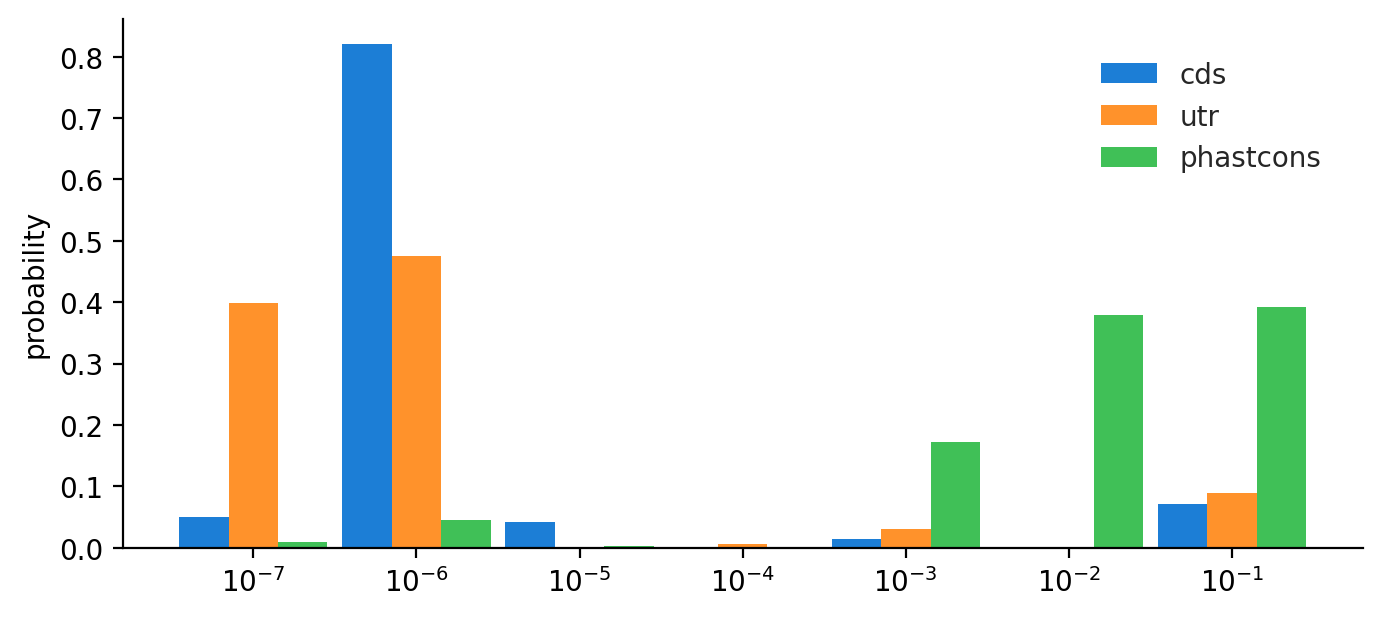

In [677]:
xt = np.log10(fit.t)

fig, ax = plt.subplots()

w = 1/3-0.03
hw = w/2
ax.bar(xt-w-hw, fit.mle_W_norm[:, 0], align='edge', width=w, label='cds')
ax.bar(xt-hw, fit.mle_W_norm[:, 2], align='edge', width=w, label='utr')
ax.bar(xt+w-hw, fit.mle_W_norm[:, 1], align='edge', width=w, label='phastcons')

ax.set_xticks(np.log10(fit.t), [f"$10^{{{int(x)}}}$" for x in xt])
ax.set_ylabel('probability')
ax.legend()

### Rescaling

After the MLE is estimated, we get a predicted B(x) map. We can use the local B(x) in the system of equations we solve for B and the ratchet rate; this is the "local rescaling" step since the single $N_e$ is rescaled locally along the genome.

What is the distribution of the local rescaling factors (e.g. B) across segments? 

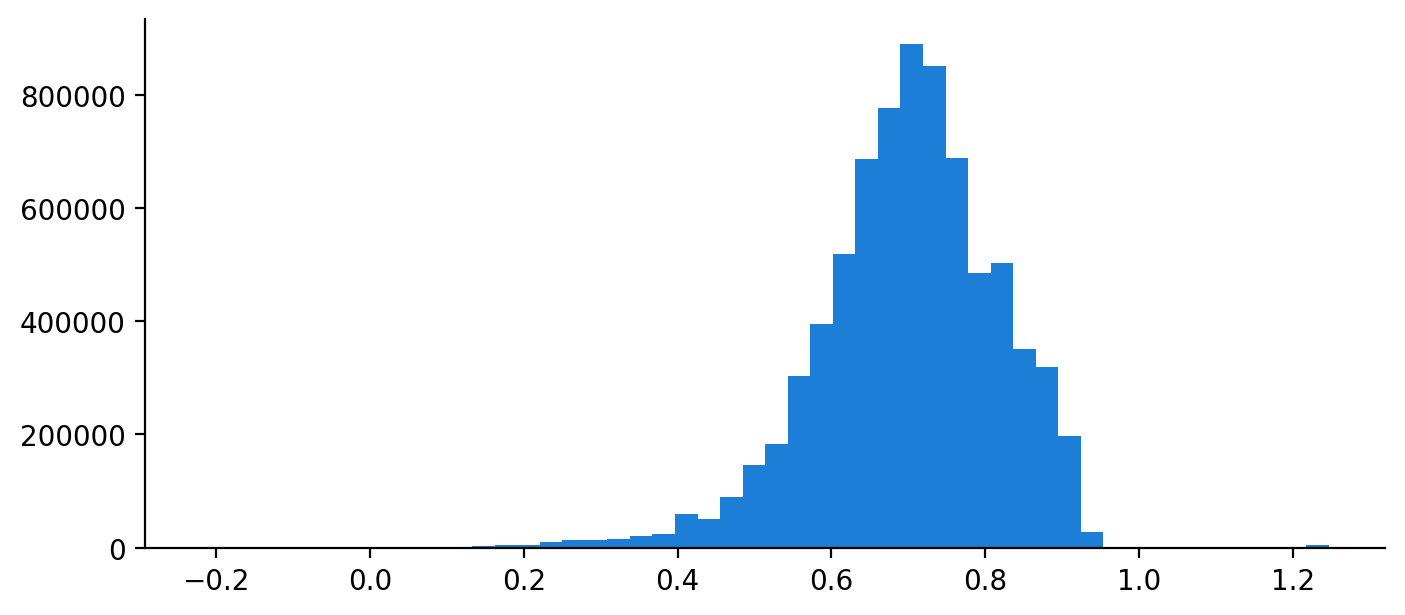

In [683]:
_ = plt.hist(mf.genome.segments.rescaling, 50)

In [686]:
mf.genome.segments.rescaling.mean()

0.6998490873081481

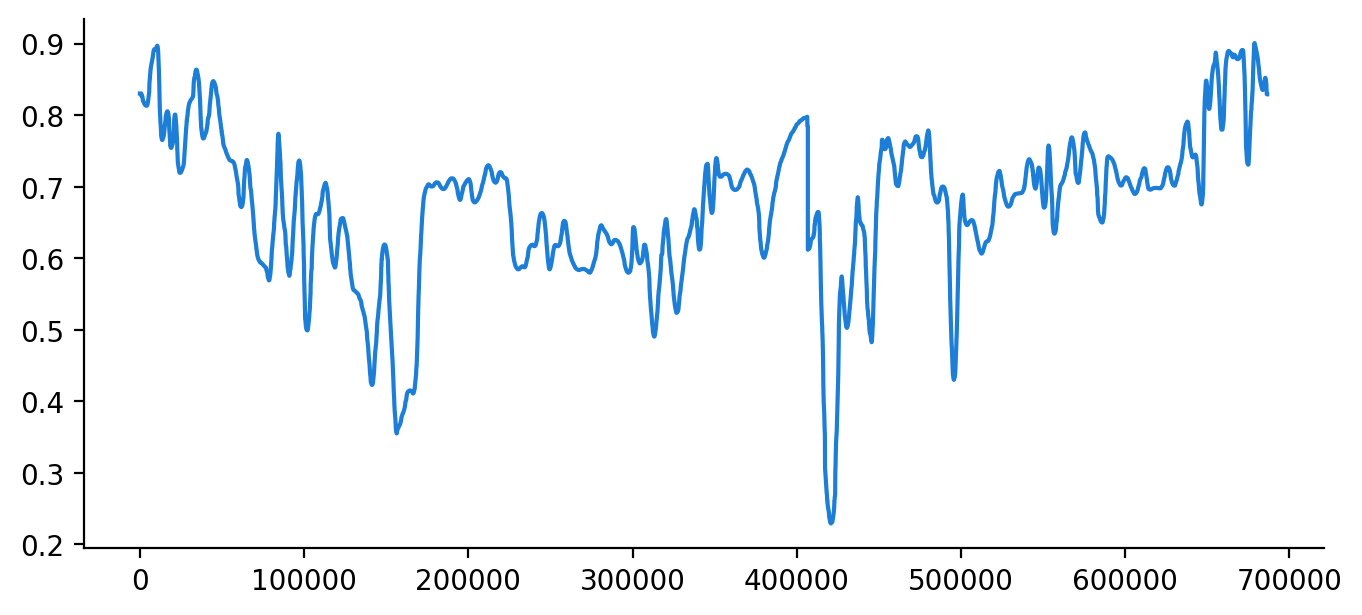

In [687]:
plt.plot(mf.genome.segments.rescaling[mf.genome.segments.index['chr1']])

How does the locally-rescaled B' differ from unscaled one?

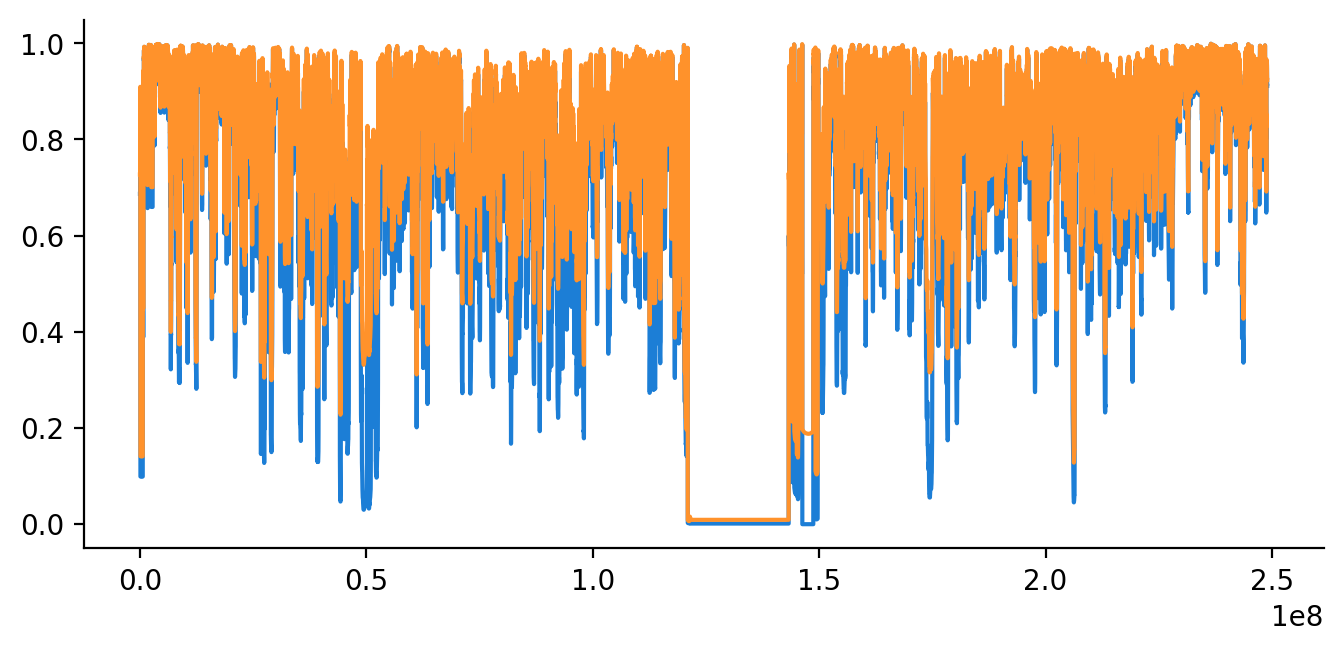

In [689]:
x, y = m.BpScores.pairs('chr1', m.w[4], 1e-4)
plt.plot(x, y[:, 1])

x, y = mf.BpScores.pairs('chr1', mf.w[4], 1e-4)
plt.plot(x, y[:, 1])

### Uricchio et al (2019) Substitution Data

From [this paper](https://www.nature.com/articles/s41559-019-0890-6). See the `data/phylo/Snakefile` for more information on how this is processed. 

Since we want the proportion of subsitutions and the Urrichio data doesn't have the number of codons considered, I joined Uricchio's data with the Ensembl canonical transcript CDS lengths.

This dataset also has the phylofit substitution rates joined in.

The raw Uricchio data (`../data/phylo/41559_2019_890_MOESM3_ESM.txt`) has columns:
   
1. Ensembl coding gene ID
2. Number of non-synonymous polymorphic sites
3. Respective derived allele frequencies of these sites separated by commas
4. Number of synonymous polymorphic sites. 
5. Respective frequencies derived allele frequencies of these sites.
6. Number of fixed non-synonymous substitutions on the human branch.
7. Number of fixed synonymous substitutions on the human branch. 

In [889]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    'S', 
    'N',
    "r",
    "r_nbases",
    "r_rs", "r_rs_nbases",
    "branch_length",
    "bl_nbases",
    
]

d = pd.read_csv('../data/phylo/uricchio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']
d['midpoint'] = 0.5*(d['start'] + d['end'])

In [890]:
d.head()

chrom   start     end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1  923923  944575  ENSG00000187634        28     21             8   
1  chr1  944203  959309  ENSG00000188976        31     32             4   
2  chr1  960584  965719  ENSG00000187961        11     28             0   
3  chr1  966482  975865  ENSG00000187583        47     19             0   
4  chr1  975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnDs  total_fixed  ...           S            N  \
0          4  2.000000           12  ...  677.333333  1854.666667   
1          8  0.500000           12  ...  524.666667  1722.333333   
2          8  0.000000            8  ...  484.000000  1442.000000   
3          3  0.000000            3  ...  473.666667  1359.333333   
4          3  3.666667           14  ...  626.000000  1744.000000   

              r  r_nbases          r_rs  r_rs_nbases  branch_length  \
0  2.502833e-08      4658  5.035896e-09         4658       0.009005   
1  4.107783e-08      2950  4.688058e-09         2950       0.009129   
2  4.222435e-08      2776  5.717414e-09         2776       0.009129   
3  3.766140e-08      3800  4.771755e-09         3800       0.009129   
4  4.105993e-08      4203  6.126825e-09         4203            NaN   

   bl_nbases  width  midpoint  
0    96703.0  20652  934249.0  
1    55542.0  15106  951756.0  
2    55542.0   5135  963151.5  
3    55542.0   9383  971173.5  
4        NaN   6919  978657.5  

[5 rows x 28 columns]

In [891]:
for chrom in d.chrom.unique():
    d.loc[d['chrom'] == chrom, 'B'] = bpfit.predict_B_at_pos(chrom, d.loc[d['chrom'] == chrom, 'midpoint'])

Some summary statistics on the lengths of genes, and number of bases used for estimates:

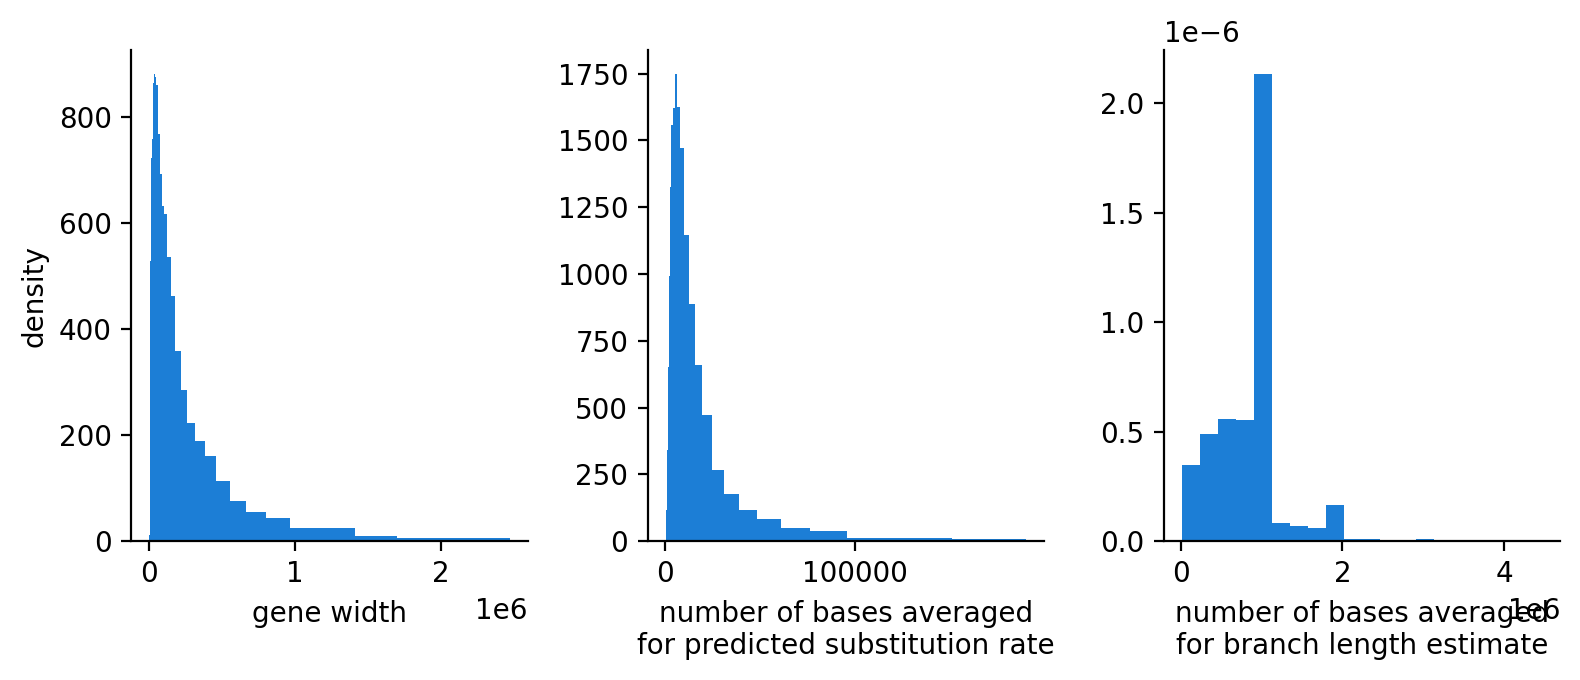

In [892]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

What's the correspondance between phylofit branch lengths and Uricchio's substitution proportions?

In [893]:
corr(d['branch_length'], d['total_prop'])

((0.1674625136298407, 4.4498990795268144e-85),
 SpearmanrResult(correlation=0.206790854125823, pvalue=1.1222011876070762e-129))

In [894]:
corr(d['branch_length'], d['syn_prop'])

((0.14806506559564211, 1.0246408682489994e-66),
 SpearmanrResult(correlation=0.1699826587436179, pvalue=1.2268769265975793e-87))

In [861]:
corr(d['branch_length'], d['nonsyn_prop'])

((0.12684957228228788, 2.6212014059155865e-49),
 SpearmanrResult(correlation=0.13419846333442986, pvalue=5.0316817080962134e-55))

#### Outlier Filtering

Text(0.5, 0, 'predicted substitution rate')

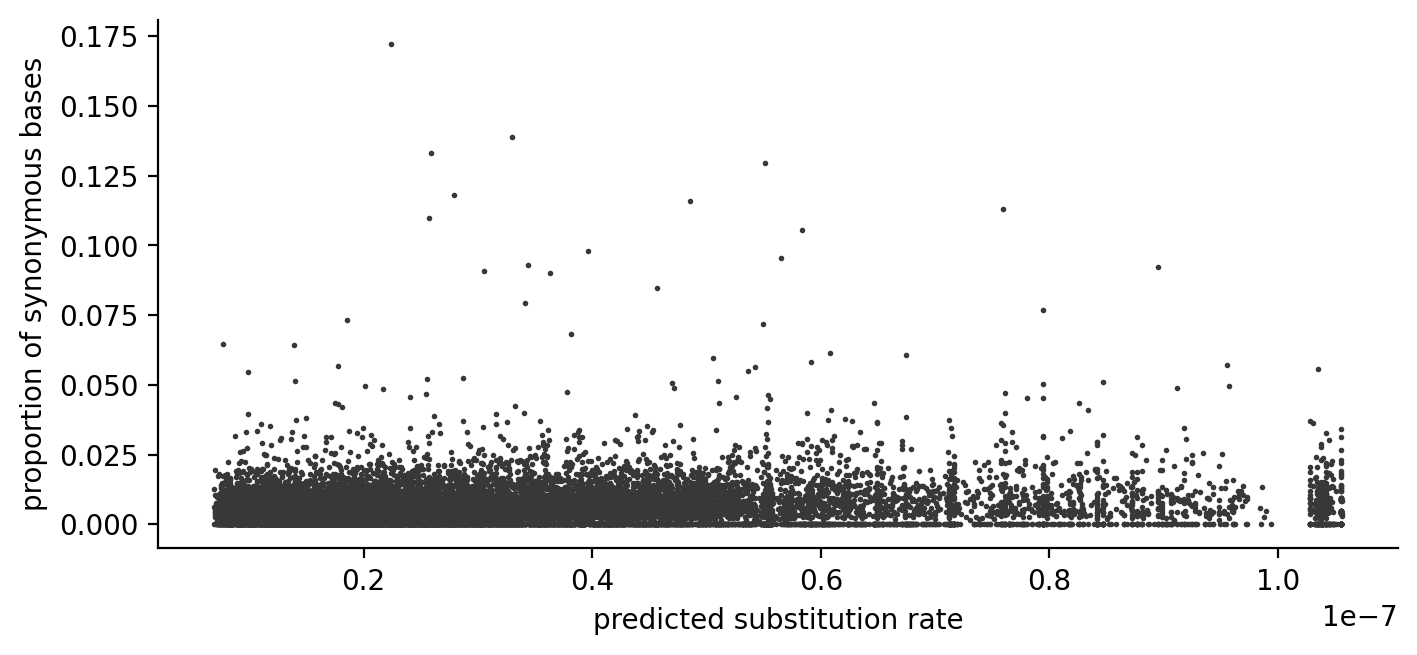

In [862]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

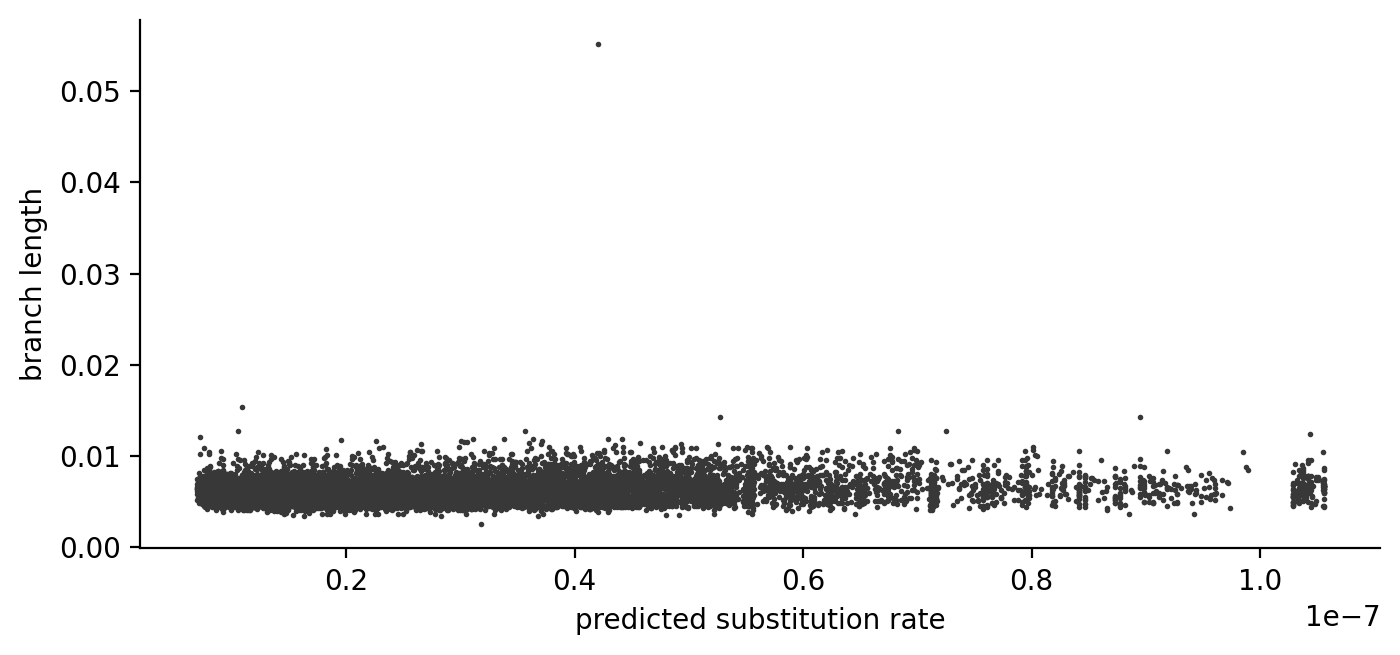

In [863]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

Note the strange clump of high predicted substitution rates in both of these figures — what's going on?

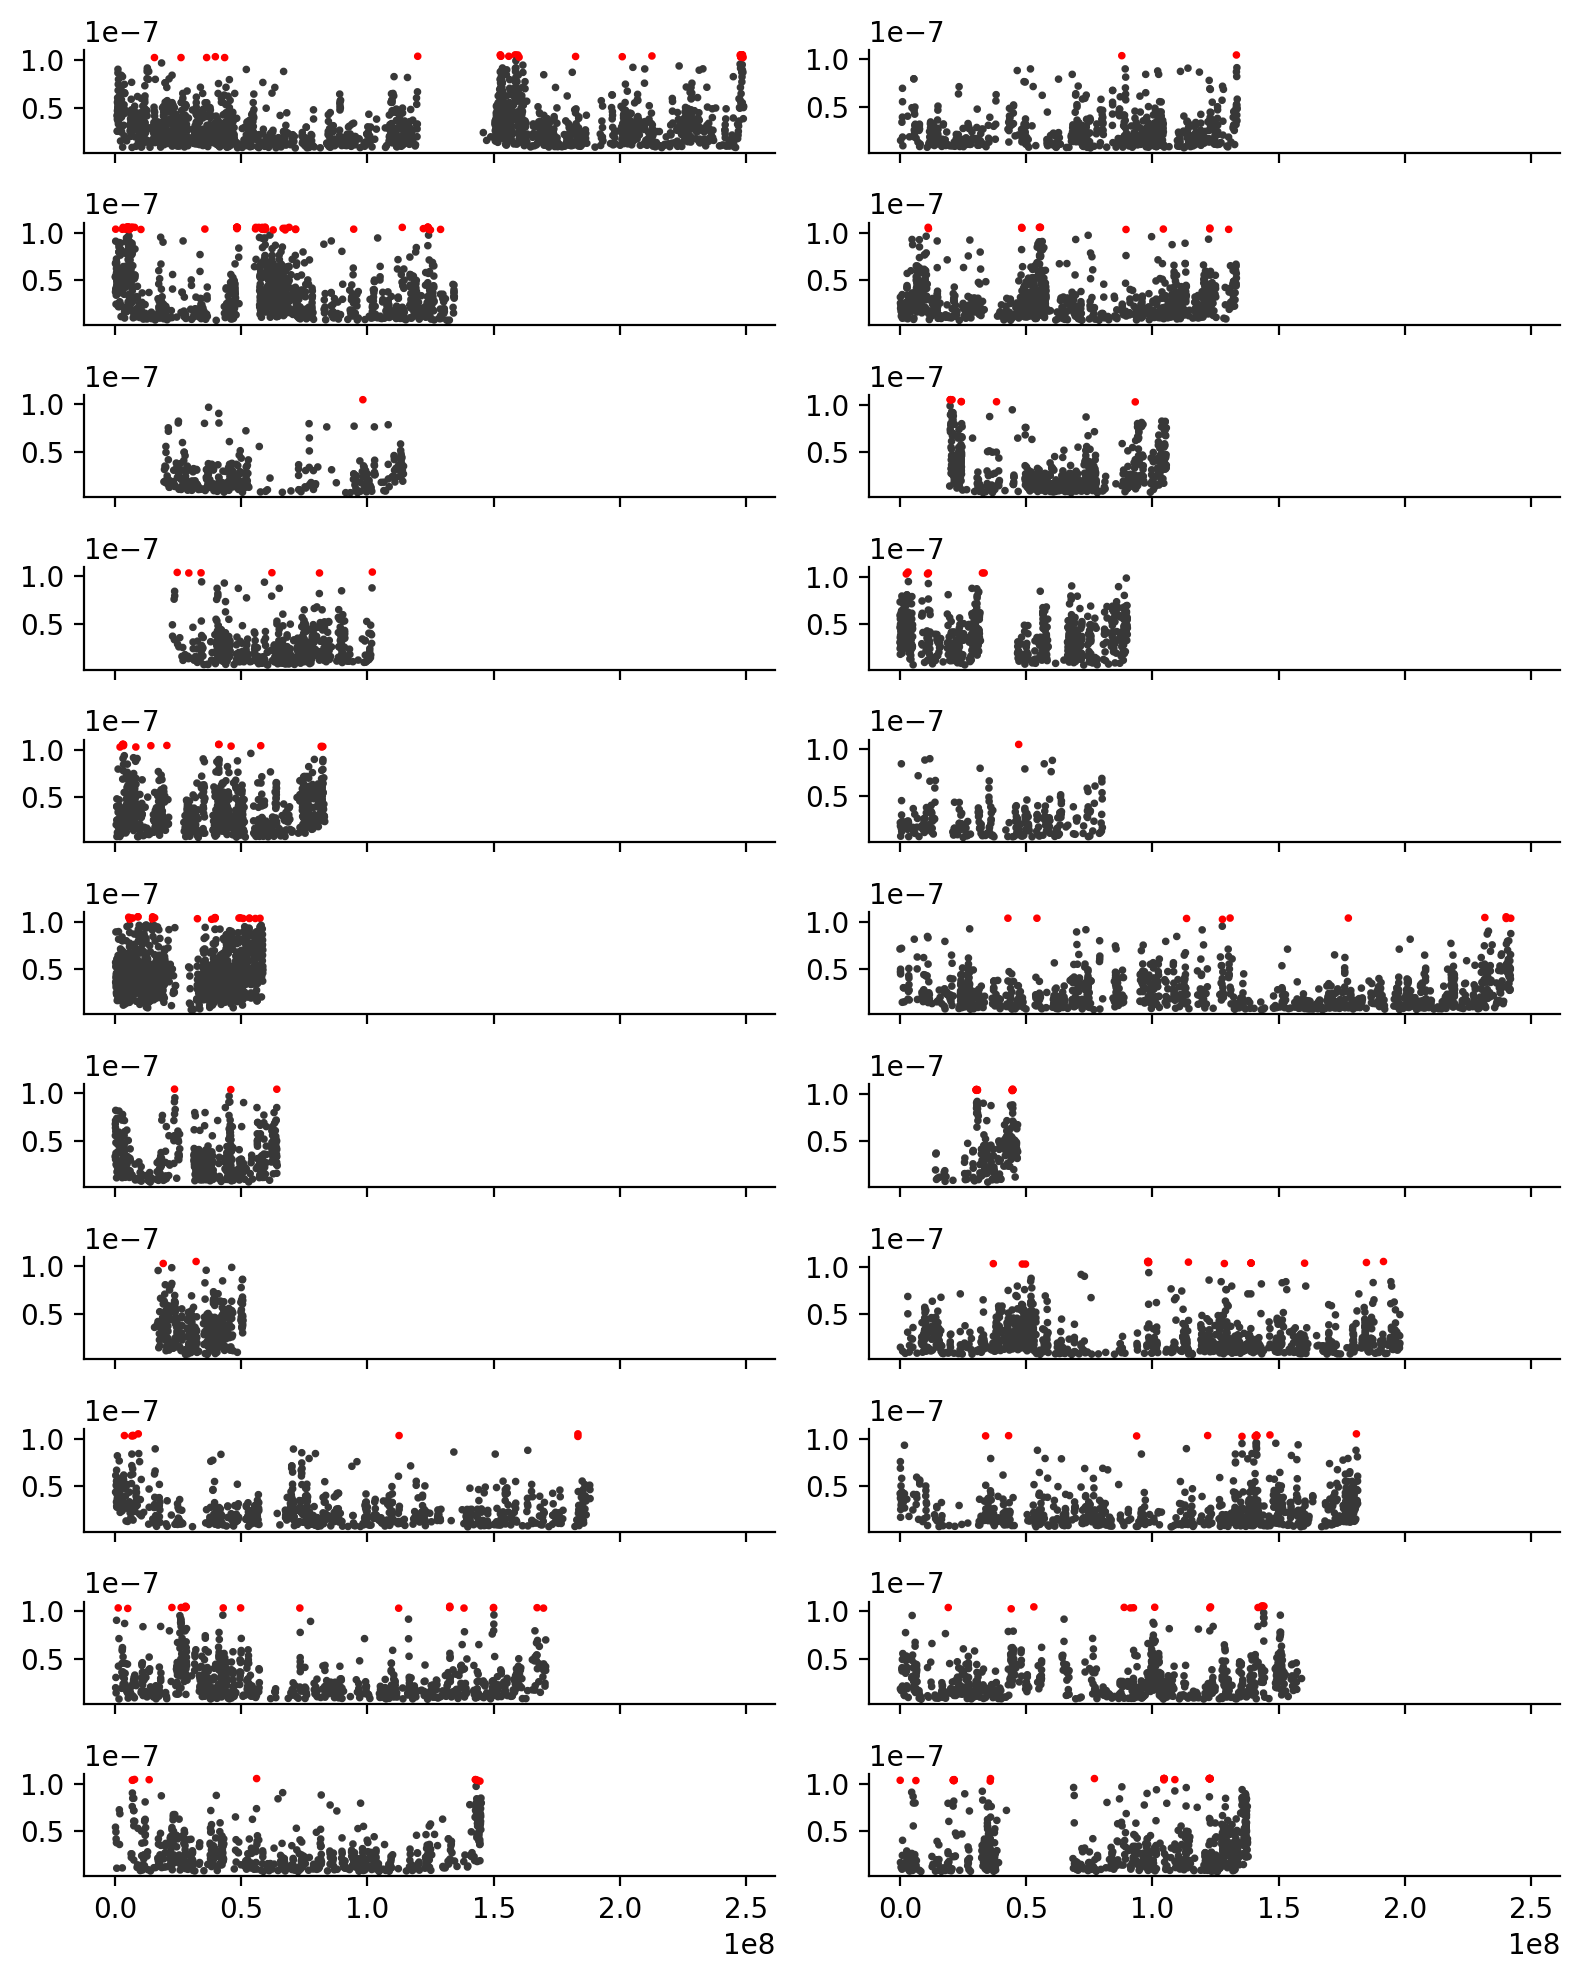

In [864]:
r_thresh = 1e-7

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['r'] > r_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['r'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

This looks to be some pathology — we will remove these.

Now let's look at branch length (from PhyloFit) in the Urrichio et al data along the genome. Immediately we see some very strong outliers that we remove.

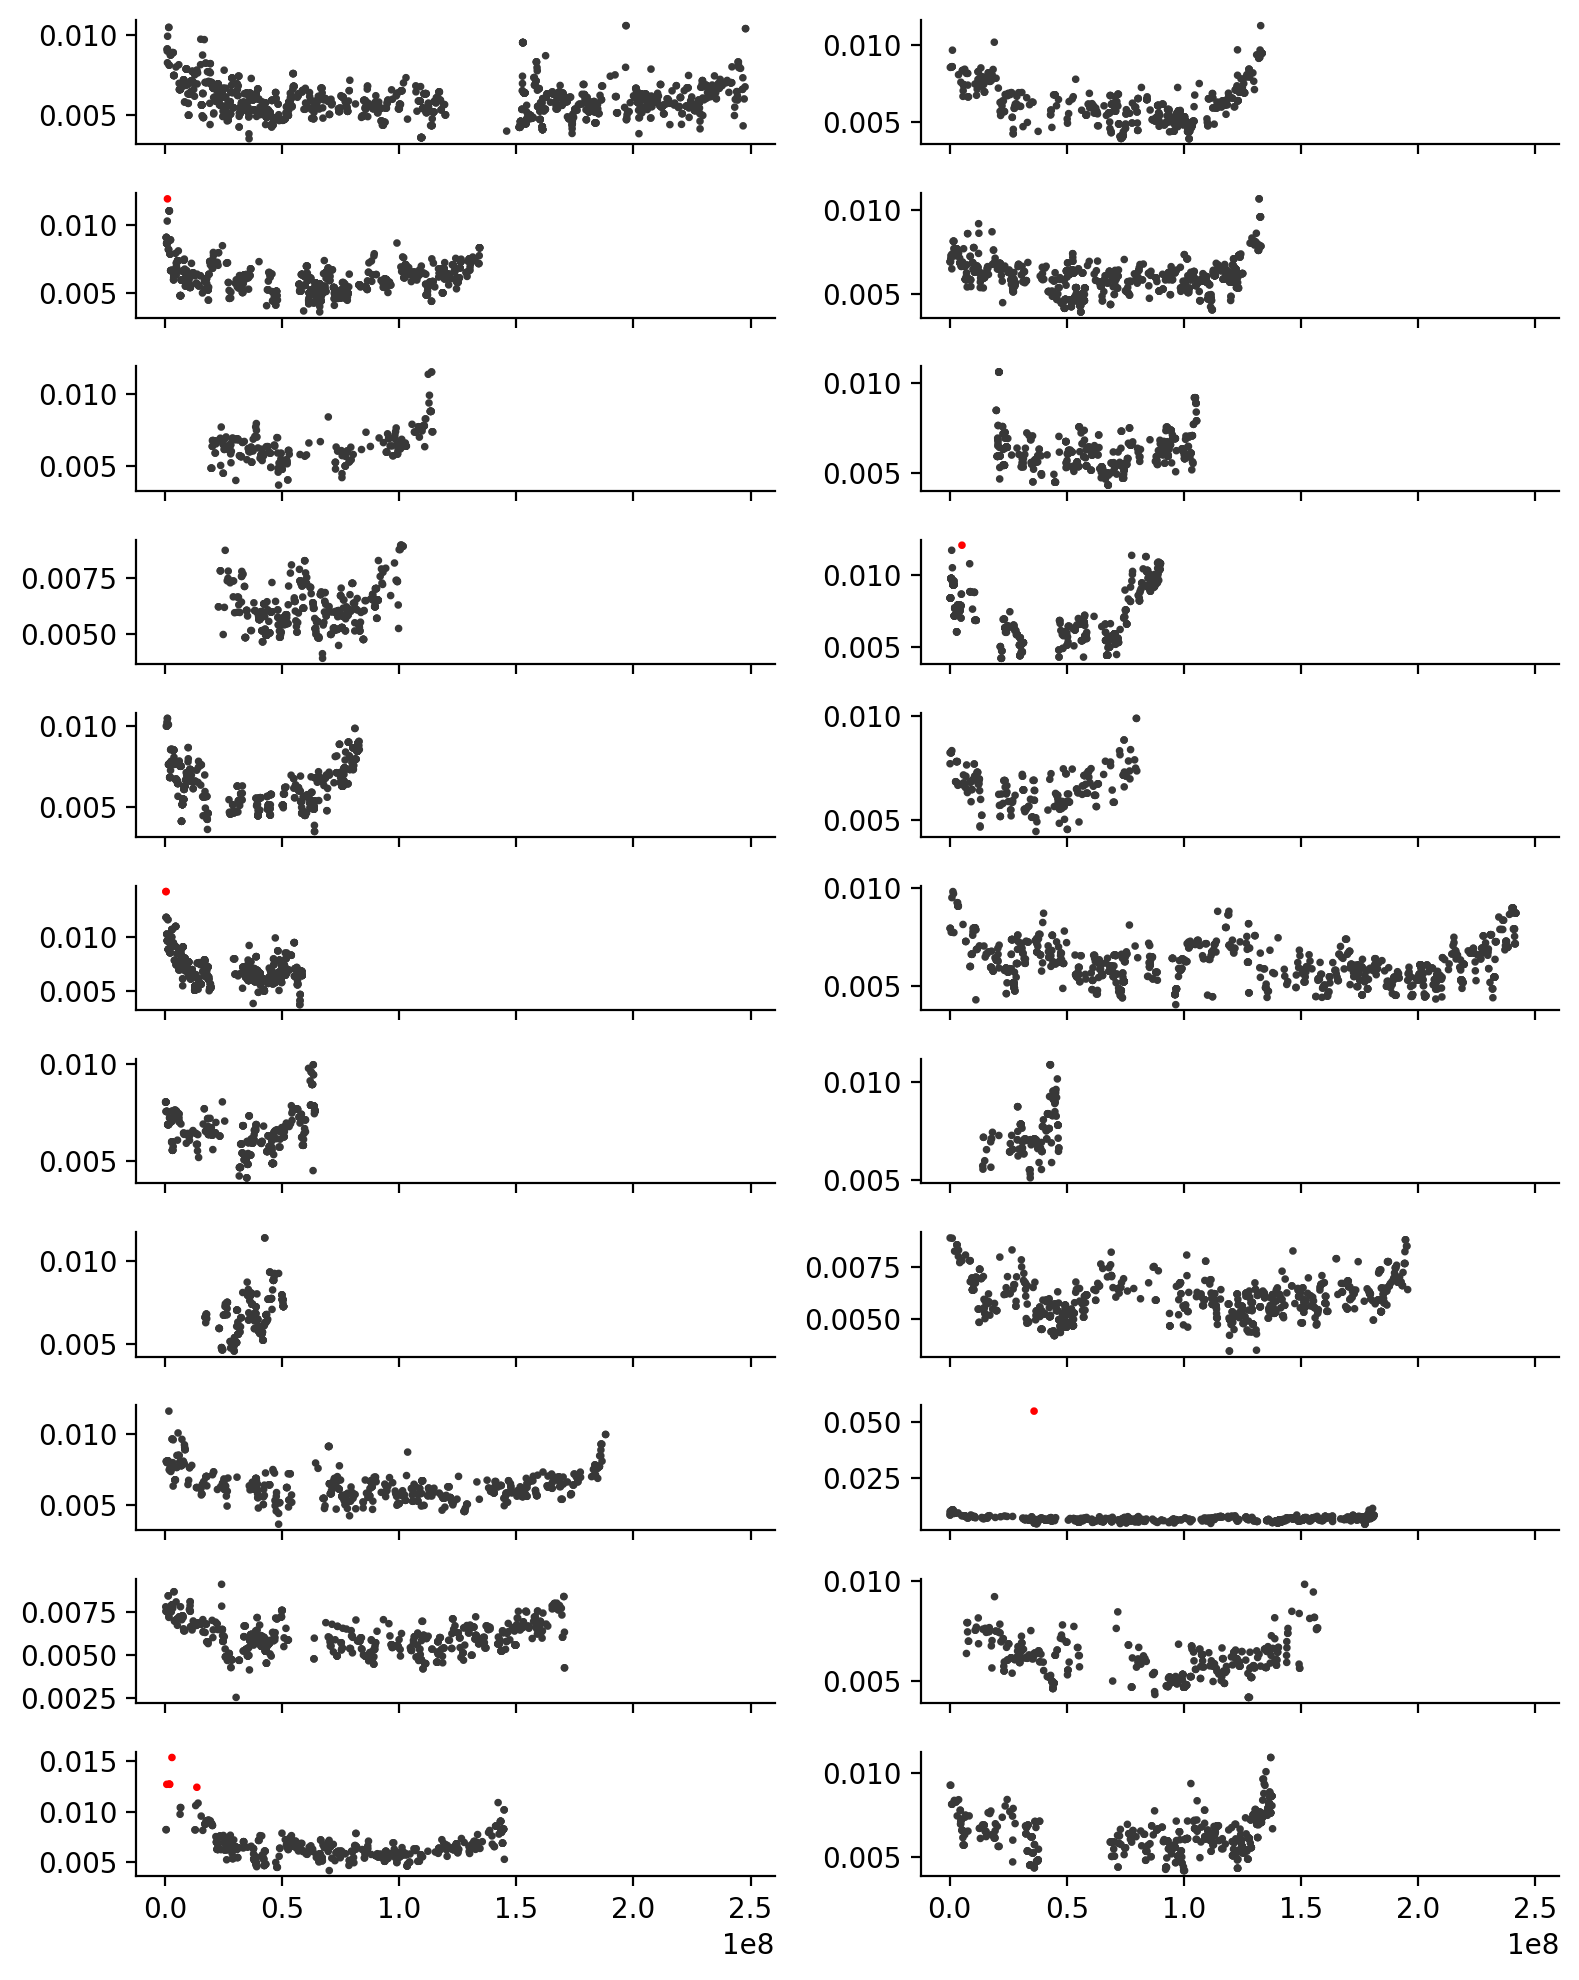

In [865]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [895]:
# remove outliers
do = d.loc[(d['branch_length'] < thresh) & (d['r'] < r_thresh)]

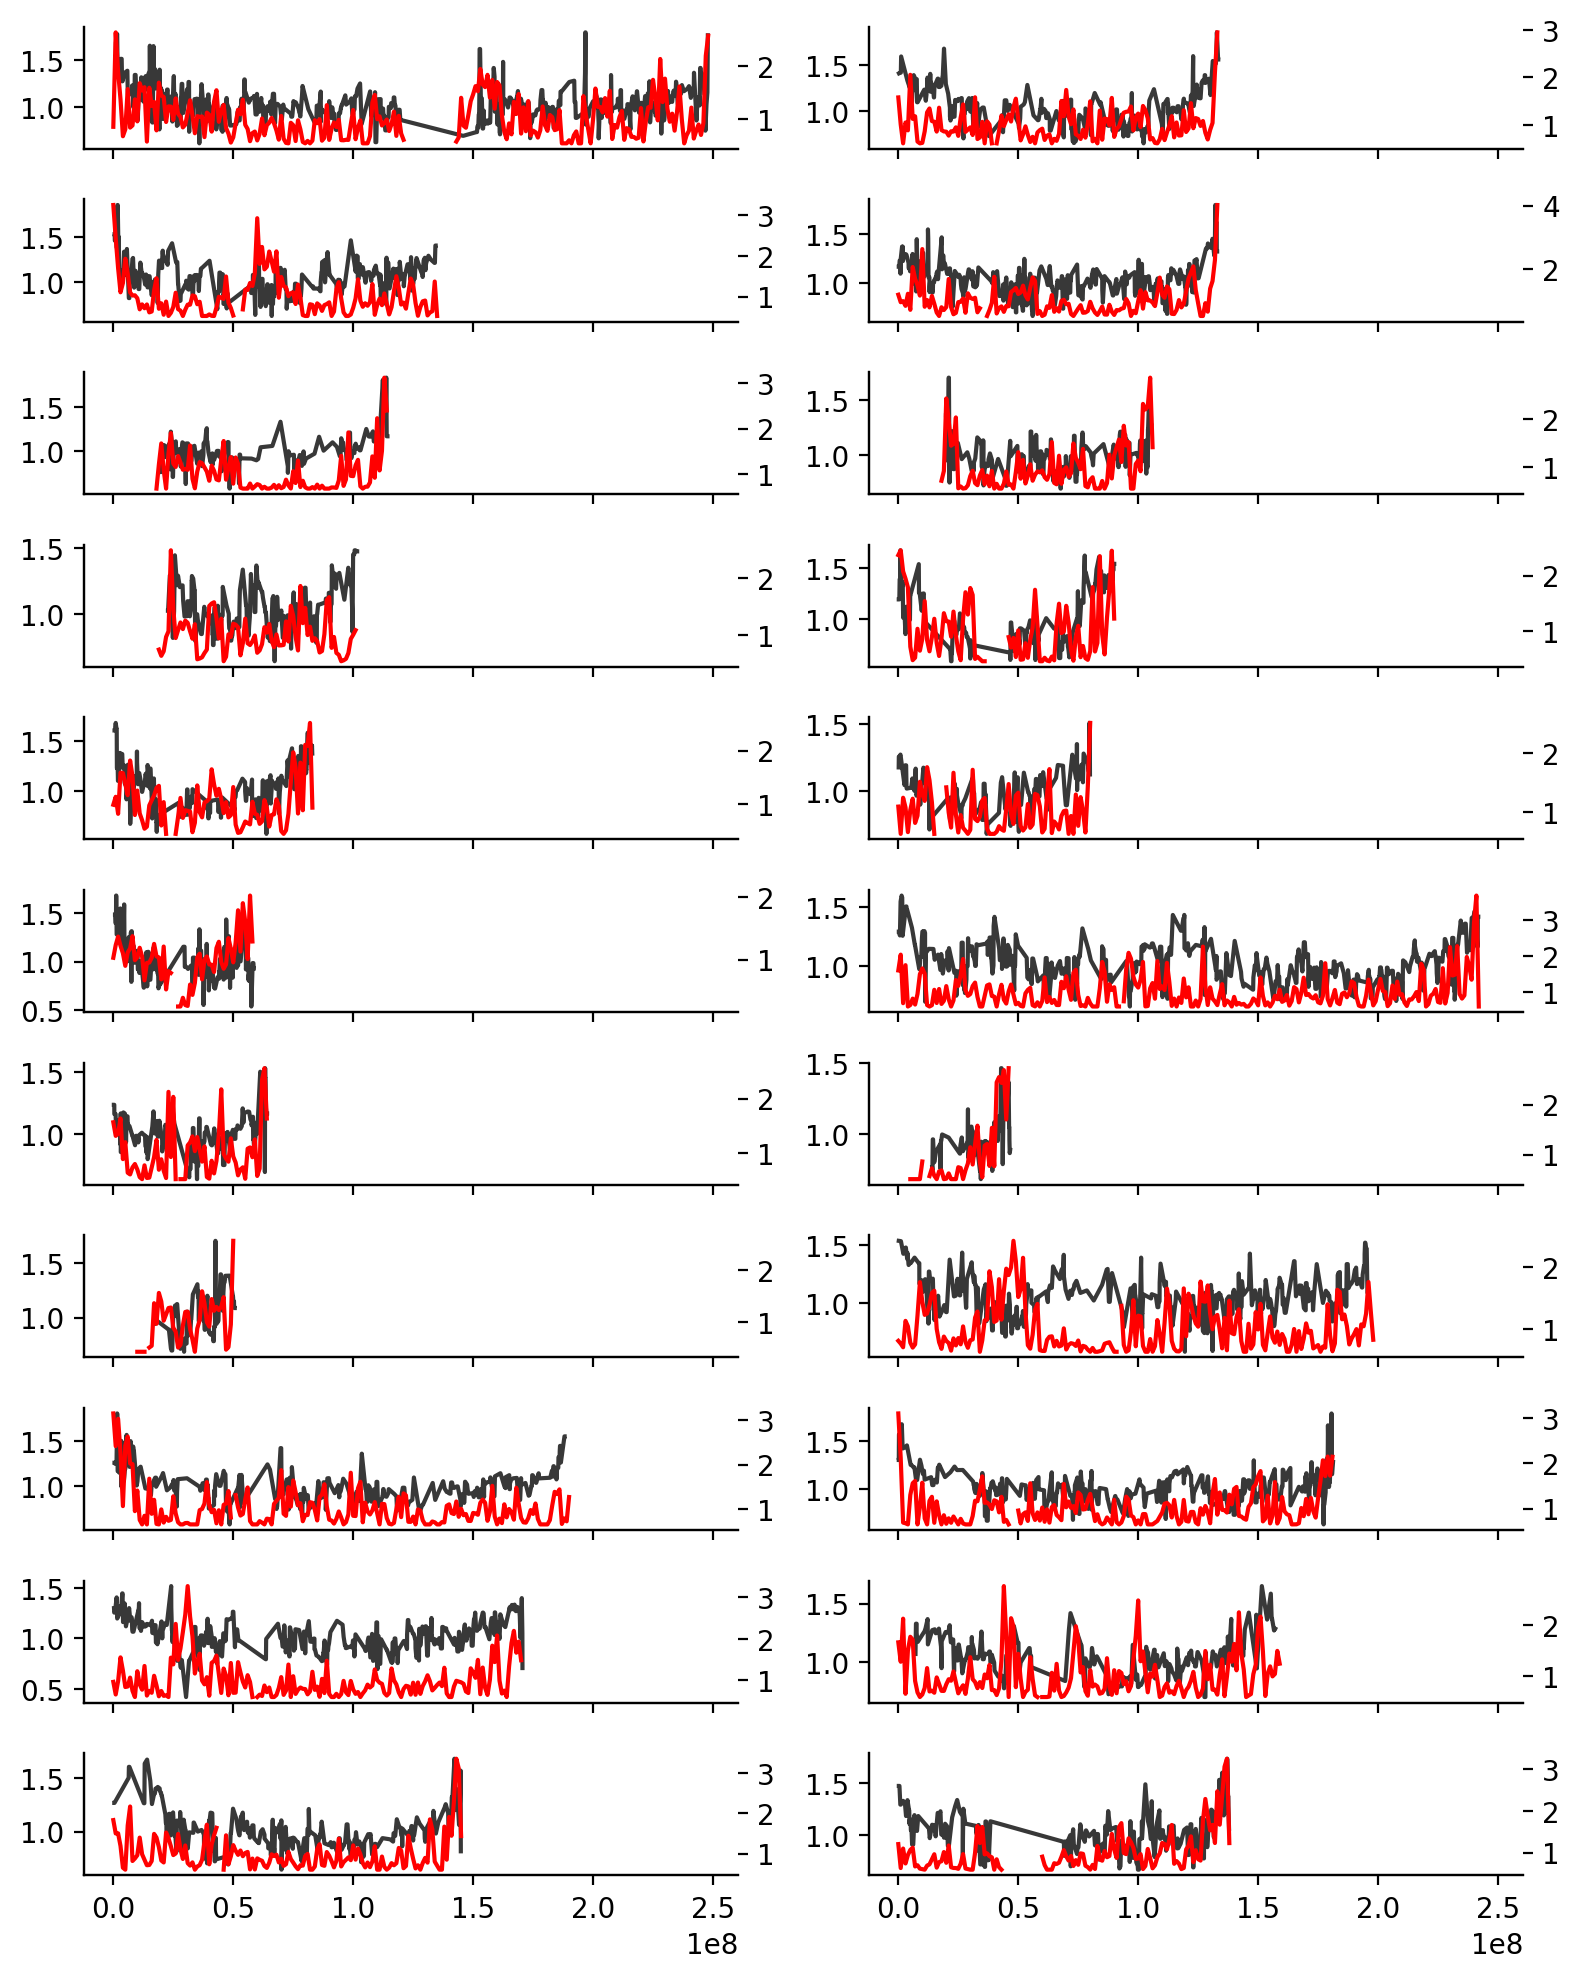

In [867]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(do['chrom'].unique()):
    dx = do.loc[do['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], mean_ratio(dx['branch_length']), c='0.22')
    ax2 = fax.twinx()
    
    rx = rd_1Mbp.loc[rd_1Mbp['chrom'] == chrom]
    ax2.plot(rx['start'], mean_ratio(rx['r']), c='r')
    
    #rx = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == chrom]
    #ax2.plot(rx['start'], mean_ratio(rx['r']), c='g', linestyle='dashed')
plt.tight_layout()

There's some rough correpondance here — we will explore this more later.

What about the coefficient of variance?

In [868]:
do['total_prop'].aggregate(lambda x: x.std()/x.mean())

1.087168751551404

### PhyloFit Branch Length Estimates

The raw phylofit data, see the `Snakefile` for how this is processed.

Note that the alignments are fairly large and between 10 primate species. The regions that can be aligned are likely under more contraint compared to regions that are not alignable. 

In [869]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)
p['width'] = p['end'] - p['start']

In [870]:
p.head()

chrom    start      end  branch_length  bl_nbases   width
0  chr1   917515   943305       0.008880      41161   25790
1  chr1   943306   972277       0.009129      55542   28971
2  chr1  1034538  1055058       0.006629      33328   20520
3  chr1  1055059  1167921       0.009928     459429  112862
4  chr1  1564774  1623511       0.010481     178850   58737

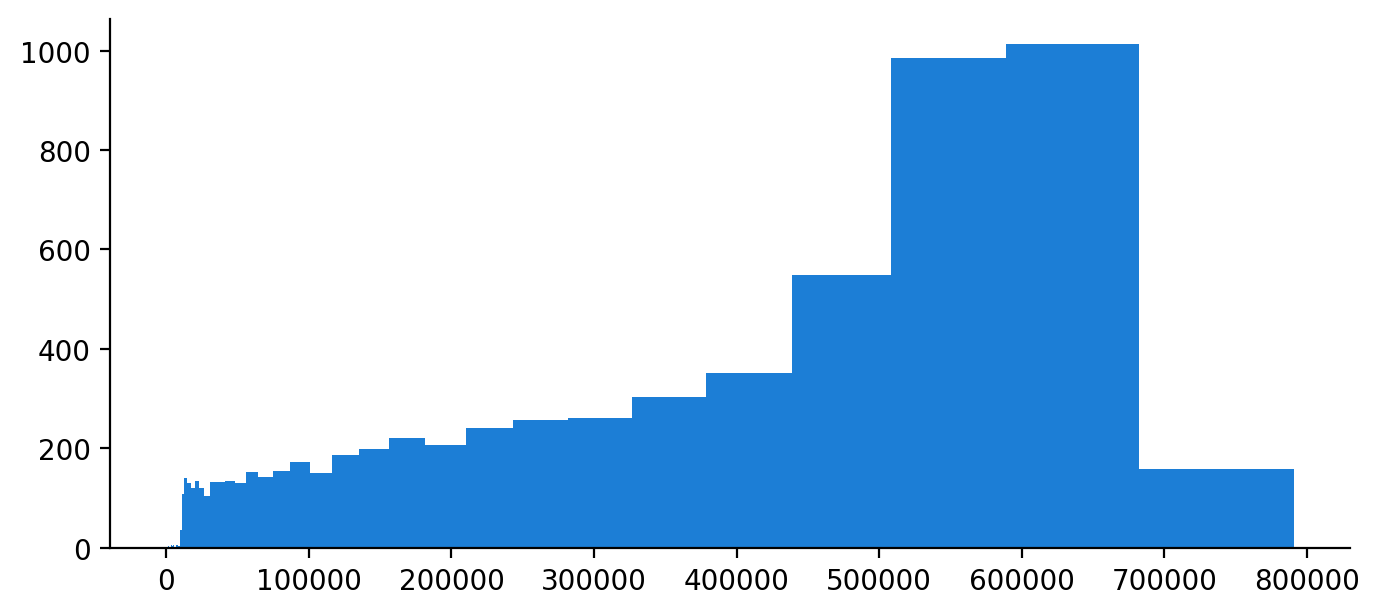

In [871]:
_ = plt.hist(*logbins(p['width'], 60))

[]

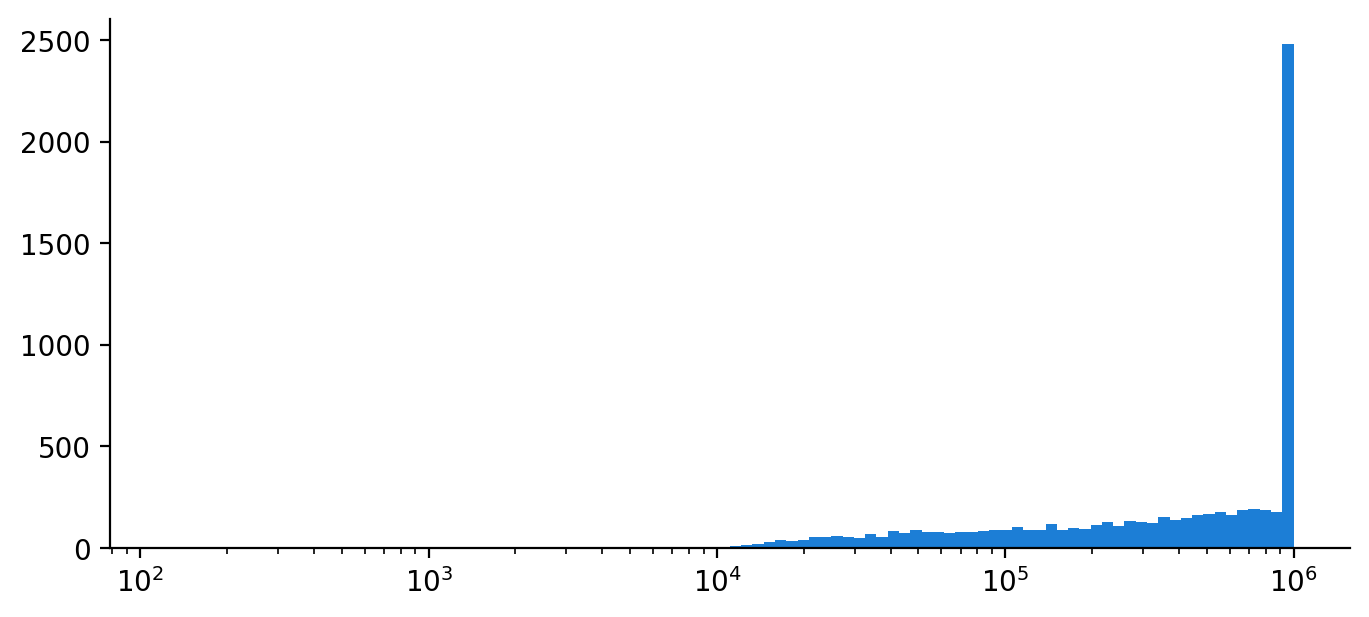

In [872]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [873]:
p['bl_nbases'].max()

1000000

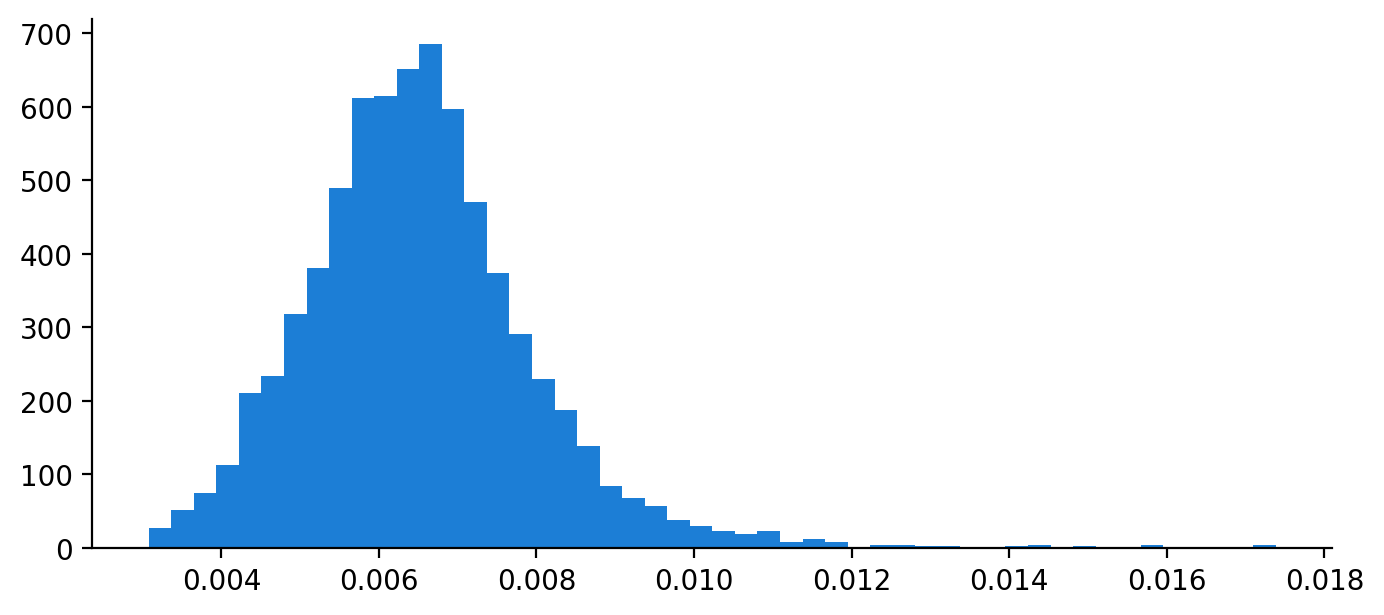

In [874]:
_ = plt.hist(censor(p['branch_length'], (0.001, 0.999)), 50)

### Binned Ratchet Rates (Megabase)

In [875]:
cols = ('chrom', 'start', 'end', 'R', 'r', 'r_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')
r1Mb['midpoint'] = 0.5*(r1Mb['start'] + r1Mb['end'])

### Binned Phylofit Estimates

In [876]:
cols = ('chrom', 'start', 'end', 'branch_length', 'bl_nbases')

pf_1Mbp = pd.read_csv('../data/phylo/phylofit_rates_binned_1000000.bed',
                      names=cols, sep='\t', na_values='.')

pf_1Mbp['midpoint'] = 0.5*(pf_1Mbp['start']+pf_1Mbp['end'])

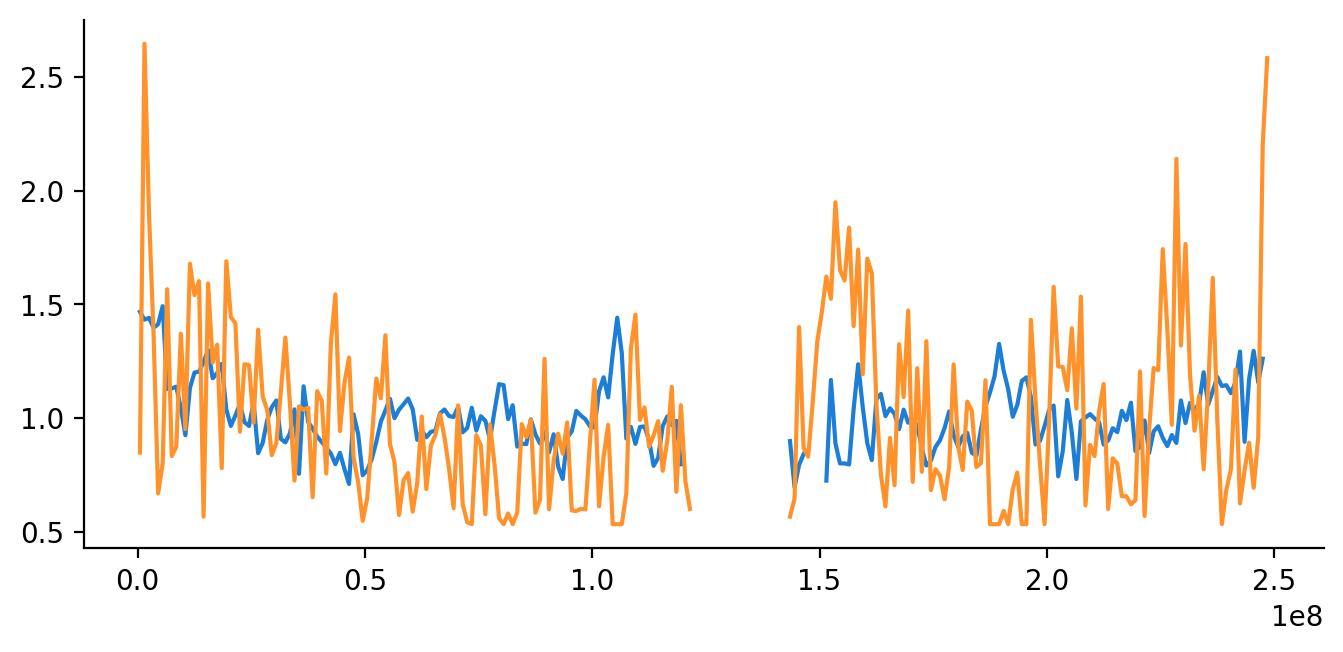

In [877]:
chrom = 'chr1'

pf_1Mbp_chr1 = pf_1Mbp.loc[pf_1Mbp['chrom'] == chrom]
plt.plot(pf_1Mbp_chr1['midpoint'], mean_ratio(pf_1Mbp_chr1['branch_length']))

r1Mb_chr1 = r1Mb.loc[r1Mb['chrom'] == chrom]

plt.plot(r1Mb_chr1['midpoint'], mean_ratio(r1Mb_chr1['r']))


### Merged Predicted Ratchet Rates and PhyloFit Branch Lengths

In [878]:
# There are two ways to process this. 

dpf2r = pd.read_csv('../data/phylo/phylofit_to_ratchet.bed', sep='\t',
                    na_values='.',
                    names=('chrom', 'start', 'end', 'feature', 'R', 'r', 'r_nbases', 'branch_length'))

dr2pf = pd.read_csv('../data/phylo/ratchet_to_phylofit.bed', sep='\t',
                    na_values='.',
                    names=('chrom', 'start', 'end', 'branch_length', 'bl_nbases', 'r', 'r_nbases'))

# remove X!
dr2pf = dr2pf.loc[dr2pf['chrom'] != 'chrX']
dpf2r = dpf2r.loc[dpf2r['chrom'] != 'chrX']

dr2pf['width'] = dr2pf['end'] - dr2pf['start']
dpf2r['width'] = dpf2r['end'] - dpf2r['start']

dr2pf.head()                

chrom    start      end  branch_length  bl_nbases             r  r_nbases  \
0  chr1   917515   943305       0.008880      41161  2.117563e-08    3928.0   
1  chr1   943306   972277       0.009129      55542  3.753585e-08    7572.0   
2  chr1  1034538  1055058       0.006629      33328  3.191825e-08    8087.0   
3  chr1  1055059  1167921       0.009928     459429  1.694682e-08    9367.0   
4  chr1  1564774  1623511       0.010481     178850  3.405017e-08    4785.0   

    width  
0   25790  
1   28971  
2   20520  
3  112862  
4   58737

In [879]:
dpf2r.head()                

chrom  start    end    feature             R             r  r_nbases  \
0  chr1  12007  12020  phastcons  6.089190e-08  4.683992e-09        13   
1  chr1  12021  12035  phastcons  6.557600e-08  4.684000e-09        14   
2  chr1  12039  12050  phastcons  5.152374e-08  4.683976e-09        11   
3  chr1  12065  12085  phastcons  9.368092e-08  4.684046e-09        20   
4  chr1  12176  12194  phastcons  8.431255e-08  4.684031e-09        18   

   branch_length  width  
0            NaN     13  
1            NaN     14  
2            NaN     11  
3            NaN     20  
4            NaN     18

(array([19087., 36392., 44153., 35872., 18926.,  8090.,  2229.,   966.,
          743.,    47.]),
 array([3.77395139e-09, 3.78260195e-09, 3.79125252e-09, 3.79990308e-09,
        3.80855365e-09, 3.81720422e-09, 3.82585478e-09, 3.83450535e-09,
        3.84315591e-09, 3.85180648e-09, 3.86045704e-09]),
 <BarContainer object of 10 artists>)

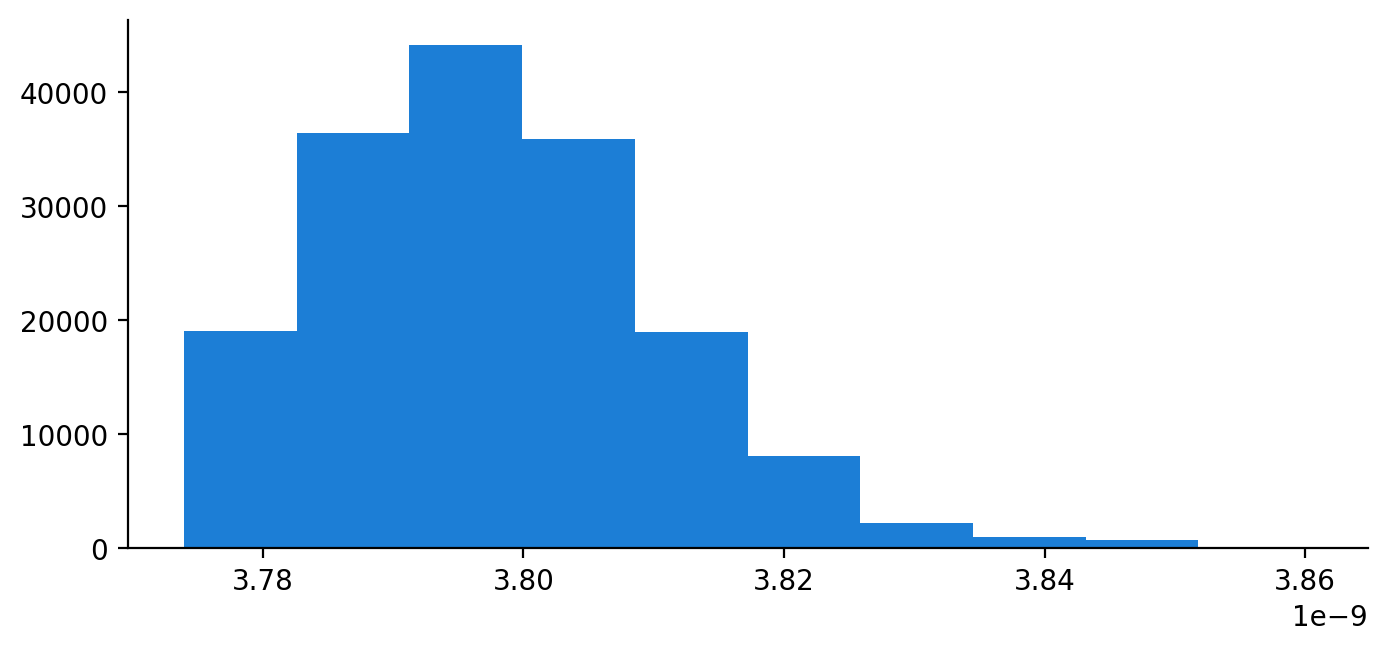

In [880]:
dpf2r_cds = dpf2r.loc[dpf2r['feature'] == 'cds']
dpf2r_utr = dpf2r.loc[dpf2r['feature'] == 'utr']
dpf2r_pc = dpf2r.loc[dpf2r['feature'] == 'phastcons']

plt.hist(dpf2r_cds['r'])

### Comparison of Substitution Rates Across Methods

In [881]:
dpf2r['branch_length'].mean(), dr2pf['branch_length'].mean(), do['branch_length'].mean()

(0.006348212937947674, 0.006712358643910008, 0.006207385811933438)

In [882]:
dpf2r['branch_length'].median(), dr2pf['branch_length'].median(), do['branch_length'].median()

(0.006261, 0.00648852, 0.00606866)

In [896]:
do['total_prop'].mean(), do['total_prop'].median()

(0.002435056503381581, 0.0019607843137254)

In [897]:
do['syn_prop'].mean(), do['syn_prop'].median()

(0.006055421280786474, 0.0049586776859504)

In [885]:
do['nonsyn_prop'].mean(), do['nonsyn_prop'].median()

(0.0013559943655394168, 0.00079270710856525)

In [899]:
d.loc[:, ('S', 'N', 'len')]

S            N   len
0       677.333333  1854.666667  2532
1       524.666667  1722.333333  2247
2       484.000000  1442.000000  1926
3       473.666667  1359.333333  1833
4       626.000000  1744.000000  2370
...            ...          ...   ...
16311   309.000000  1047.000000  1356
16312   152.333333   528.666667   681
16313   330.000000   969.000000  1299
16314   886.333333  3007.666667  3894
16315  1678.666667  5338.333333  7017

[16316 rows x 3 columns]

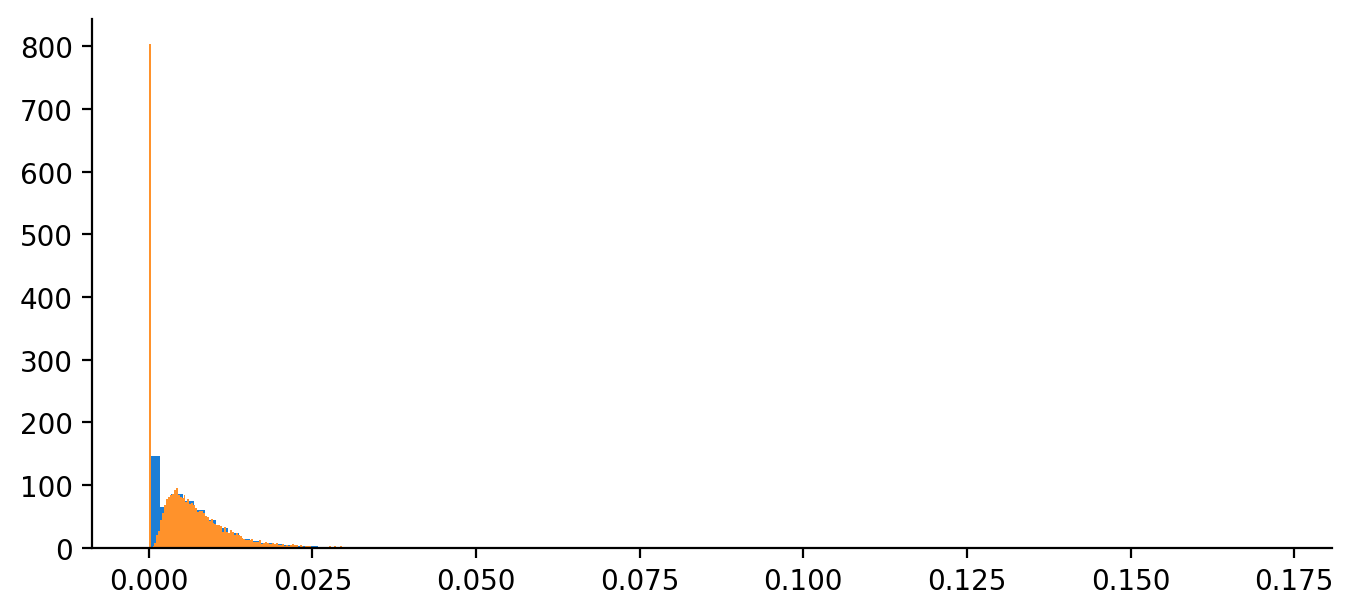

In [908]:
plt.hist(d['syn_prop'], 100, density=True)
_ = plt.hist(censor(d['fixed_syn']/d['S'], (0.01, 0.99)), 100, density=True)


## Substitution Data, EDA, and Predictions versus Observed

### Raw Ratchet Data (the R Maps)

Each segment under purifying selection has an accompanying estimate of $R$, the rate of substitutions in that segment (it scales with segment length). We work with the rescaled $R/l$ version, where $l$ is the segment length.

Note that our R maps are conservative, since they do not consider how B distorts $N_e$ further from the cummulative action of all segments (this probably explains the low CV shown below):

In [365]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen']

rd = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t', names=cols)
rd.groupby('feature')['r'].mean()

feature
cds          1.055389e-07
phastcons    6.620515e-09
utr          1.028444e-07
Name: r, dtype: float64

What's the coefficient of variation of predicted substitution rate?

In [108]:
rd.groupby('feature')['r'].aggregate(lambda x: x.std()/x.mean())

feature
cds          0.000079
phastcons    0.000040
utr          0.000117
Name: r, dtype: float64

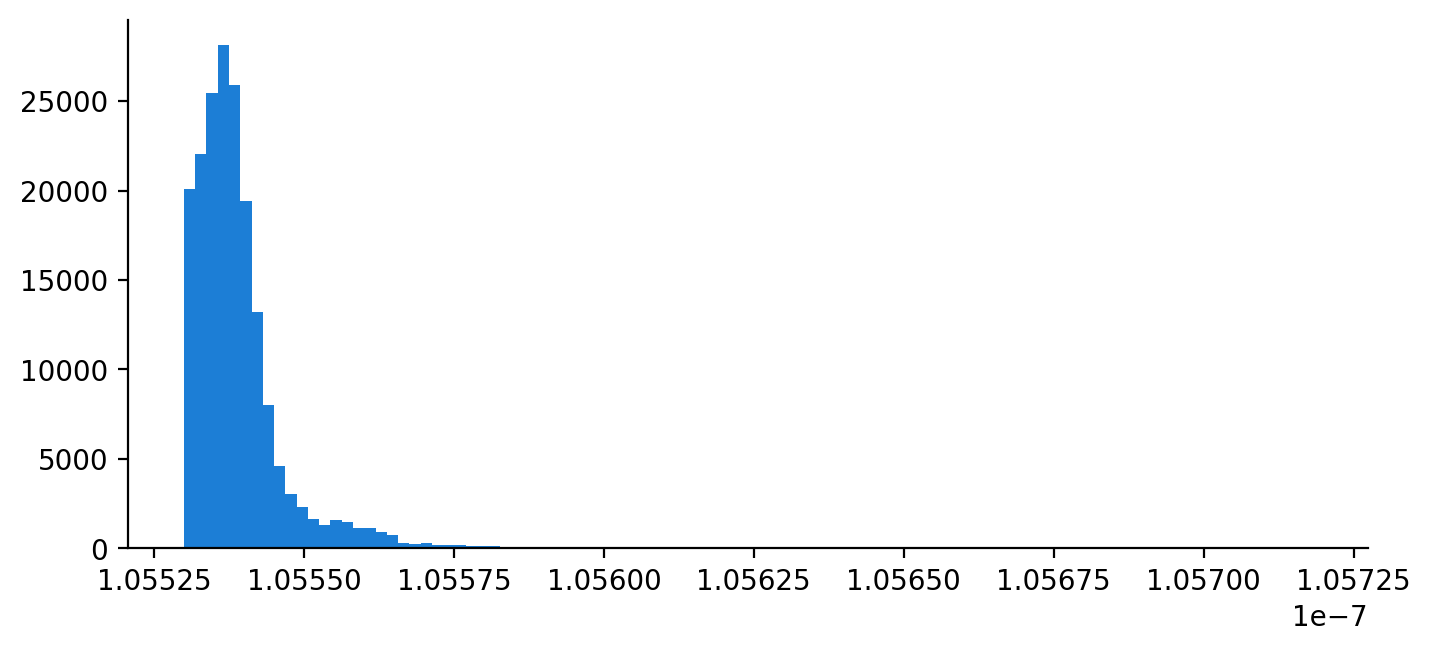

In [109]:
_ = plt.hist(rd.loc[rd['feature'] == 'cds'].r, 100)

In [421]:
rd2 = pd.read_csv('../data/phylo/ratchet_rescaled_data.bed', sep='\t', names=cols)
rd2.groupby('feature')['r'].median()

feature
cds          3.797030e-09
phastcons    4.700537e-09
utr          1.377000e-08
Name: r, dtype: float64

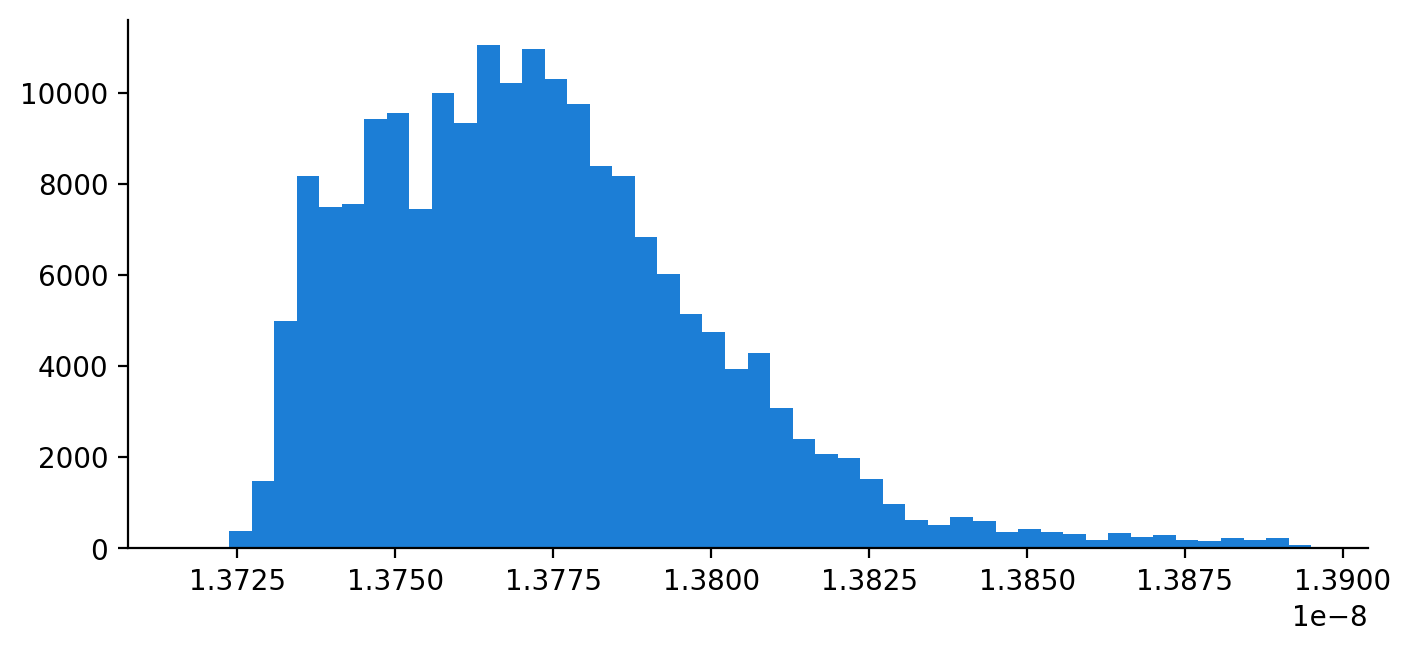

In [437]:
z = rd2.loc[rd2['feature'] == 'utr', 'r']
z = z[(z < np.quantile(z, 0.999)) & (z > np.quantile(z, 0.001))]
_ = plt.hist(z, 50)

In [112]:
rd2.groupby('feature')['r'].mean()

feature
cds          1.065021e-07
phastcons    1.746704e-08
utr          1.033114e-07
Name: r, dtype: float64

In [113]:
rd2.groupby('feature')['r'].aggregate(lambda x: x.std()/x.mean())

feature
cds           0.161731
phastcons    28.821403
utr           0.088414
Name: r, dtype: float64

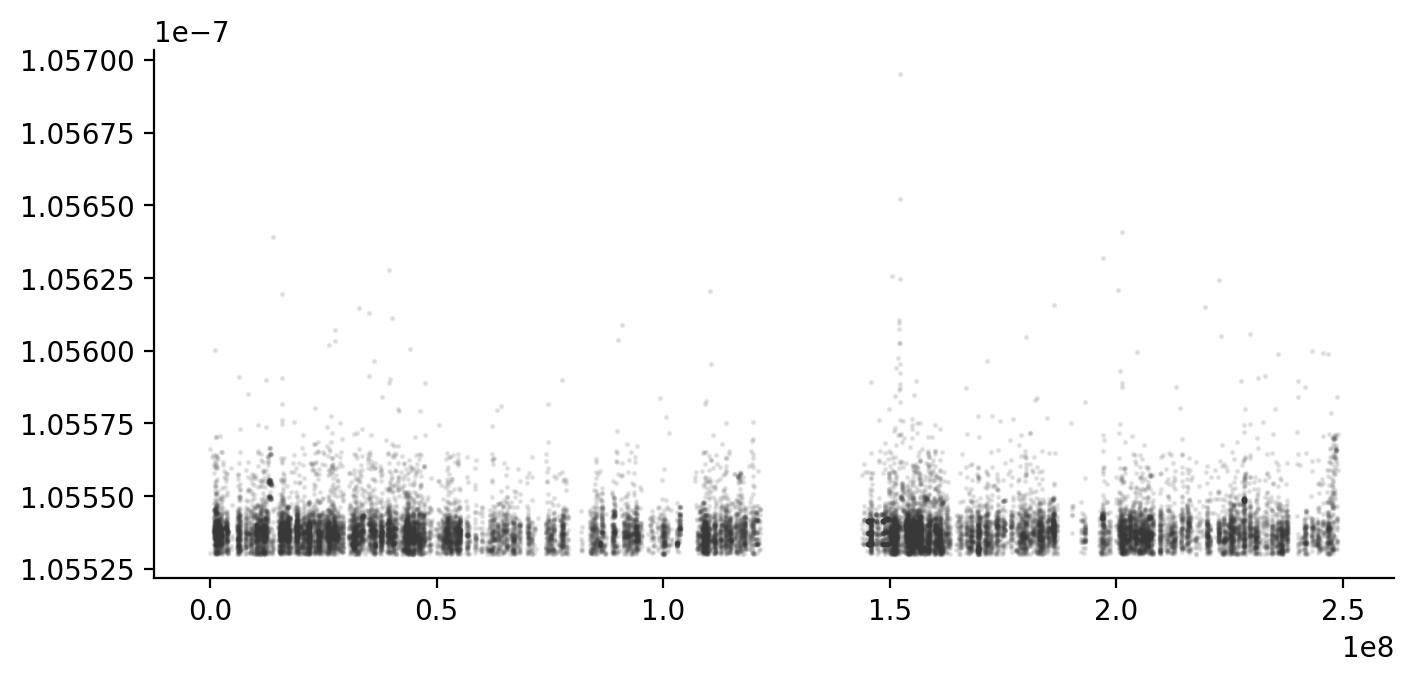

In [370]:
rdx = rd.loc[(rd['chrom'] == 'chr1') & (rd['feature'] == 'cds')]
plt.scatter(rdx['start'], rdx['r'], c='0.22', s=1, alpha=0.1)

In [452]:
rd_1Mbp = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', sep='\t',
                       na_values='.',
                       names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases'))

In [453]:
rd2_1Mbp = pd.read_csv('../data/phylo/ratchet_rescaled_rates_binned_1000000.bed', sep='\t',
                       na_values='.',
                       names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases'))

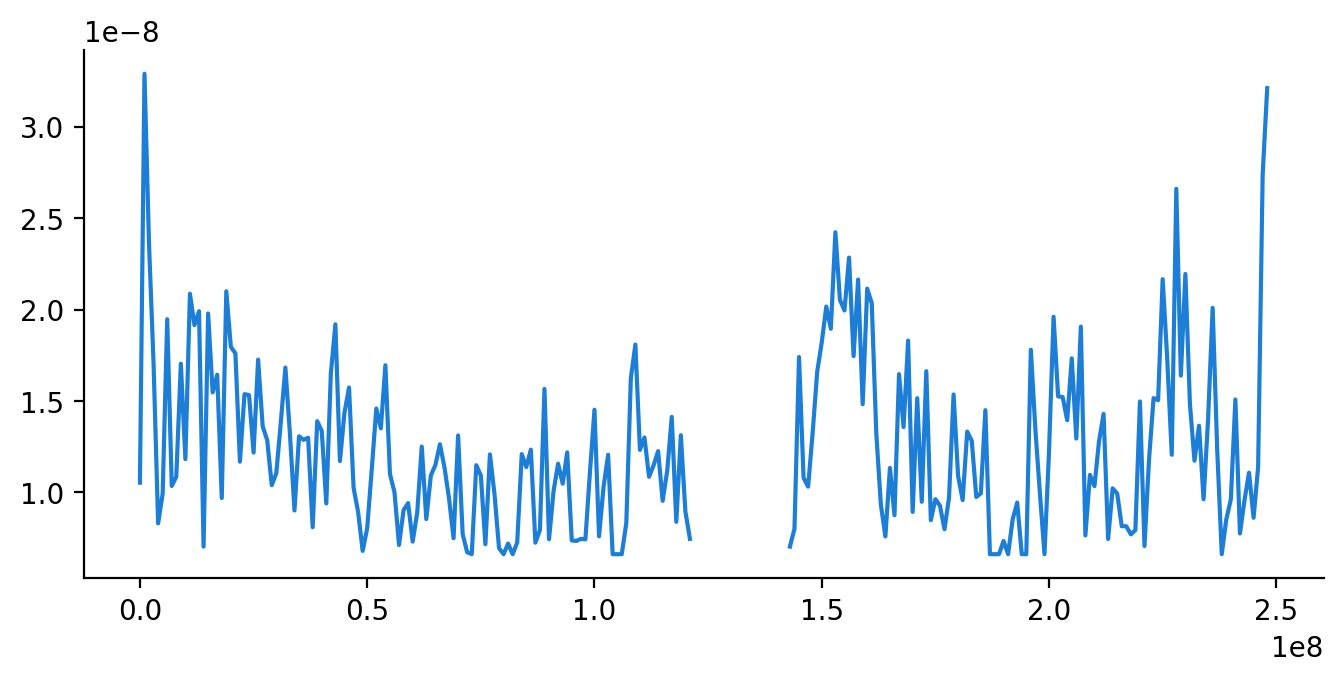

In [454]:

tmp = rd_1Mbp.loc[rd_1Mbp['chrom'] == 'chr1']
tmp2 = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == 'chr1']

plt.plot(tmp['start'], tmp['r'])

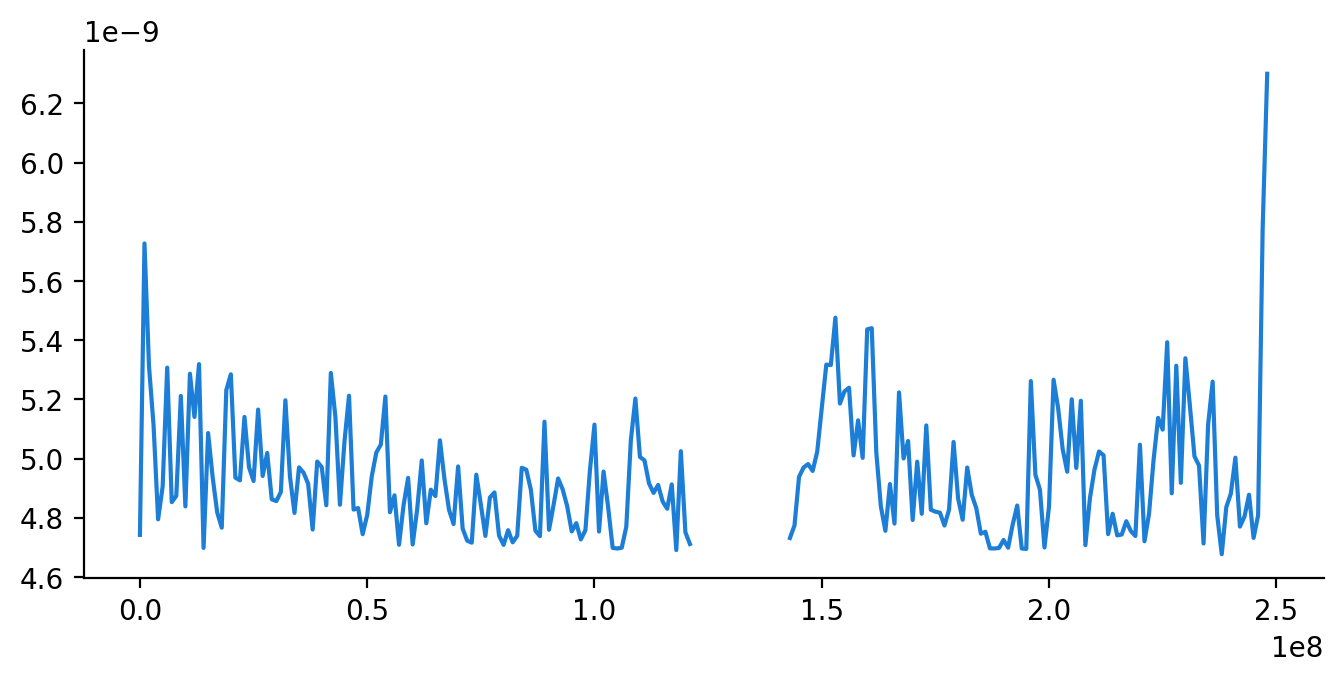

In [455]:
plt.plot(tmp2['start'], tmp2['r'])

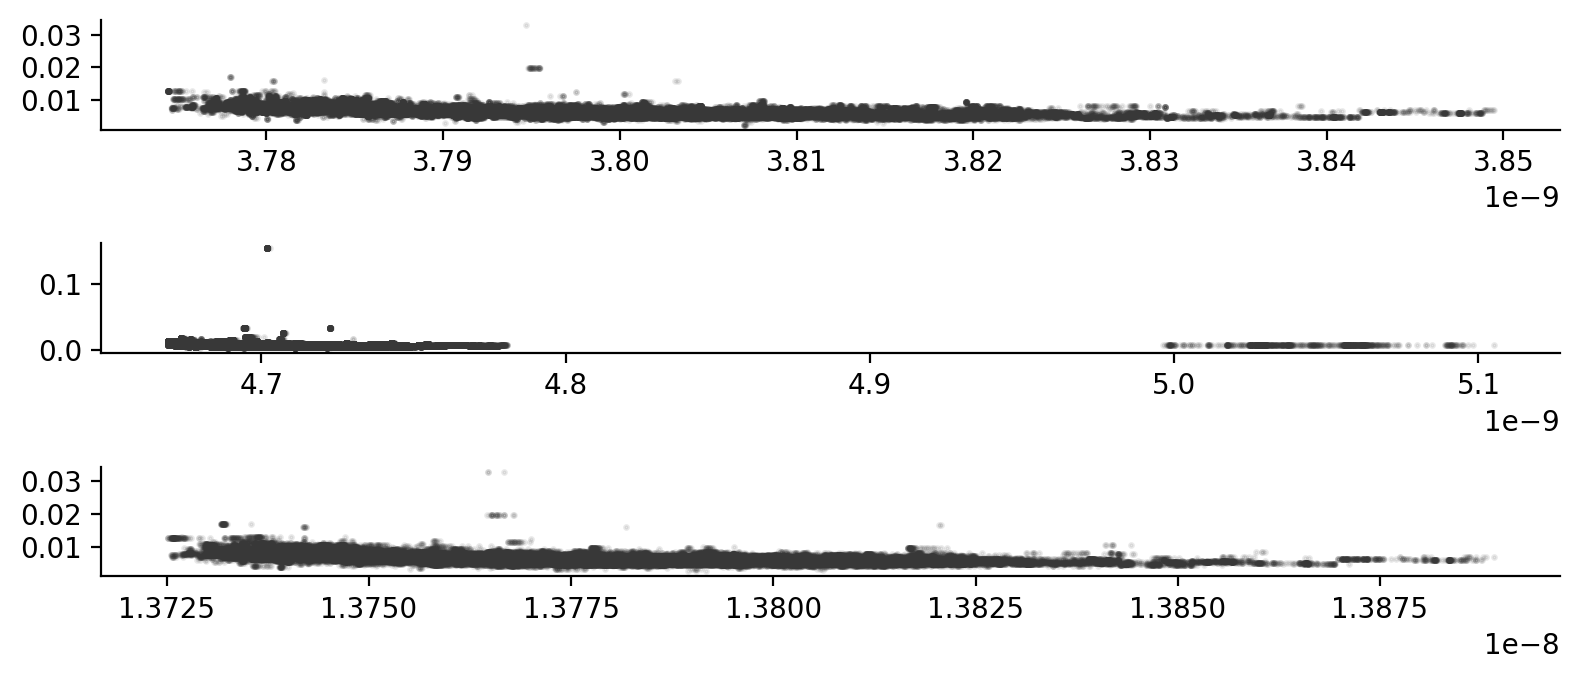

In [671]:
fig, ax = plt.subplots(nrows=3)
ax[0].scatter(dpf2r_cds['r'], dpf2r_cds['branch_length'], c='0.22', s=2, alpha=0.1)
ax[1].scatter(dpf2r_pc['r'], dpf2r_pc['branch_length'], c='0.22', s=2, alpha=0.1)
ax[2].scatter(dpf2r_utr['r'], dpf2r_utr['branch_length'], c='0.22', s=2, alpha=0.1)
plt.tight_layout()

Note the difference between these files:

 - Ratchet to phylofit averages multiple ratchet estimtaes per aligned region. This averages different types of features too. 
 - Phylotfit to ratchet averages the substitution rates by what the predicted ratchet rate is. Note that since the ratchet rate differs a lot by the feature type.
 
 
We can see the phylofit to ratchet substitution rate variation by feature type below, each cluster is one set of features.

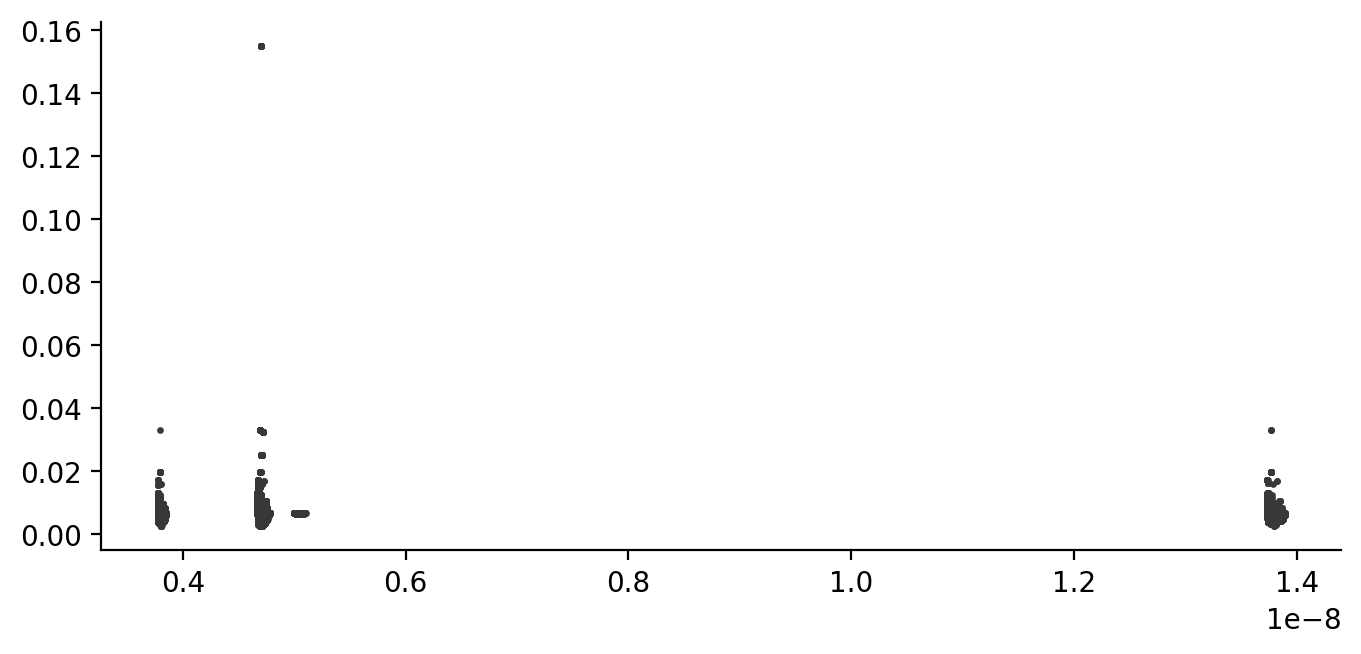

In [484]:
plt.scatter(dpf2r['r'], dpf2r['branch_length'], c='0.22', s=2)

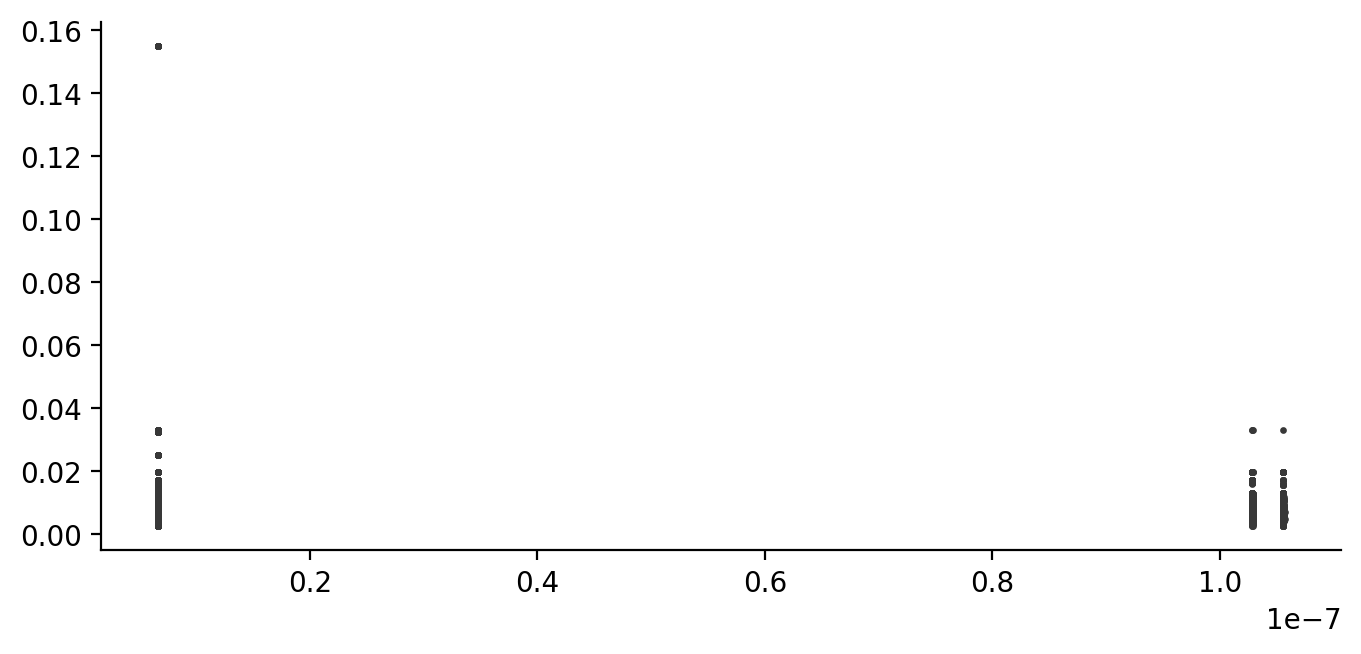

In [40]:
plt.scatter(dpf2r['r'], dpf2r['branch_length'], c='0.22', s=2)

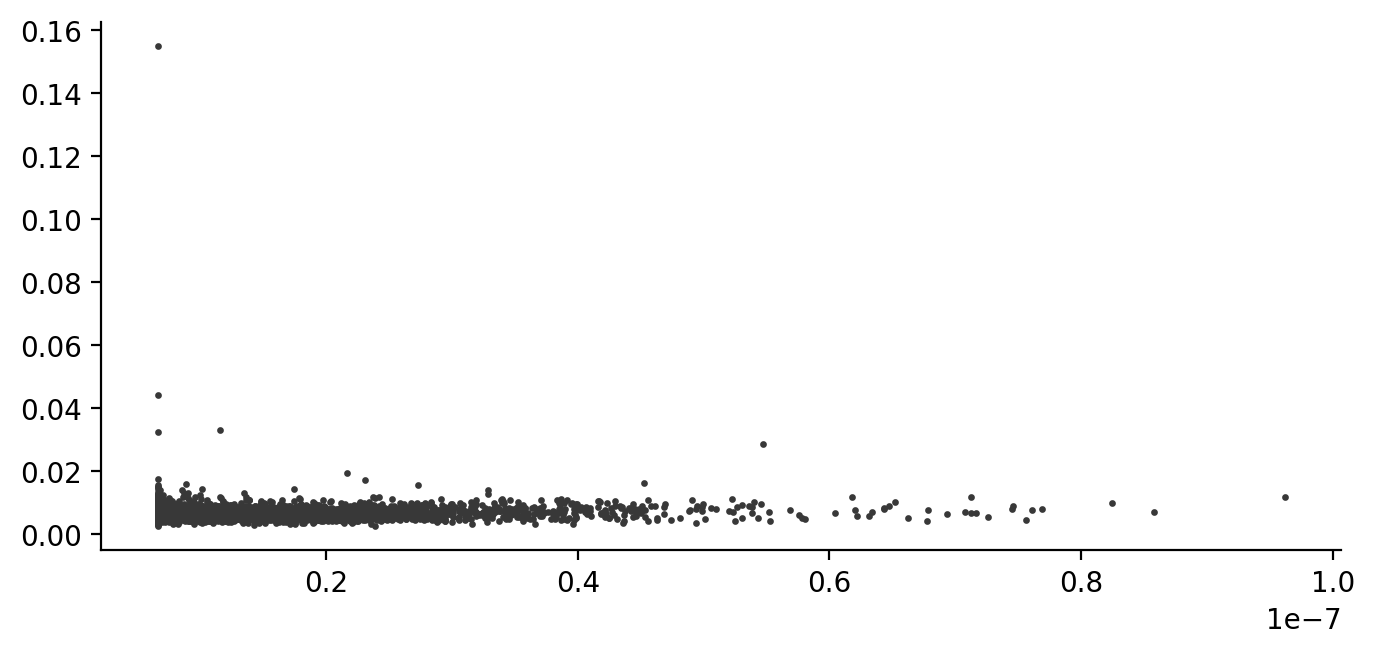

In [173]:
plt.scatter(dr2pf['r'], dr2pf['branch_length'], c='0.22', s=2)

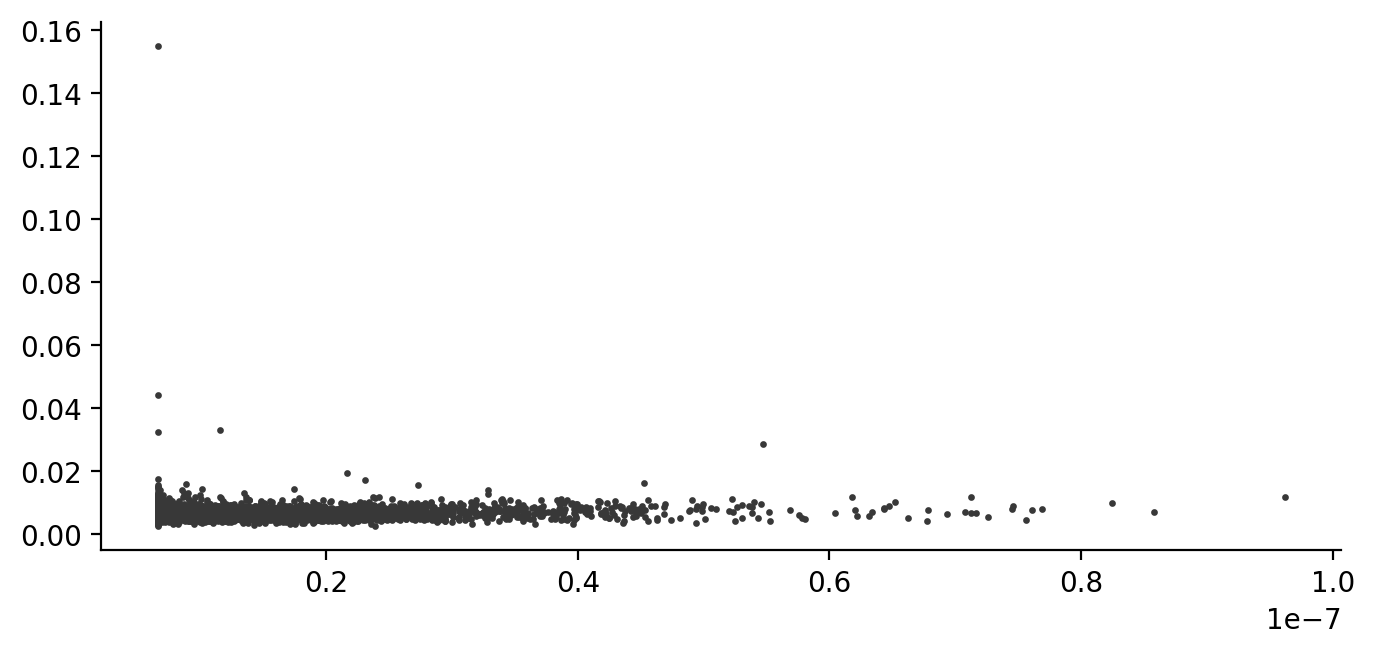

In [41]:
plt.scatter(dr2pf['r'], dr2pf['branch_length'], c='0.22', s=2)

There look to be a few outliers.

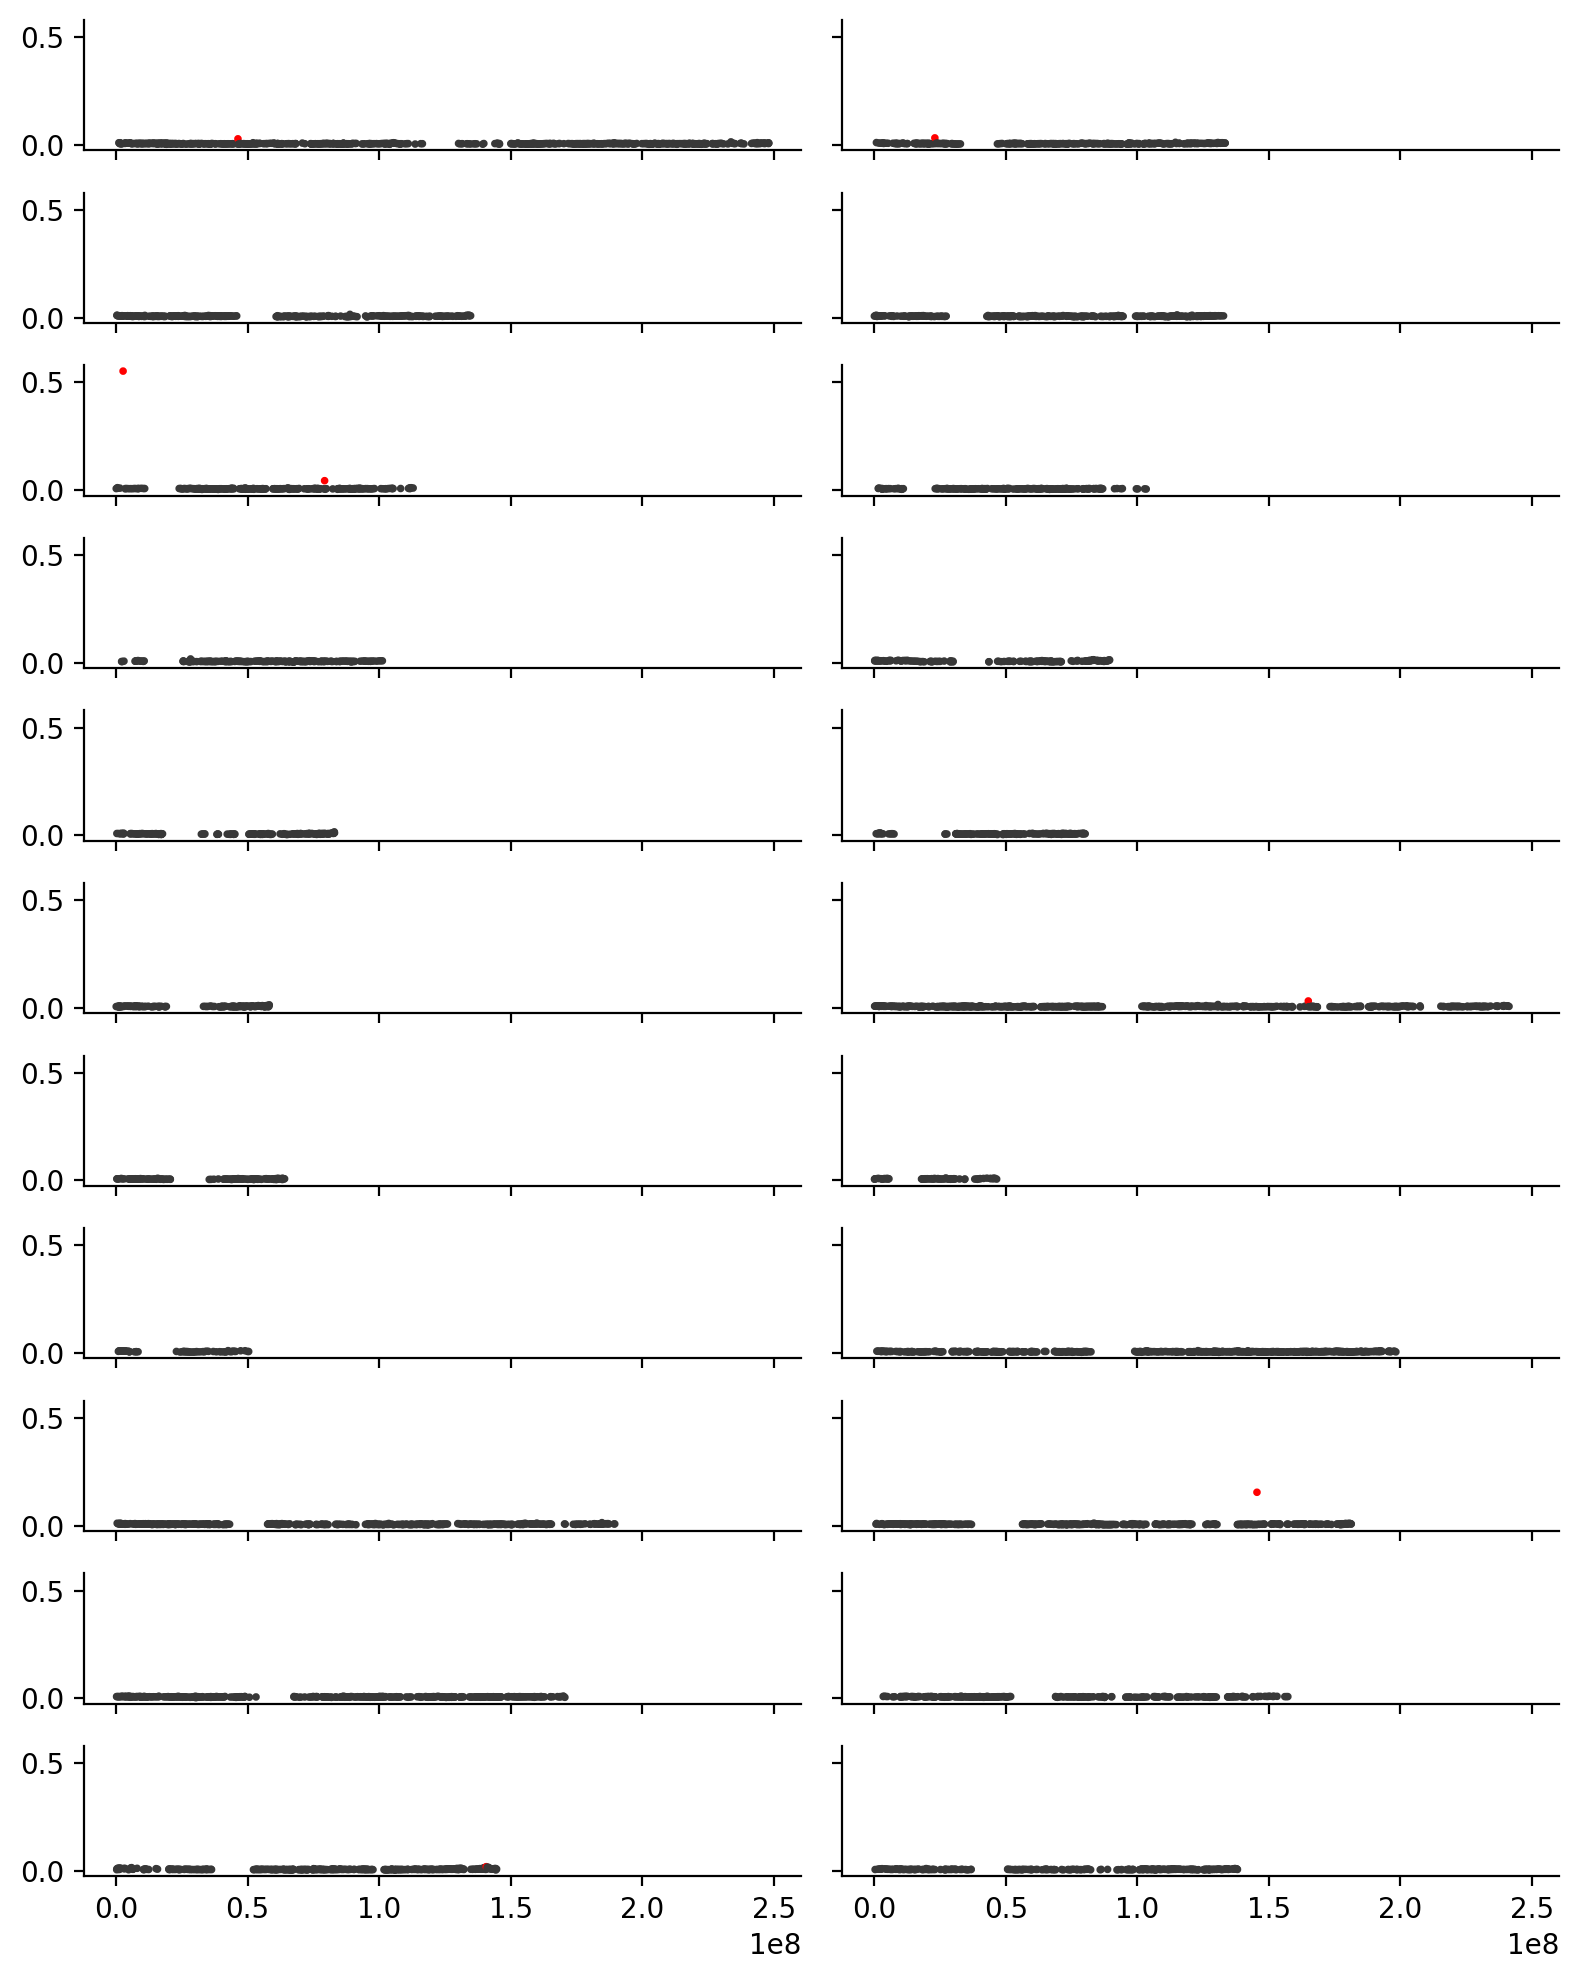

In [174]:
r2pf_thresh = np.nanquantile(dr2pf['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pf['chrom'].unique()):
    dx = dr2pf.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [216]:
dr2pfo = dr2pf.loc[dr2pf['branch_length'] < r2pf_thresh]

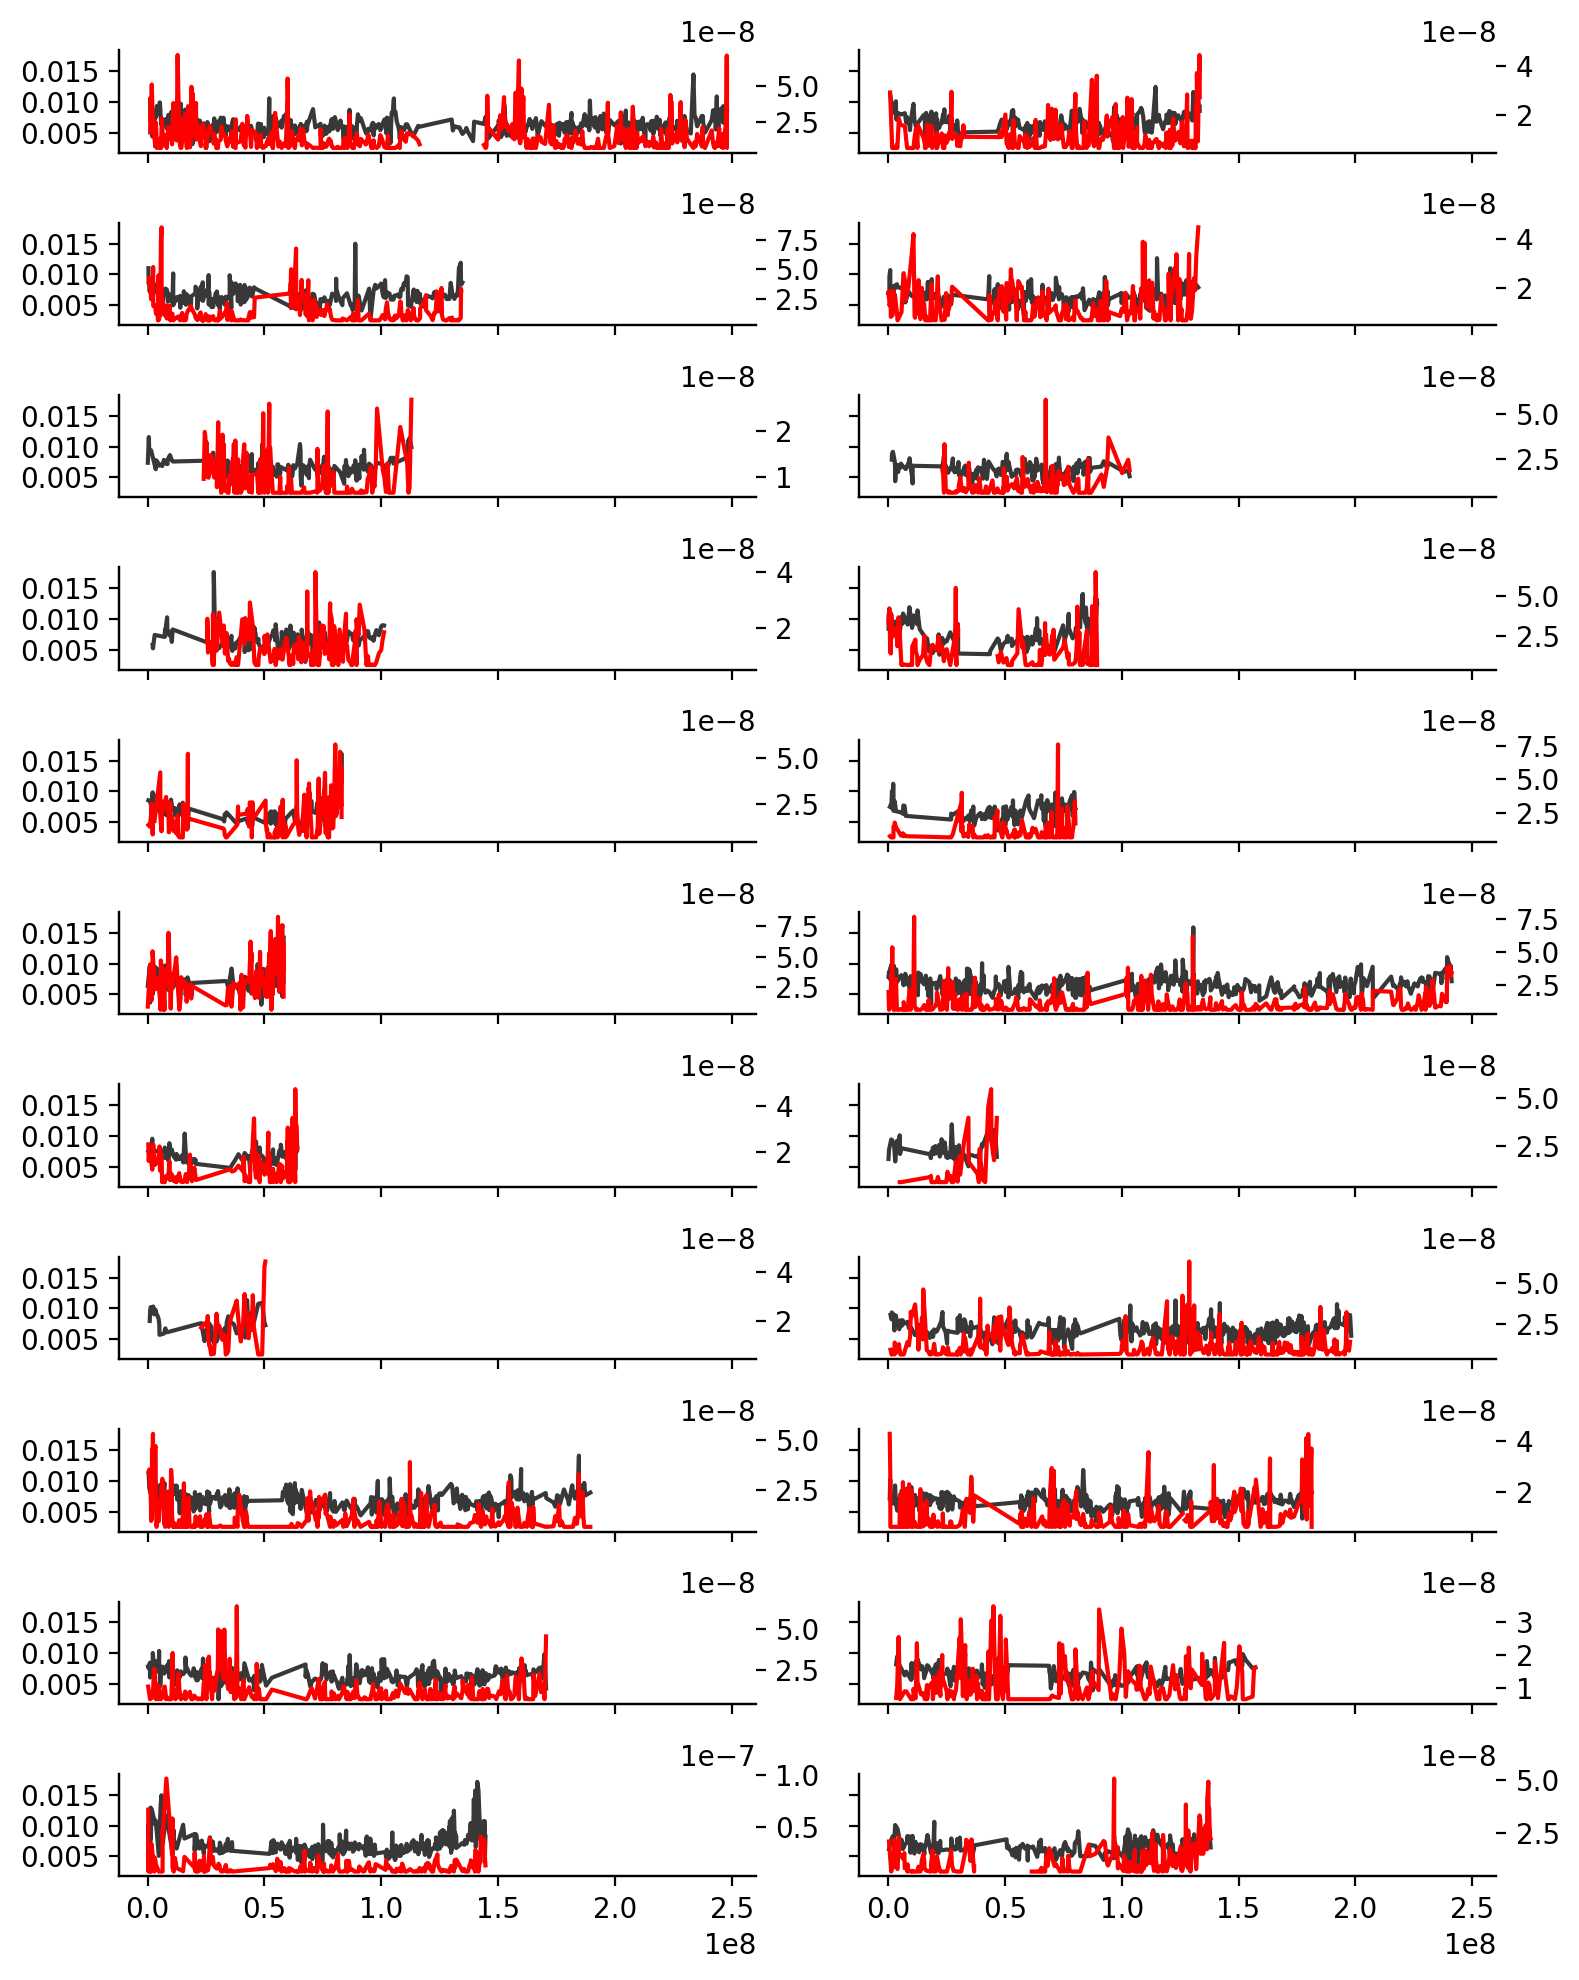

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pfo['chrom'].unique()):
    dx = dr2pfo.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], dx['branch_length'], c='0.22')
    ax2 = fax.twinx()
    ax2.plot(dx['start'], dx['r'], c='r')
plt.tight_layout()

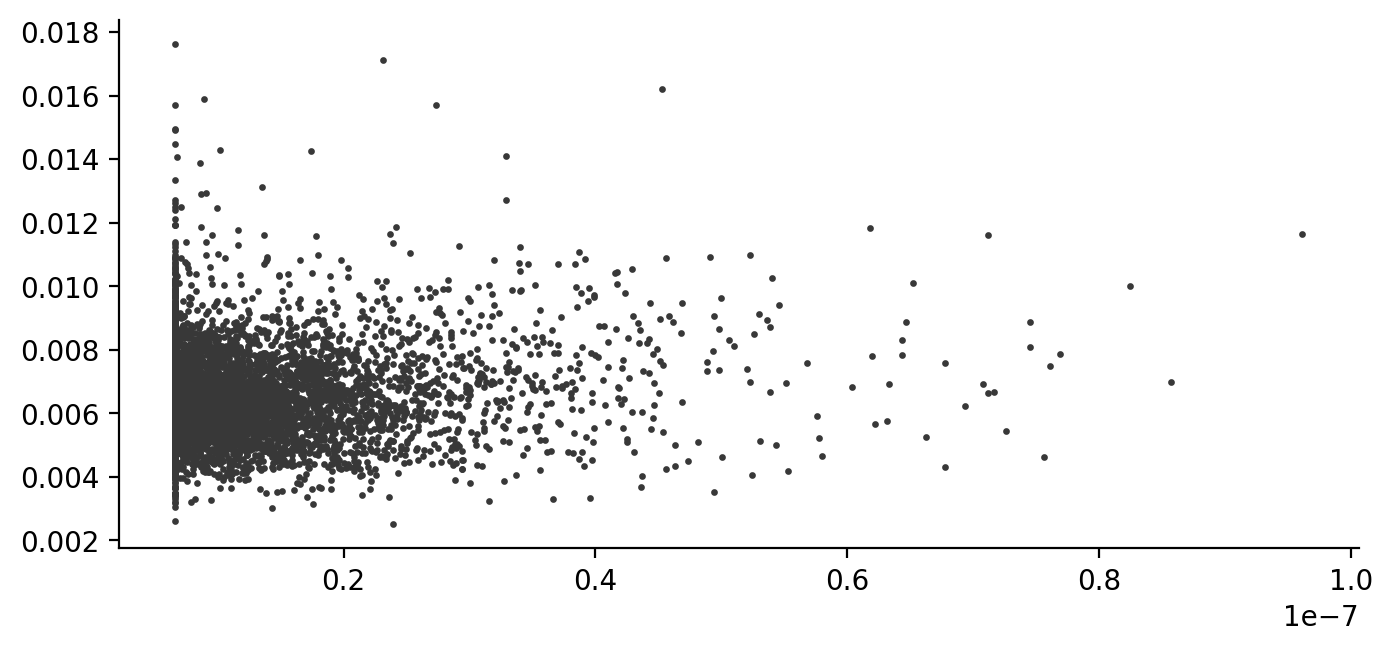

In [175]:
plt.scatter(dr2pfo['r'], dr2pfo['branch_length'], c='0.22', s=2)

## Substitution Non-Parametric and Parametric Models

In [888]:
do.head()

chrom    start      end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1   923923   944575  ENSG00000187634        28     21             8   
1  chr1   944203   959309  ENSG00000188976        31     32             4   
2  chr1   960584   965719  ENSG00000187961        11     28             0   
3  chr1   966482   975865  ENSG00000187583        47     19             0   
7  chr1  1020120  1056118  ENSG00000188157        66     66             5   

   fixed_syn      dnDs  total_fixed  ...      dNdS             r  r_nbases  \
0          4  2.000000           12  ...  2.000000  2.502833e-08      4658   
1          8  0.500000           12  ...  0.500000  4.107783e-08      2950   
2          8  0.000000            8  ...  0.000000  4.222435e-08      2776   
3          3  0.000000            3  ...  0.000000  3.766140e-08      3800   
7         13  0.384615           18  ...  0.384615  2.485167e-08      9231   

           r_rs  r_rs_nbases  branch_length  bl_nbases  width   midpoint  \
0  5.035896e-09         4658       0.009005    96703.0  20652   934249.0   
1  4.688058e-09         2950       0.009129    55542.0  15106   951756.0   
2  5.717414e-09         2776       0.009129    55542.0   5135   963151.5   
3  4.771755e-09         3800       0.009129    55542.0   9383   971173.5   
7  4.728873e-09         9231       0.008279   492757.0  35998  1038119.0   

          B  
0  0.819417  
1  0.819092  
2  0.818885  
3  0.818742  
7  0.817613  

[5 rows x 27 columns]

In [1012]:
x, x_rs, nonsyn_prop, syn_prop, branch_length = do['r'], do['r_rs'], do['nonsyn_prop'], do['syn_prop'], do['branch_length']
b = do['B']

#keep = syn_prop > 0
#x_rs, syn_prop = x_rs[keep], syn_prop[keep]

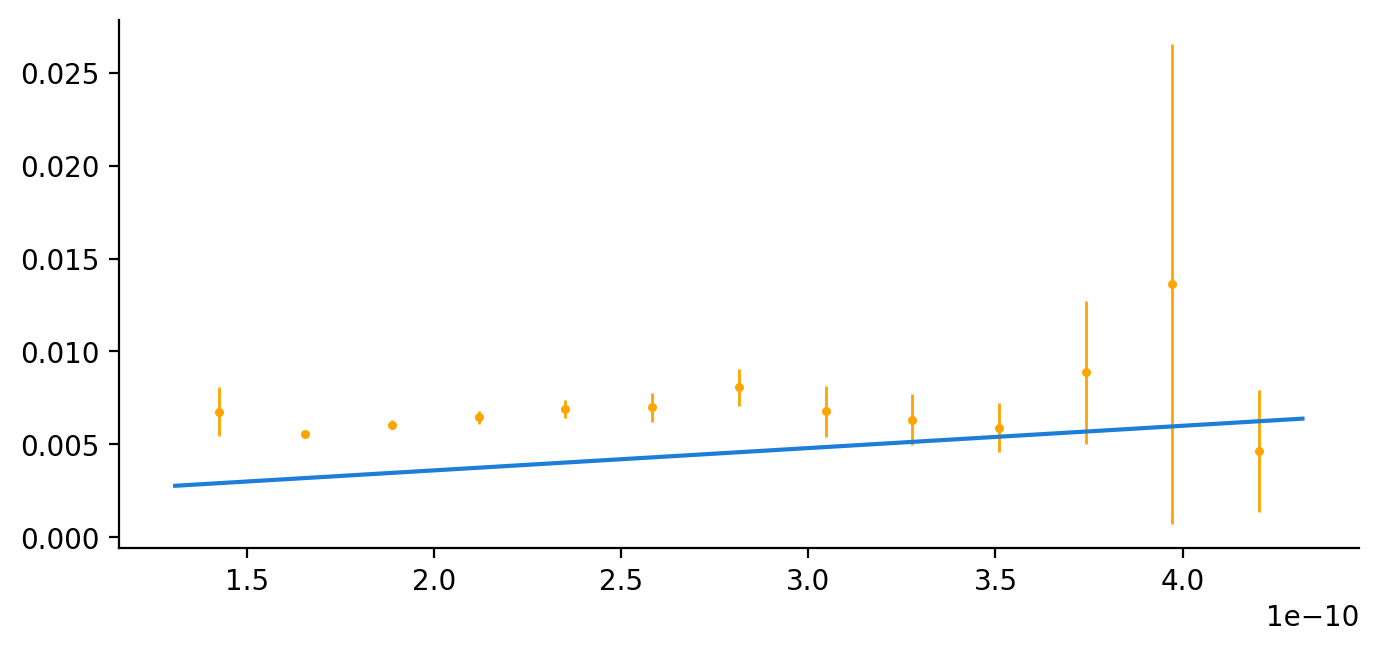

In [1032]:
gen = 30

ds = binned_summaries(x_rs/gen, syn_prop, nbins, method='interval')
#fig, ax = binned_means_plot(ds, c='orange', linewidth=1, label='syn rs', min_n=0, stat='median')
fig, ax = binned_means_plot(ds, c='orange', linewidth=1, label='syn rs', min_n=0, stat='mean')

xx = np.linspace(x_rs.min()/gen, x_rs.max()/gen, 100)
#ax.plot(xx, (xx + 1e-9)*6.5e6 )
ax.plot(xx, (xx + 1e-10)*12e6 )

In [1007]:
2*do['syn_prop'].mean()

0.012110842561572948

In [933]:
nbins = 10

dbns = binned_summaries(b, nonsyn_prop, nbins, method='interval')
dbs = binned_summaries(b, syn_prop, nbins, method='interval')

figax = binned_means_plot(dbns, c='r', linewidth=1, label='non-syn', min_n=30)
figax = binned_means_plot(dbs, c='orange', linewidth=1, label='syn rs', min_n=30, figax=figax)

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [911]:
corr(x, syn_prop), corr(x, nonsyn_prop), corr(x, branch_length)

(((0.09590618588083524, 1.7388124537236895e-28),
  SpearmanrResult(correlation=0.07086397341840923, pvalue=3.0461850578095606e-16)),
 ((0.1873594097757387, 4.3963046907291895e-105),
  SpearmanrResult(correlation=0.16808521281583122, pvalue=1.1692194973842668e-84)),
 ((0.181364747816664, 1.7686196894462675e-98),
  SpearmanrResult(correlation=0.14061568364520072, pvalue=1.479250719495962e-59)))

In [912]:
corr(b, syn_prop), corr(b, nonsyn_prop), corr(b, branch_length)

(((0.12594096867737123, 4.879479524414708e-48),
  SpearmanrResult(correlation=0.13929273343782436, pvalue=1.8280679787683005e-58)),
 ((0.08737412616112054, 6.641230382394777e-24),
  SpearmanrResult(correlation=0.0952054150777505, pvalue=4.292193651223862e-28)),
 ((0.6499111486442355, 0.0),
  SpearmanrResult(correlation=0.7013488636770269, pvalue=0.0)))

In [913]:
corr(x_rs, syn_prop), corr(x_rs, nonsyn_prop), corr(x_rs, branch_length)

(((0.0756355174063009, 2.7036959379162143e-18),
  SpearmanrResult(correlation=0.027405989175552724, pvalue=0.0015947469418133948)),
 ((0.1278738391906607, 1.760626762715462e-49),
  SpearmanrResult(correlation=0.0974348131816431, pvalue=2.3670998168116905e-29)),
 ((0.11741735583539943, 6.065501263449402e-42),
  SpearmanrResult(correlation=0.07879901438285654, pvalue=9.976821300337717e-20)))

In [914]:
np.mean((x_rs - branch_length)**2), np.mean((b - branch_length)**2)

(3.993858065936572e-05, 0.5065399703235617)

[]

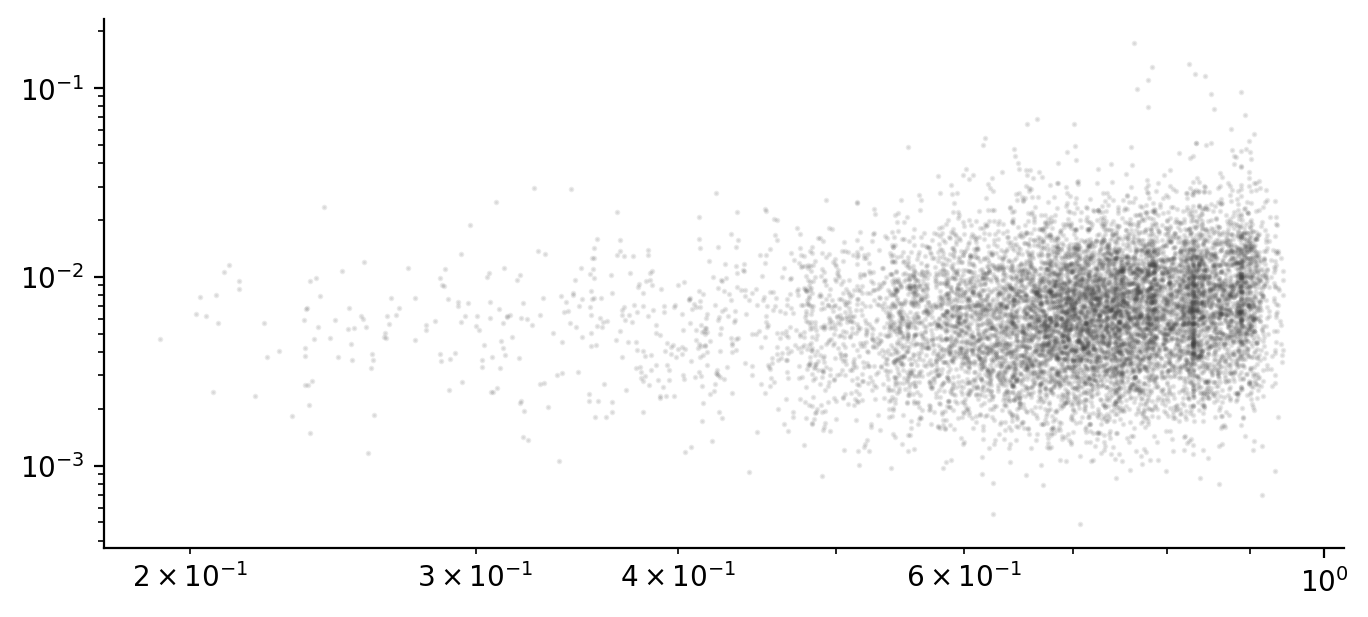

In [926]:
plt.scatter(b, syn_prop, c='0.22', s=1, alpha=0.1)

plt.loglog()

In [929]:
do.loc[syn_prop == 0]

chrom      start        end          gene_id  n_nonsyn  n_syn  \
30     chr1    1541673    1574863  ENSG00000160075         0      1   
47     chr1    2403964    2413797  ENSG00000157911        10      6   
61     chr1    3746460    3771645  ENSG00000162592        33     18   
62     chr1    3772749    3775982  ENSG00000235169         1      0   
69     chr1    5990927    6101193  ENSG00000069424         3      9   
...     ...        ...        ...              ...       ...    ...   
16226  chr9  133152948  133163933  ENSG00000148288        25      2   
16230  chr9  133577081  133609389  ENSG00000196990         0      3   
16255  chr9  136196250  136205128  ENSG00000107187         3      6   
16278  chr9  136945185  136946975  ENSG00000176919        11      7   
16285  chr9  137039463  137046179  ENSG00000107281        10      9   

       fixed_nonsyn  fixed_syn  dnDs  total_fixed  ...            N  \
30                1          0   inf            1  ...   460.000000   
47                3          0   inf            3  ...   724.333333   
61                4          0   inf            4  ...  1540.000000   
62                0          0   NaN            0  ...   181.333333   
69                2          0   inf            2  ...   954.333333   
...             ...        ...   ...          ...  ...          ...   
16226             4          0   inf            4  ...   797.666667   
16230             0          0   NaN            0  ...   378.666667   
16255             0          0   NaN            0  ...   901.666667   
16278             1          0   inf            1  ...   451.000000   
16285             4          0   inf            4  ...   707.666667   

                  r  r_nbases          r_rs  r_rs_nbases  branch_length  \
30     4.495916e-08      5548  6.953798e-09         5548       0.010481   
47     7.007702e-08      4408  7.997543e-09         4408       0.008767   
61     4.353340e-08      2530  7.179278e-09         2530       0.007486   
62     7.451684e-08       994  9.026753e-09          994       0.007486   
69     2.518382e-08     14296  5.913706e-09        14296       0.006998   
...             ...       ...           ...          ...            ...   
16226  6.296102e-08      3495  6.845369e-09         3495       0.007063   
16230  1.876107e-08      3313  5.396241e-09         3313       0.007358   
16255  4.196825e-08      3269  5.737388e-09         3269       0.007912   
16278  6.631971e-08       935  6.901890e-09          935       0.007637   
16285  5.381670e-08      2613  6.311662e-09         2613       0.007637   

       bl_nbases   width     midpoint         B  
30      178850.0   33190    1558268.0  0.813051  
47      514378.0    9833    2408880.5  0.824639  
61      368476.0   25185    3759052.5  0.890758  
62      368476.0    3233    3774365.5  0.890974  
69     2073206.0  110266    6046060.0  0.811434  
...          ...     ...          ...       ...  
16226  1000000.0   10985  133158440.5  0.849346  
16230    96944.0   32308  133593235.0  0.872813  
16255  1000000.0    8878  136200689.0  0.875404  
16278   692085.0    1790  136946080.0  0.833799  
16285   692085.0    6716  137042821.0  0.829807  

[3046 rows x 29 columns]

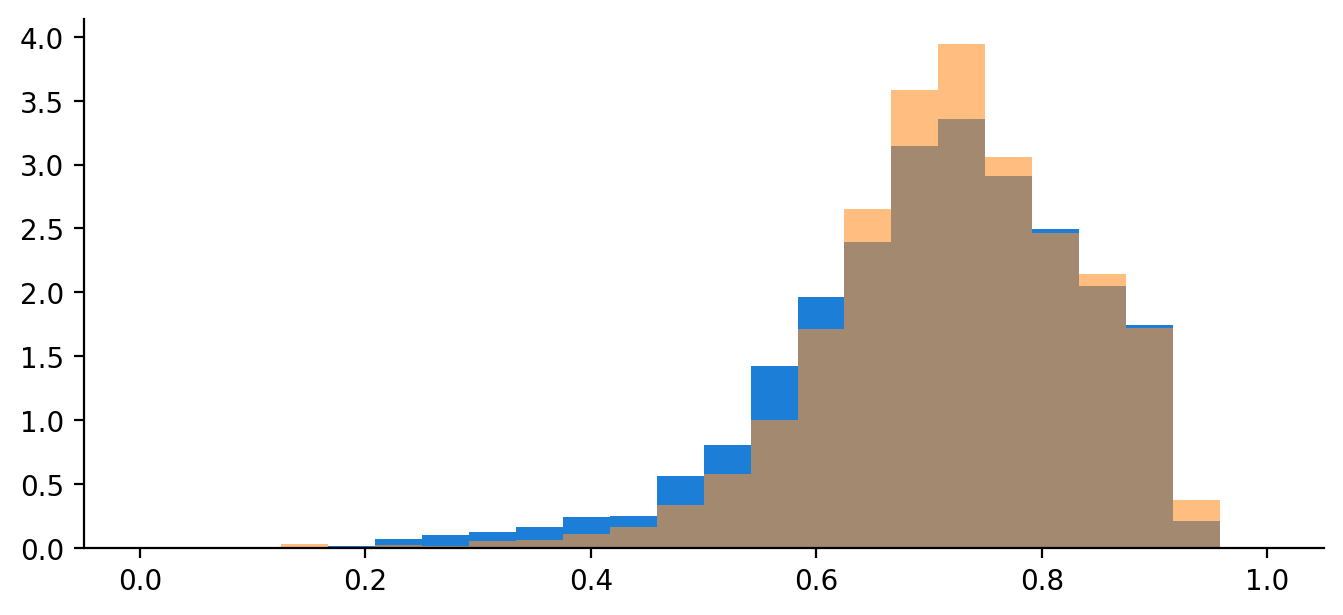

In [917]:

bn = np.linspace(0, 1, 25)
plt.hist(do['B'], bn, density=True)
_ = plt.hist(fit.predict(B=True), bn, density=True, alpha=0.6)

In [934]:
nbins = 14

dns = binned_summaries(x, nonsyn_prop, nbins, method='quantile')
ds = binned_summaries(x, syn_prop, nbins, method='quantile')

dns_rs = binned_summaries(x_rs, nonsyn_prop, nbins, method='quantile')
ds_rs = binned_summaries(x_rs, syn_prop, nbins, method='quantile')

dns_rs = binned_summaries(x_rs, nonsyn_prop, nbins, method='interval')
ds_rs = binned_summaries(x_rs, syn_prop, nbins, method='interval')

dbl = binned_summaries(x, branch_length, nbins)
dbl_rs = binned_summaries(x_rs, branch_length, nbins)

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

Text(0.5, 0, 'predicted substitution rate')

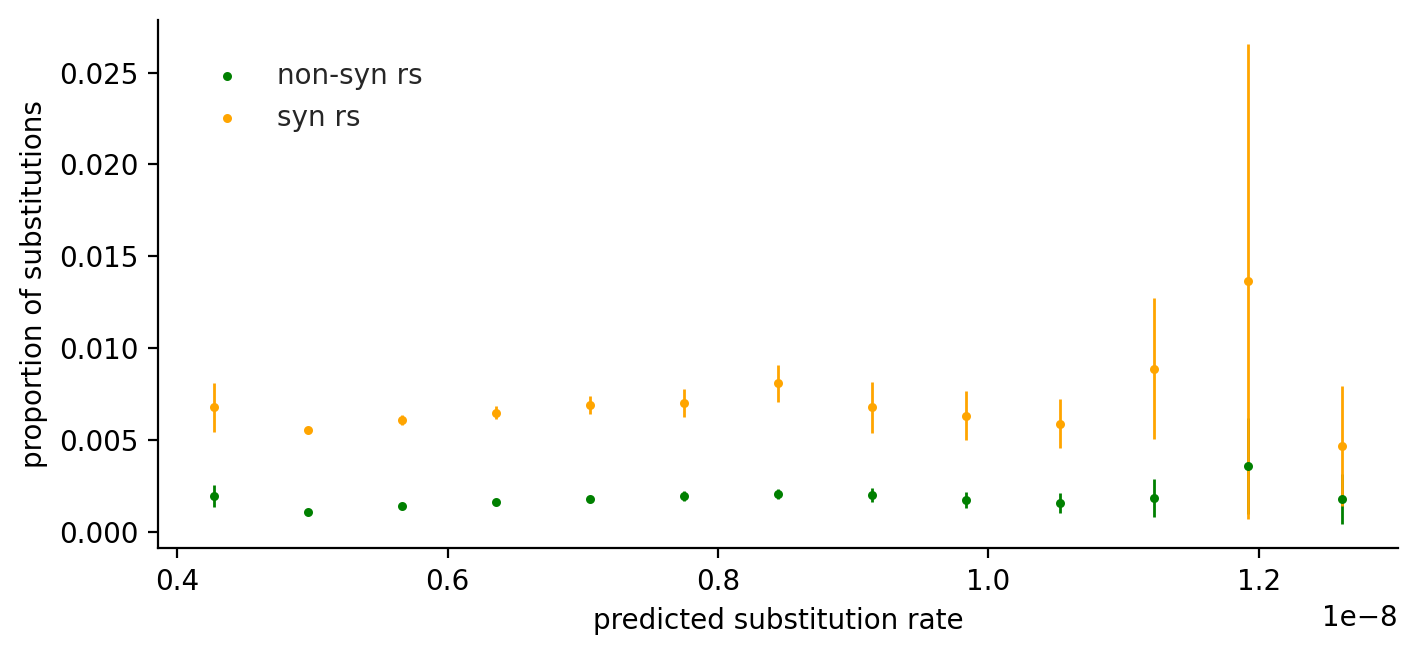

In [935]:
figax = binned_means_plot(dns_rs, c='g', linewidth=1, label='non-syn rs', min_n=0)
fig, ax = binned_means_plot(ds_rs, c='orange', linewidth=1, label='syn rs', min_n=0, figax=figax)
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')

In [921]:
0.5e-8 / 30 * 6.5e6

0.0010833333333333333

(5.029753849013461e-09, 5e-08)

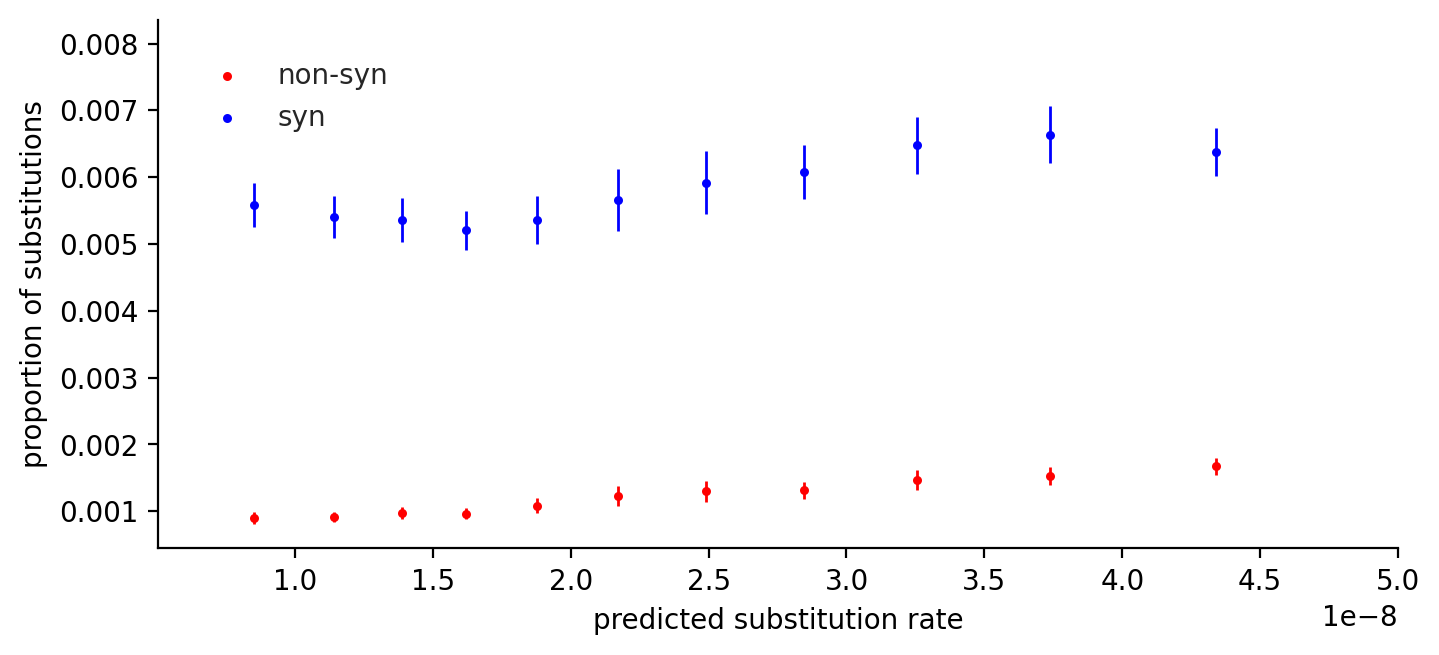

In [922]:
figax = binned_means_plot(dns, c='r', linewidth=1, label='non-syn', min_n=30)
fig, ax = binned_means_plot(ds, figax=figax, c='b', linewidth=1, label='syn', min_n=3)
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')
ax.set_xlim(ax.get_xlim()[0], 5e-8)

(-0.0001, 0.03)

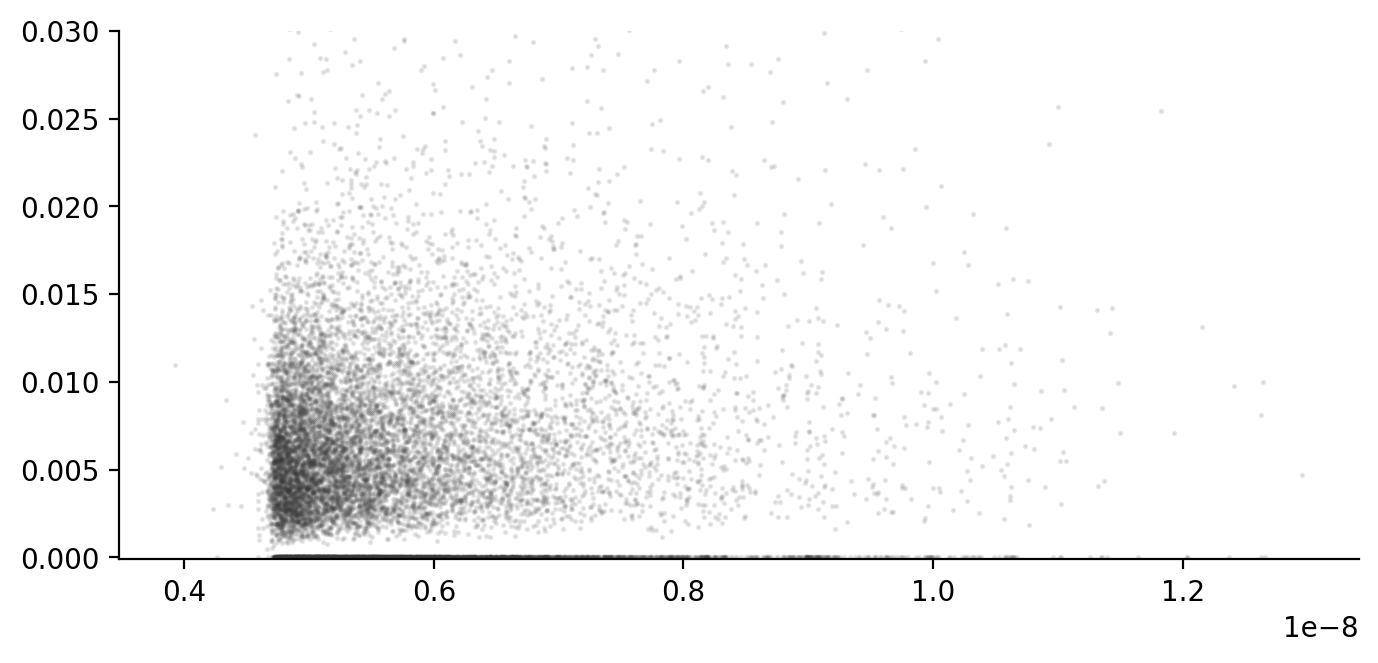

In [1042]:
plt.scatter(x_rs, syn_prop, c='0.22', s=1, alpha=0.1)
plt.ylim(-1e-4, 0.03)

### Cross Validation of Bin Width

In [335]:
x, branch_length = dr2pfo['r'].values, dr2pfo['branch_length'].values
keep = np.isfinite(x) & np.isfinite(branch_length)
x, branch_length = x[keep], branch_length[keep]

In [336]:
branch_length.shape, x.shape

((6147,), (6147,))

In [337]:
#x, syn_prop, nonsyn_prop, branch_length = (do['r'].values, do['syn_prop'].values,
#                                           do['nonsyn_prop'].values, do['branch_length'].values)

# nbins = 50
# dns = binned_summaries(x, nonsyn_prop, nbins)
# ds = binned_summaries(x, syn_prop, nbins)
# dbl = binned_summaries(x, branch_length, nbins)

In [338]:
import warnings
from sklearn.model_selection import KFold, LeaveOneOut
from collections import defaultdict

warnings.filterwarnings(action='once')


bin_range = (x.min(), 1.001*x.max())


kf = KFold(n_splits=100)
loo = LeaveOneOut()

mses = defaultdict(list)

cv_mses = []
nbs = []

def safe_mean(x):
    if not len(x) or np.all(~np.isfinite(x)):
        return np.nan
    return np.nanmean(x)

for nb in np.arange(5, 200, 2).astype(int):
    for train, test in kf.split(x):
        bins = cutbins(x[train], nb, xrange=bin_range)
        bin_means = binned_statistic(x[train], branch_length[train], statistic=safe_mean, bins=bins)
        bin_ns = binned_statistic(x[train], branch_length[train], statistic=lambda x: np.sum(np.isfinite(x)), bins=bins)
        idx = np.digitize(x[test], bins)
        se = (bin_means.statistic[idx-1] - branch_length[test])**2
        weights = bin_ns.statistic[idx-1]
        keep = np.isfinite(se)
        mse = np.average(se[keep], weights=weights[keep])
        mses[nb].append(mse)
        cv_mses.append(mse)
        nbs.append(nb)
        

Text(0.5, 0, 'number of bins')

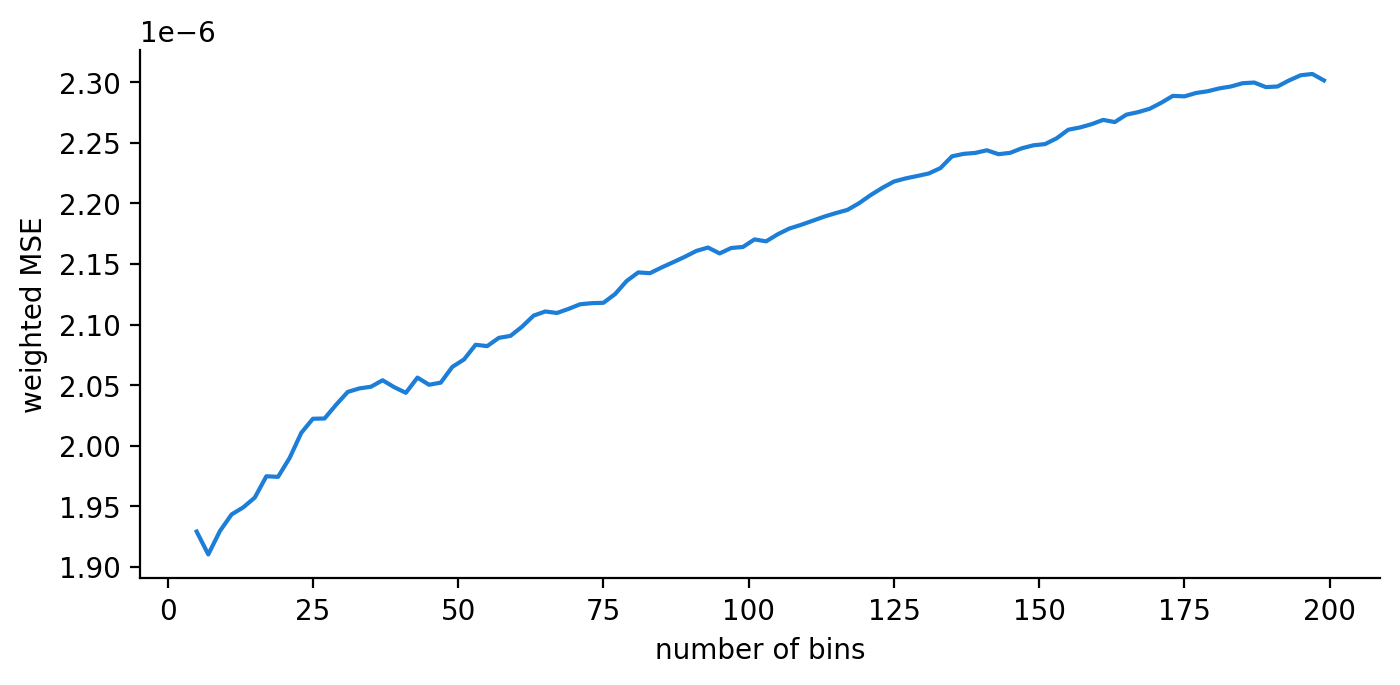

In [339]:
msedat = {nb: np.mean(v) for nb, v in mses.items()}

plt.plot(msedat.keys(), msedat.values())
plt.ylabel("weighted MSE")
plt.xlabel("number of bins")

In [340]:
best_nbin = list(msedat.keys())[np.argmin(list(msedat.values()))]
best_nbin

7

In [1035]:
def JC69(dist):
    # distance
    return 0.75 - 0.75*np.exp(-4/3 * dist)

def JC69_parametric(lambda_d, beta, T, lambda_b):
    return JC69(T*(lambda_b + beta*lambda_d))

def fit_JC69(predicted, subrate, gen_time=30, p0=(1, 1e6, 0)):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    fit, cv = curve_fit(JC69_parametric, lambda_d, y, p0=p0)
    pred = JC69_parametric(lambda_d, fit[0], fit[1], fit[2])
    return lambda_d, y, (fit, np.mean((pred - y)**2))

xx, yy, fit = fit_JC69(x_rs, syn_prop)
xx_nonsyn, yy_nonsyn, fit_nonsyn = fit_JC69(x_rs, nonsyn_prop)

In [1036]:
fit_JC69(x_rs, syn_prop)[2], fit_JC69(x_rs, syn_prop, p0=(1, 6e6, 0))[2]

((array([2.96523487e+00, 4.50124478e+06, 7.76861860e-10]),
  4.437748997096209e-05),
 (array([1.23919830e+00, 1.07796705e+07, 3.24195363e-10]),
  4.43774901400623e-05))

In [562]:
fit_JC69(x_rs, syn_prop)[2], fit_JC69(x_rs, syn_prop, p0=(1, 6e6, 0))[2]

((array([1.45921446e+00, 2.66201467e+06, 2.48127587e-10]),
  2.3971559108553394e-06),
 (array([7.24876930e-01, 5.35879279e+06, 1.23259326e-10]),
  2.397155910443899e-06))

In [563]:
fit_JC69(x_rs, nonsyn_prop)[2], fit_JC69(x_rs, nonsyn_prop, p0=(1, 6e6, 0))[2]

((array([ 2.37615409e+00,  2.67690819e+06, -5.71231679e-11]),
  2.9080884332781152e-06),
 (array([ 1.08832205e+00,  5.84459021e+06, -2.61611670e-11]),
  2.9080884320319e-06))

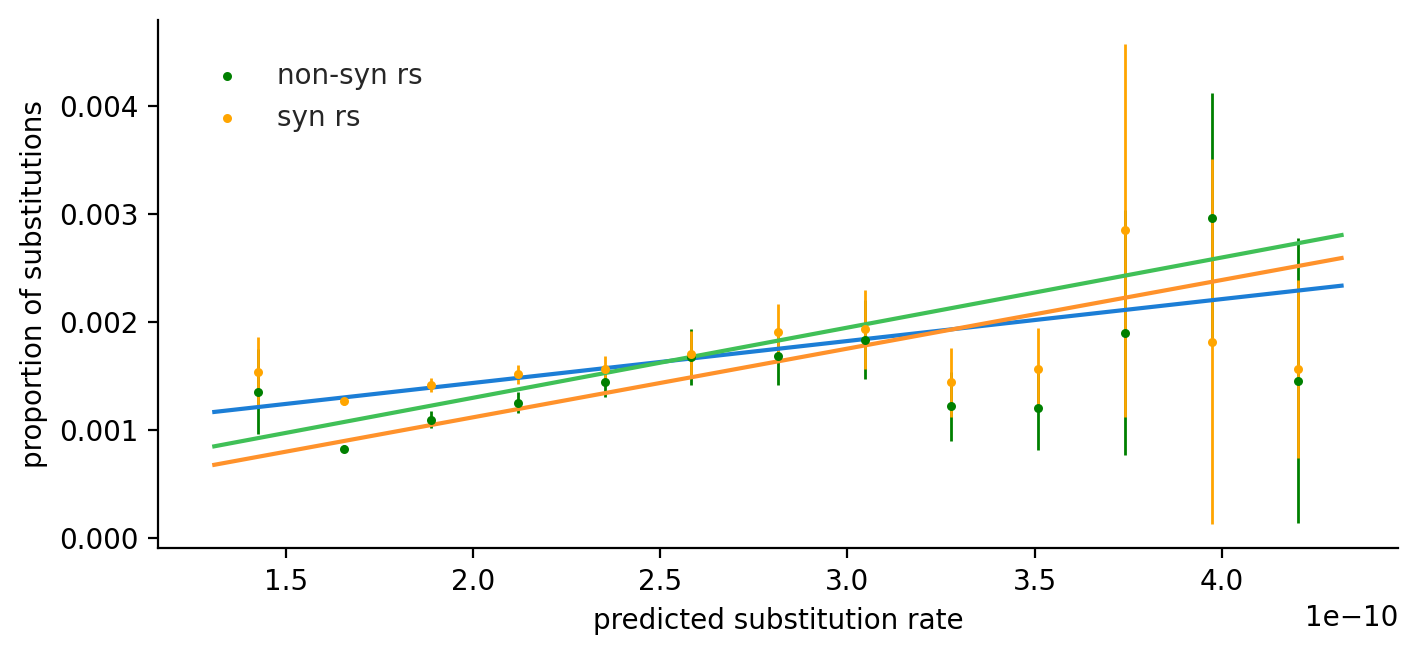

In [612]:
figax = binned_means_plot(dns_rs, c='g', gen=30, linewidth=1, label='non-syn rs', min_n=0)
figax = binned_means_plot(ds_rs, c='orange', gen=30, linewidth=1, label='syn rs', min_n=0, figax=figax)
#figax = binned_means_plot(dbl_rs, c='purple', gen=30, linewidth=1, label='branch length rs', min_n=0, figax=figax)
fig, ax = figax
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')


rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit_nonsyn[0]), label='fit')
ax.plot(rate_grid, JC69_parametric(rate_grid, 1, 6.5e6, 0))

In [623]:
from sklearn.utils.validation import check_X_y

def gaussian_kernel(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)

class KernelRegression(object):
    def __init__(self, h=1, kernel=gaussian_kernel):
        self.h = h
        self.kernel = kernel
        
    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=False)
        self.X = X
        self.y = y
        return self
    
    def predict(self, X):
        K = self.kernel(np.subtract.outer(X, self.X) / self.h)
        Ky = K * self.y
        return Ky.sum(axis=1) / K.sum(axis=1)
    
    def get_params(self, deep=False):
        return {'h': self.h}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    def score(self, y):
        return np.mean((self.predict(y) - y)**2)



Text(0.5, 0, 'predicted substitution rate')

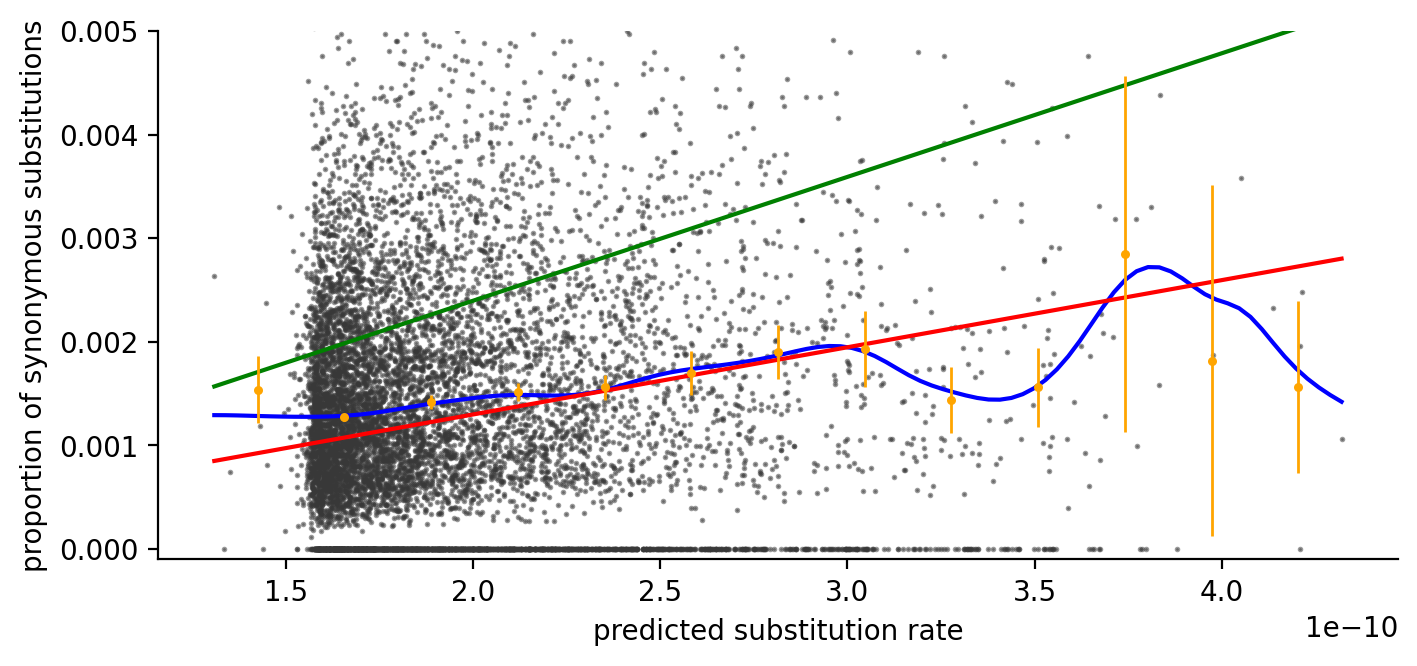

In [653]:
fig, ax = plt.subplots()

xval = x_rs/gen
rate_grid = np.linspace(xval.min(), xval.max(), 100)
ax.plot(rate_grid, KernelRegression(h=1e-11).fit(xval, syn_prop).predict(rate_grid), c='b')
ax.scatter(xval, syn_prop, s=1, c='0.22', alpha=0.5)
ax.plot(rate_grid, JC69_parametric(rate_grid, 1, 6.5e6, 0), c='r')
ax.plot(rate_grid, JC69_parametric(rate_grid, 1, 12e6, 0), c='g')

ax.set_ylim(-1e-4, 0.005)
binned_means_plot(ds_rs, c='orange', gen=30, linewidth=1, label='syn rs', min_n=0, figax=(fig, ax))
ax.set_ylabel('proportion of synonymous substitutions')
ax.set_xlabel('predicted substitution rate')

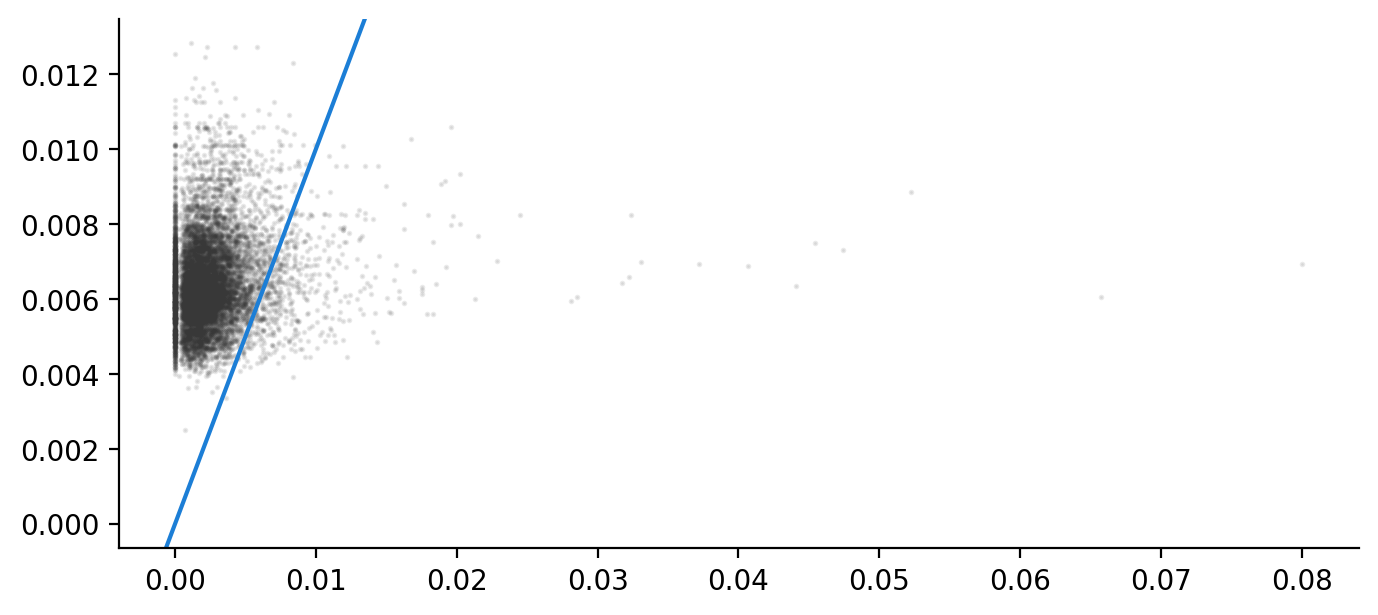

In [658]:
plt.scatter(do['total_prop'], do['branch_length'], c='0.22', s=1, alpha=0.1)
plt.axline((0, 0), slope=1)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0, 'predicted substitution rate')

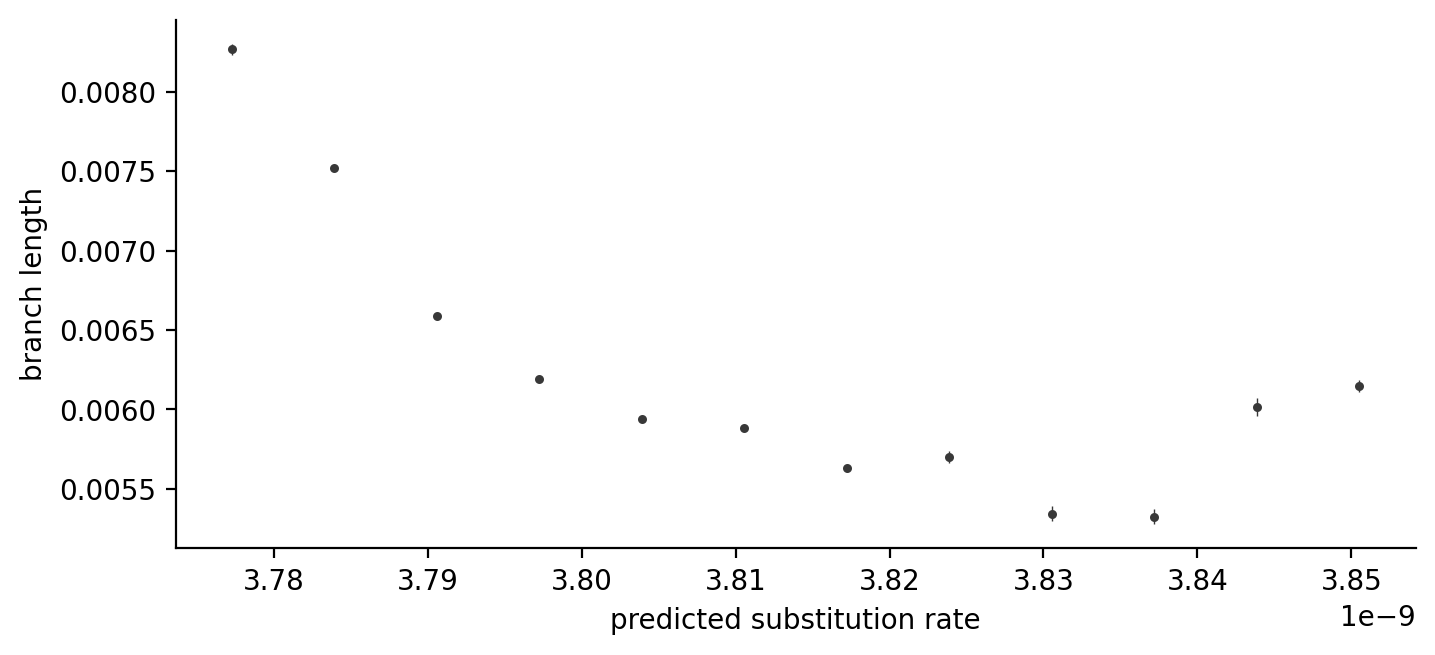

In [668]:
pf2r_bins = binned_summaries(dpf2r_cds['r'], dpf2r_cds['branch_length'], nbins)
fig, ax = binned_means_plot(pf2r_bins)

ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

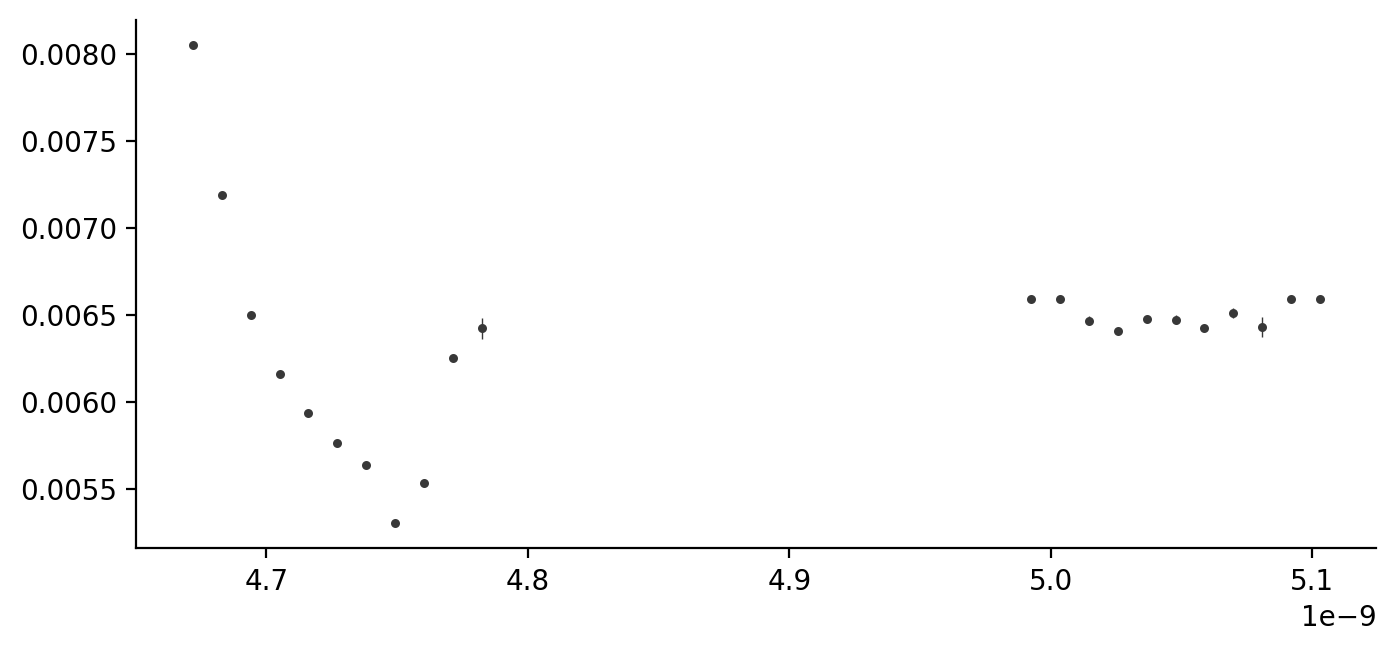

In [619]:
pf2r_bins = binned_summaries(dpf2r_pc['r'], dpf2r_pc['branch_length'], 50)
binned_means_plot(pf2r_bins)

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

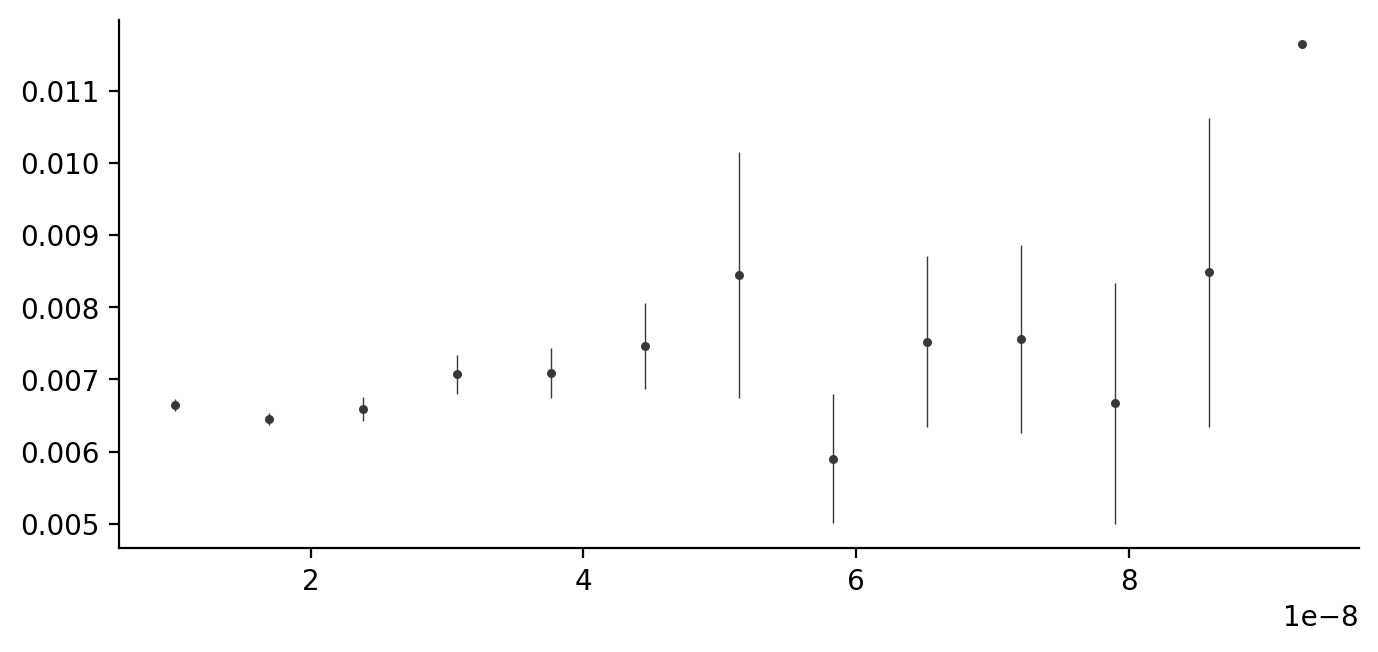

In [585]:

r2pf_bins = binned_summaries(dr2pf['r'], dr2pf['branch_length'], nbins)

binned_means_plot(r2pf_bins)

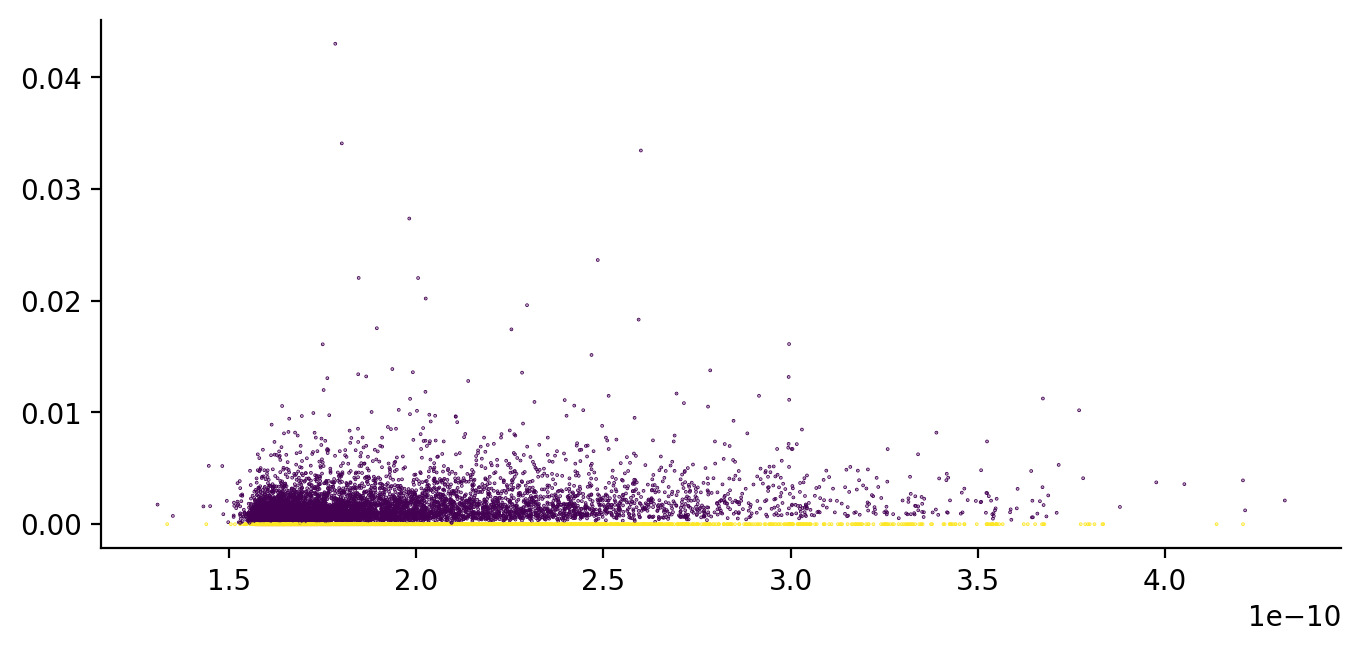

In [613]:
plt.scatter(x_rs/gen, nonsyn_prop, c=nonsyn_prop == 0, s=0.1, alpha=1)

In [602]:
do.loc[do['nonsyn_prop'] == 0, ('nonsyn_prop', 'syn_prop', 'dNdS', 'len')]

nonsyn_prop  syn_prop  dNdS   len
37             0.0  0.002941   0.0  1020
42             0.0  0.002252   0.0  1776
58             0.0  0.000000   NaN   816
70             0.0  0.001365   0.0  5862
71             0.0  0.000000   NaN   384
...            ...       ...   ...   ...
16303          0.0  0.003448   0.0  1740
16304          0.0  0.000000   NaN  1269
16306          0.0  0.002516   0.0  1590
16308          0.0  0.002433   0.0   411
16310          0.0  0.002937   0.0   681

[3945 rows x 4 columns]

(array([3.12174946e-04, 1.09423634e-04, 2.46130998e-05, 8.58932220e-06,
        3.89767562e-06, 1.51576274e-06, 1.80447945e-06, 7.93970960e-07,
        1.44358356e-07, 1.44358356e-07, 1.44358356e-07, 7.21791782e-08,
        1.44358356e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.21791782e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.21791782e-08]),
 array([   123.,   2280.,   4437.,   6594.,   8751.,  10908.,  13065.,
         15222.,  17379

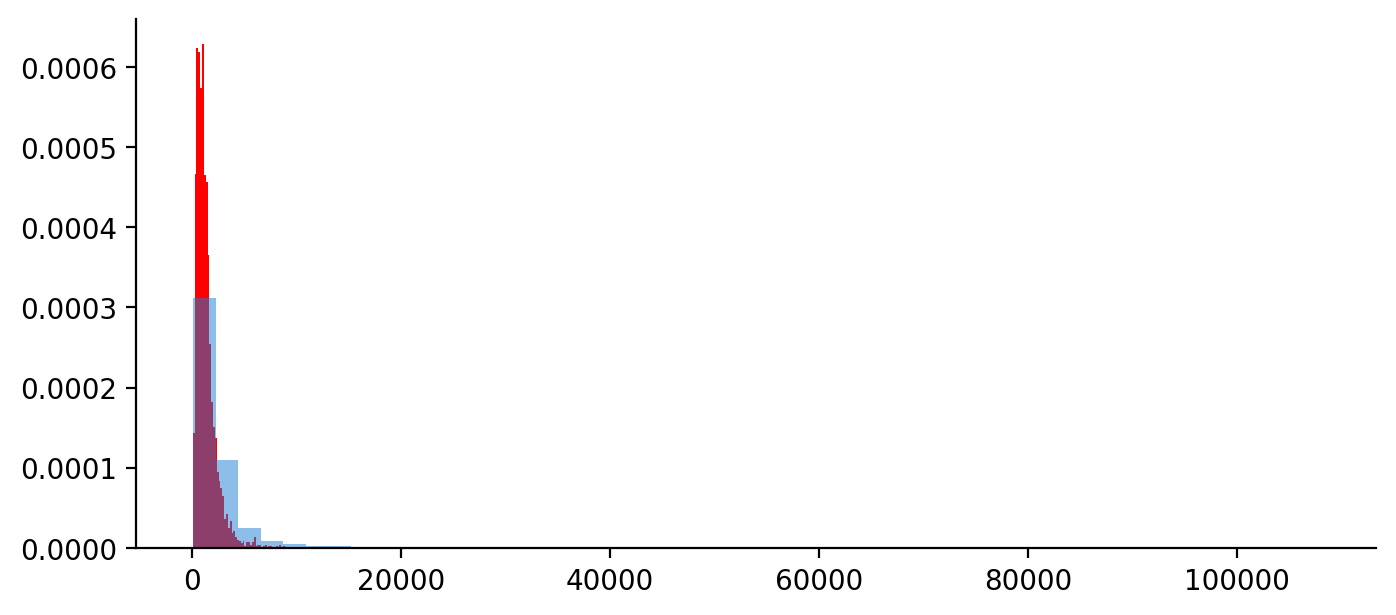

In [609]:
plt.hist(do.loc[do['nonsyn_prop'] == 0]['len'], 50, density=True, color='r')
plt.hist(do.loc[do['nonsyn_prop'] > 0]['len'], 50, density=True, alpha=0.5)

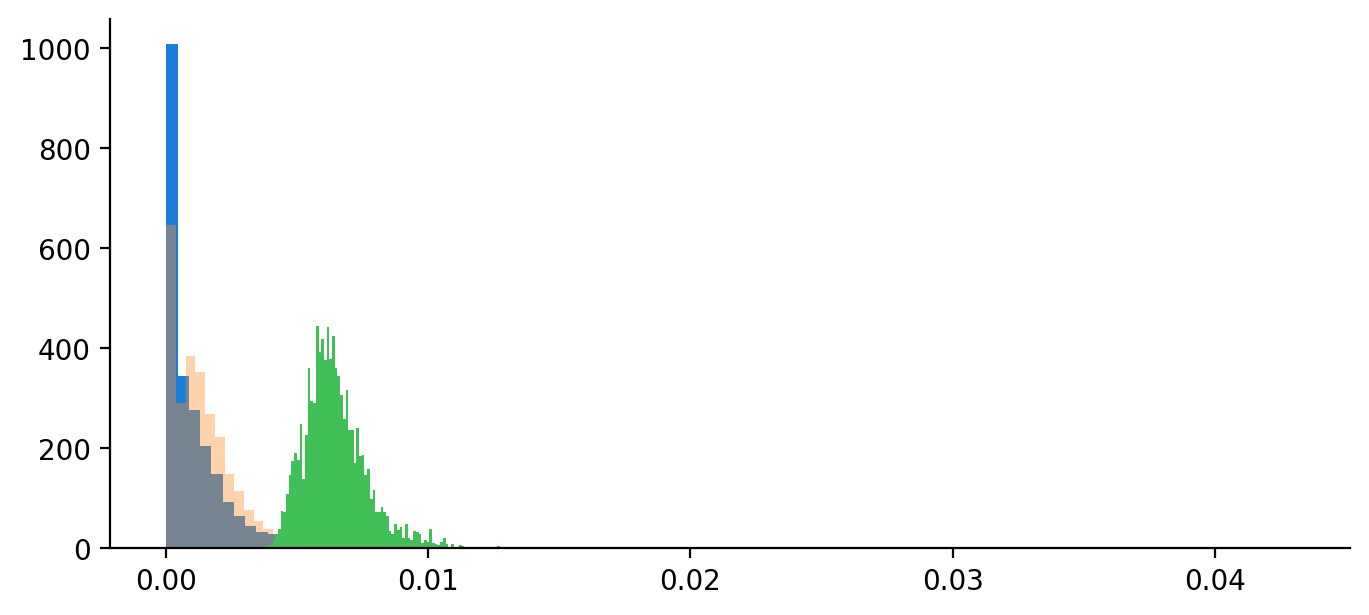

In [282]:
_ = plt.hist(nonsyn_prop, 100, density=True)
_ = plt.hist(syn_prop, 100, density=True, alpha=0.4)
_ = plt.hist(branch_length, 100, density=True)


In [253]:
dr2pfo_bins = binned_summaries(dr2pfo['r'], dr2pfo['branch_length'], nbins=50)

Text(0.5, 0, 'predicted substitution rate')

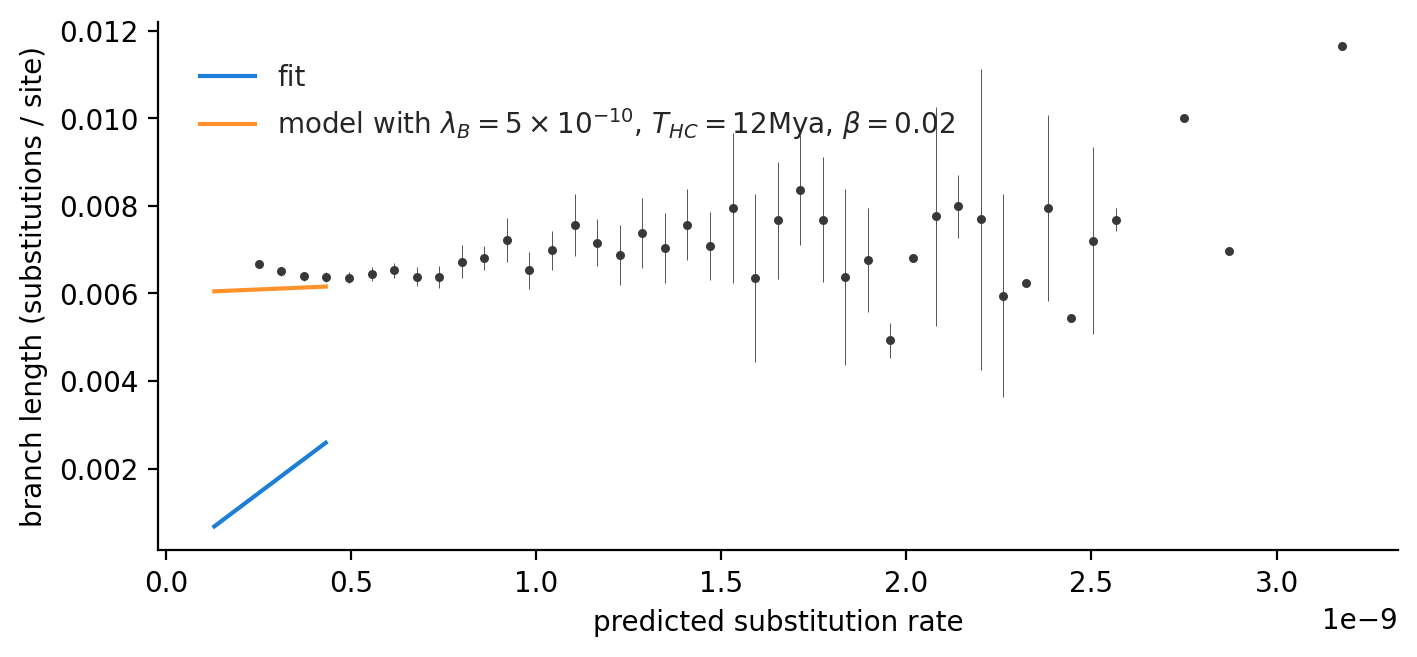

In [529]:
gen = 30
error_col = '0.22'
fig, ax = plt.subplots()
ax.scatter(dr2pfo_bins['midpoint'].values/gen, dr2pfo_bins['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dr2pfo_bins['midpoint']/gen, dr2pfo_bins['mean'], 2*dr2pfo_bins['sd']/np.sqrt(dr2pfo_bins['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='model with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [1082]:
nbins = best_nbin
plt.scatter(*bin2pairs(binned_statistic(x, branch_length, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, nbins))))

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [1017]:
nbins = best_nbin

dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

In [1018]:
min_n = 30
dnsx = dns.loc[dns['n'] > min_n]
dsx = ds.loc[ds['n'] > min_n]
dblx = dbl.loc[dbl['n'] > min_n]


Text(0, 0.5, 'proportion substitutions')

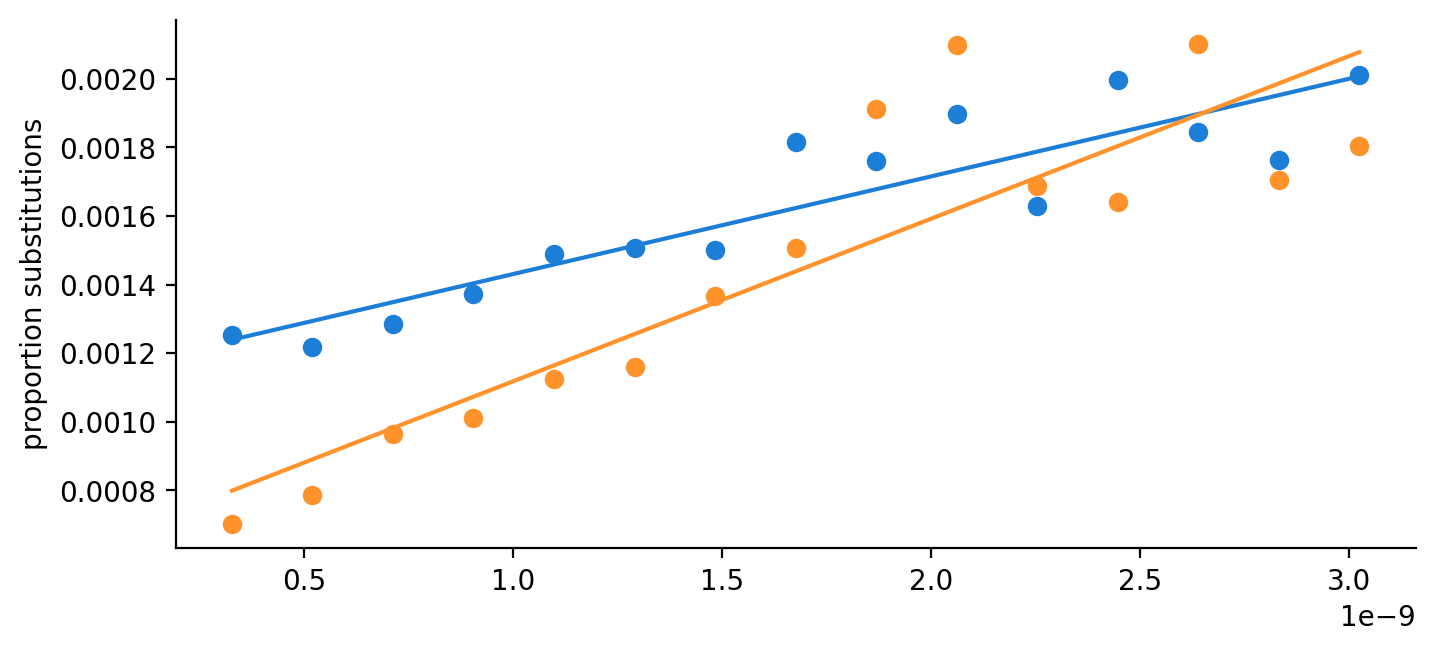

In [1019]:
syn_lfit = stats.linregress(dsx['midpoint']/gen, dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint']/gen, dnsx['mean'])

fig, ax = plt.subplots()
ax.scatter(dsx['midpoint']/gen, dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)/gen
ax.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

ax.scatter(dnsx['midpoint']/gen, dnsx['mean'], label='non-syn')
ax.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)
ax.set_ylabel('proportion substitutions')

In [1058]:
binned_r, binned_bl = dblx['midpoint'].values, dblx['mean'].values
r, bl = do['r'].values, do['branch_length'].values
r1, bl1 = dr2pfo['r'].values, dr2pfo['branch_length'].values

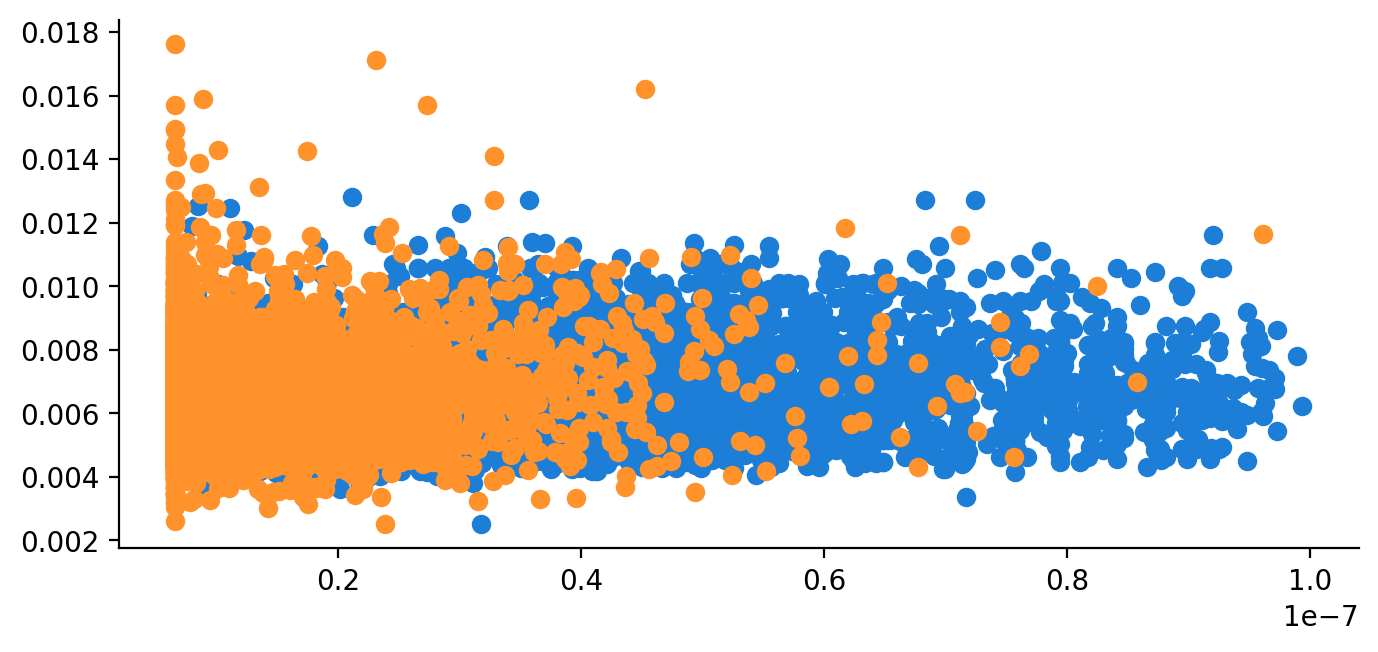

In [1059]:
plt.scatter(r, bl)
plt.scatter(r1, bl1)

(array([9.894e+03, 1.669e+03, 5.630e+02, 1.680e+02, 9.100e+01, 7.200e+01,
        1.100e+01, 5.000e+00, 3.000e+00, 5.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

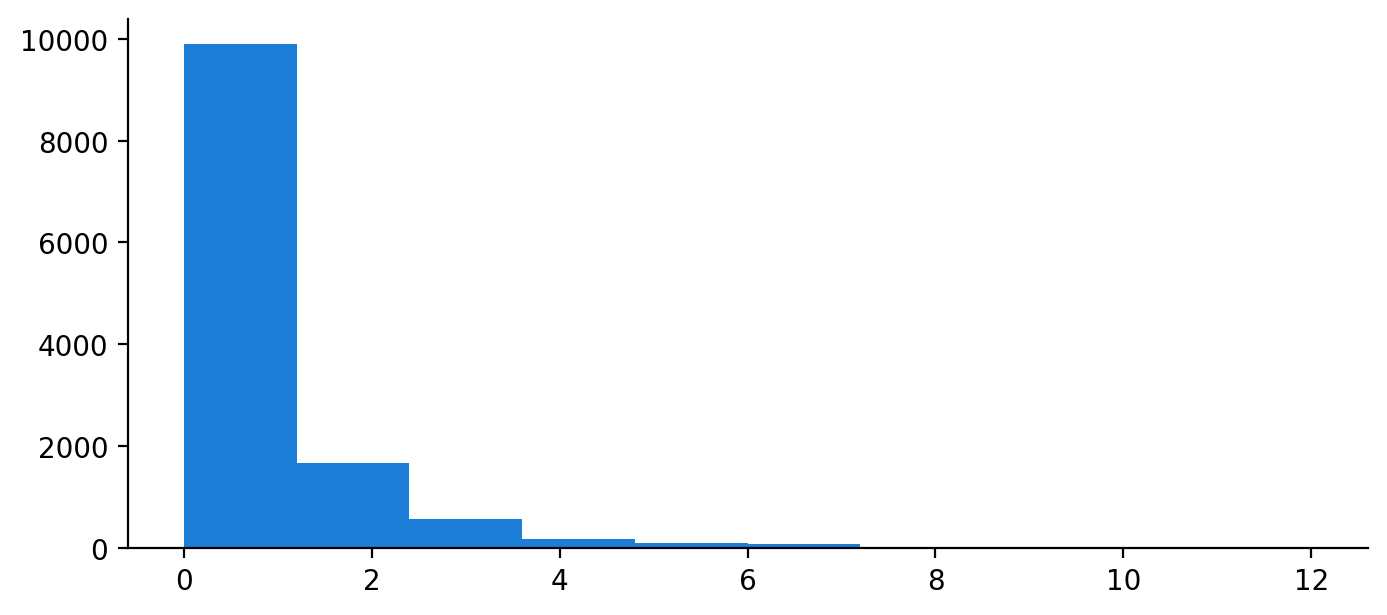

In [797]:
dnds = d['dnDs']
dnds = dnds[np.isfinite(dnds)]
plt.hist(dnds)

In [955]:
np.quantile(dnds, 0.99)

5.0

In [956]:
keep = (d['width'] > 10) & (d['dNdS'] < 5)
r, bl = r[keep], bl[keep]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6588 but corresponding boolean dimension is 16314

In [1060]:
def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

bin_xx, bin_yy, bin_fit = fit_JC69(binned_r, binned_bl)
xx, yy, fit = fit_JC69(r1, bl1)

In [1061]:
fit_JC69(r1, bl1)[2][0], fit_JC69(r, bl)[2][0]

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([7.59803031e-03, 4.31458274e+07, 1.49843883e-10]),
 array([9.27179968e-03, 3.84113959e+07, 1.58034296e-10]))

In [1064]:
fit_JC69(r1, bl1)[2][0][1]

43145827.42707077

In [803]:
dblx.sort_values('midpoint').tail()

start           end      midpoint      mean        sd      n
12  7.817830e-08  7.269783e-08  7.543806e-08  0.006950  0.001496  104.0
13  8.365877e-08  7.817830e-08  8.091853e-08  0.007031  0.001306  119.0
14  8.913924e-08  8.365877e-08  8.639900e-08  0.006857  0.001302   87.0
15  9.461971e-08  8.913924e-08  9.187947e-08  0.006678  0.001506   76.0
17  1.055806e-07  1.001002e-07  1.028404e-07  0.006834  0.001200  183.0

Text(0.5, 0, 'predicted substitution rate')

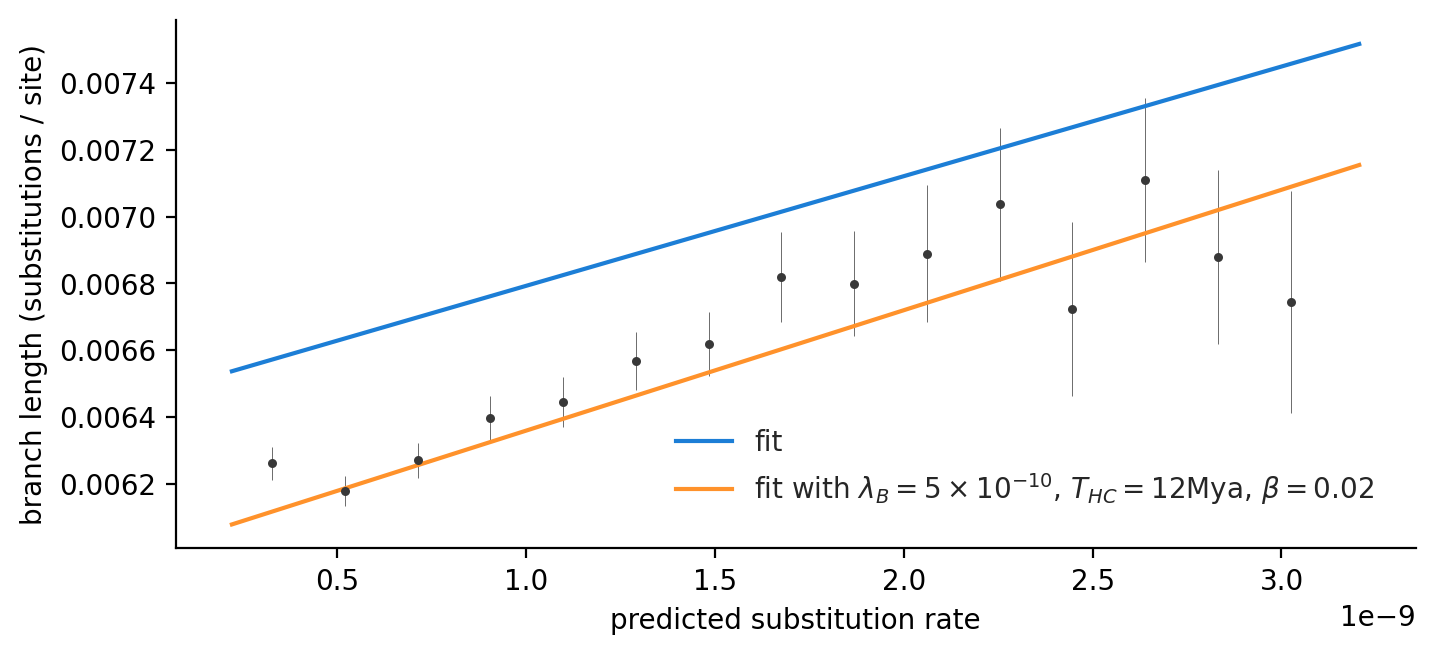

In [1070]:
fig, ax = plt.subplots()
ax.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='fit with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [819]:
#a = binned_summaries(dpf2r['r'], dpf2r['branch_length'], nbins=50)
b = binned_summaries(dr2pf['r'], dr2pf['branch_length'], nbins=50)

<ErrorbarContainer object of 3 artists>

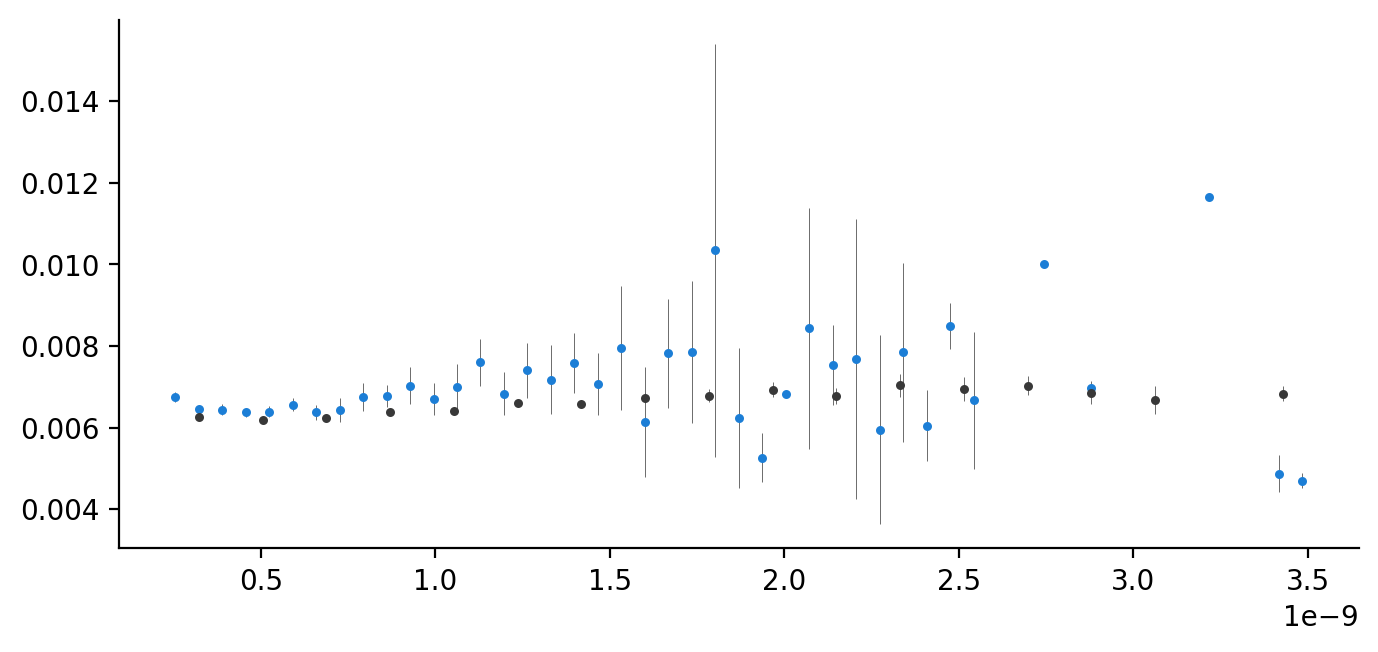

In [827]:
plt.scatter(b['midpoint']/gen, b['mean'], s=5, alpha=1, zorder=10)
plt.errorbar(b['midpoint']/gen, b['mean'], 2*b['sd']/np.sqrt(b['n']), fmt='none', c=error_col, elinewidth=0.3)

plt.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
plt.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

In [791]:
def print_subfit(fit, gen_time=30):
    beta, T, a = fit[0]
    info = (f"intercept (λ_B T), a = {a:.3g}\n"
            f"  λ_B = {a / T:.3g} \n"
            f"T = {T/1e6:.4g} (Mya)\n"
            f"β = {beta:.3g}\n"
            f"{(a / T) / (a + T*beta*1e-9)}")
    print(info)
    
print_subfit(fit)

intercept (λ_B T), a = 3.22e-10
  λ_B = 1.67e-17 
T = 19.24 (Mya)
β = 0.0157
5.544491672682292e-14


In [792]:
print_subfit(bin_fit)

intercept (λ_B T), a = 3.18e-10
  λ_B = 1.63e-17 
T = 19.54 (Mya)
β = 0.0127
6.581669282481193e-14


In [1200]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen', 'subrate']


dd = pd.read_csv('../data/phylo/good.bed',
            names=cols, sep='\t', na_values='.')
dd = dpf2r

/tmp/ipykernel_45271/90671441.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dd = pd.read_csv('../data/phylo/good.bed',


In [1239]:
dd.shape, np.isnan(dd['branch_length']).mean()

((7178677, 8), 0.36476595896430497)

In [197]:
dd_cds = dr2pfo.loc[dr2pfo['feature'] == 'cds']
dd_phastcons = dr2pfo.loc[dr2pfo['feature'] == 'phastcons']
dd_utr = dr2pfo.loc[dr2pfo['feature'] == 'utr']

nbins = 10
dd_cds_binned = binned_summaries(dd_cds['r'], dd_cds['branch_length'], nbins, method='number')
dd_phastcons_binned = binned_summaries(dd_phastcons['r'], dd_phastcons['branch_length'],nbins, method='number')
dd_utr_binned = binned_summaries(dd_utr['r'], dd_utr['branch_length'], nbins, method='number')


dd_cds_binned.head()

KeyError: 'feature'

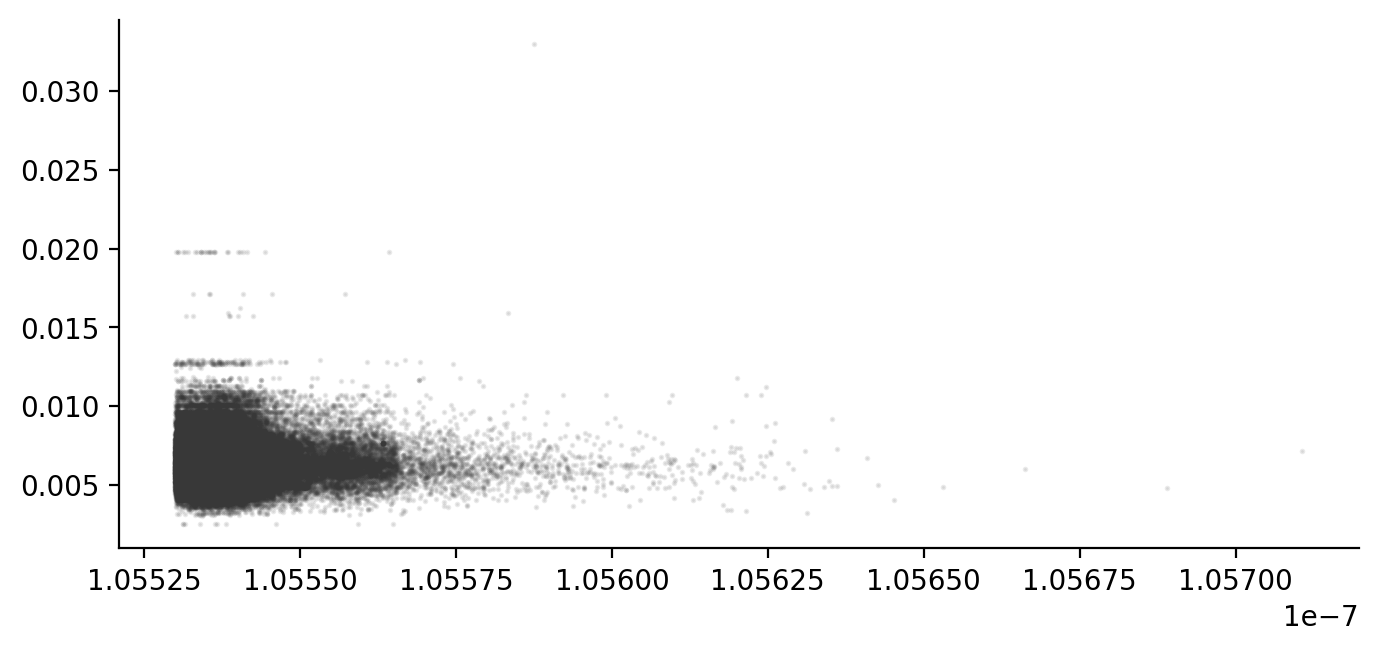

In [1264]:
plt.scatter(dd_cds['r'], dd_cds['branch_length'], c='0.22', s=1, alpha=0.1)

In [1258]:
def binned_means_plot(df, min_n=None, error_col='0.22', linewidth=0.5, figax=None):
    fig, ax = get_figax(figax)
    
    if min_n is not None:
        df = df.loc[df['n'] > min_n]
    x = df['midpoint'].values
    mean, sd = df['mean'].values, df['sd'].values
    n = df['n'].values
    ax.scatter(x, mean, c='0.22', s=5, alpha=1, zorder=10)
    ax.errorbar(x, mean, 2*sd/np.sqrt(n), fmt='none', c=error_col, elinewidth=linewidth)
    return fig, ax

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

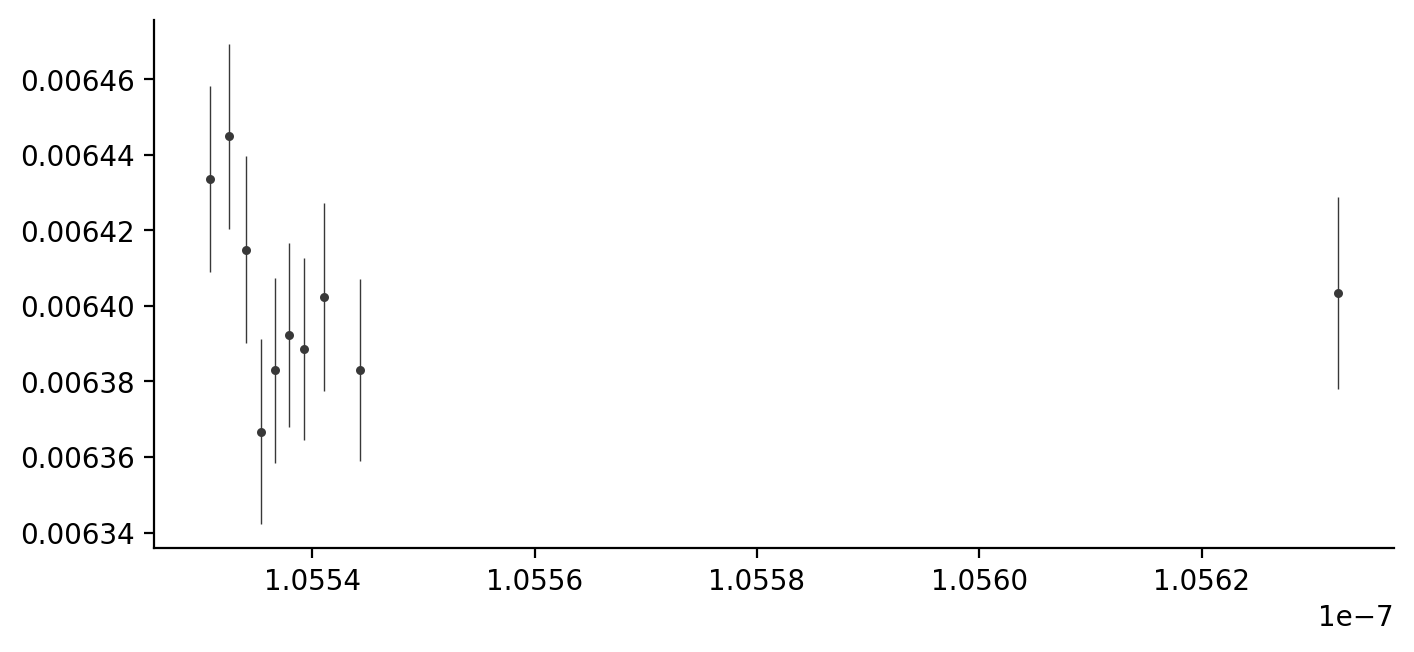

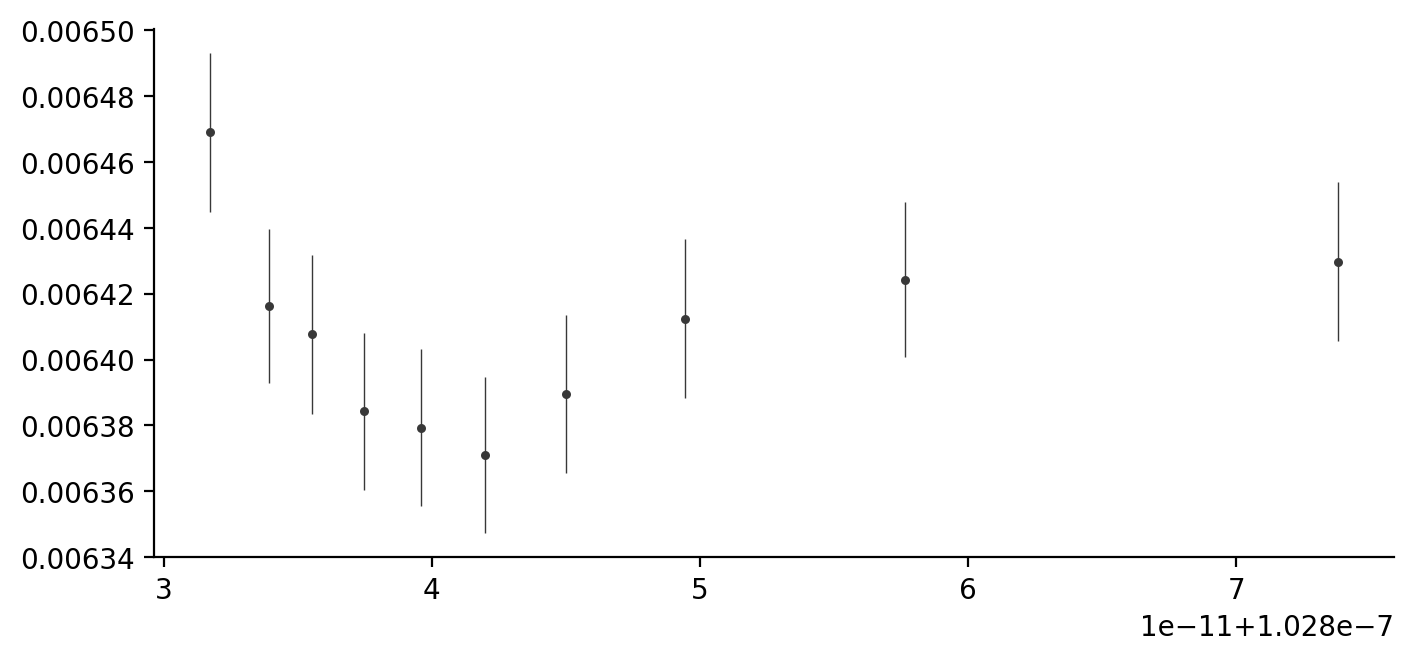

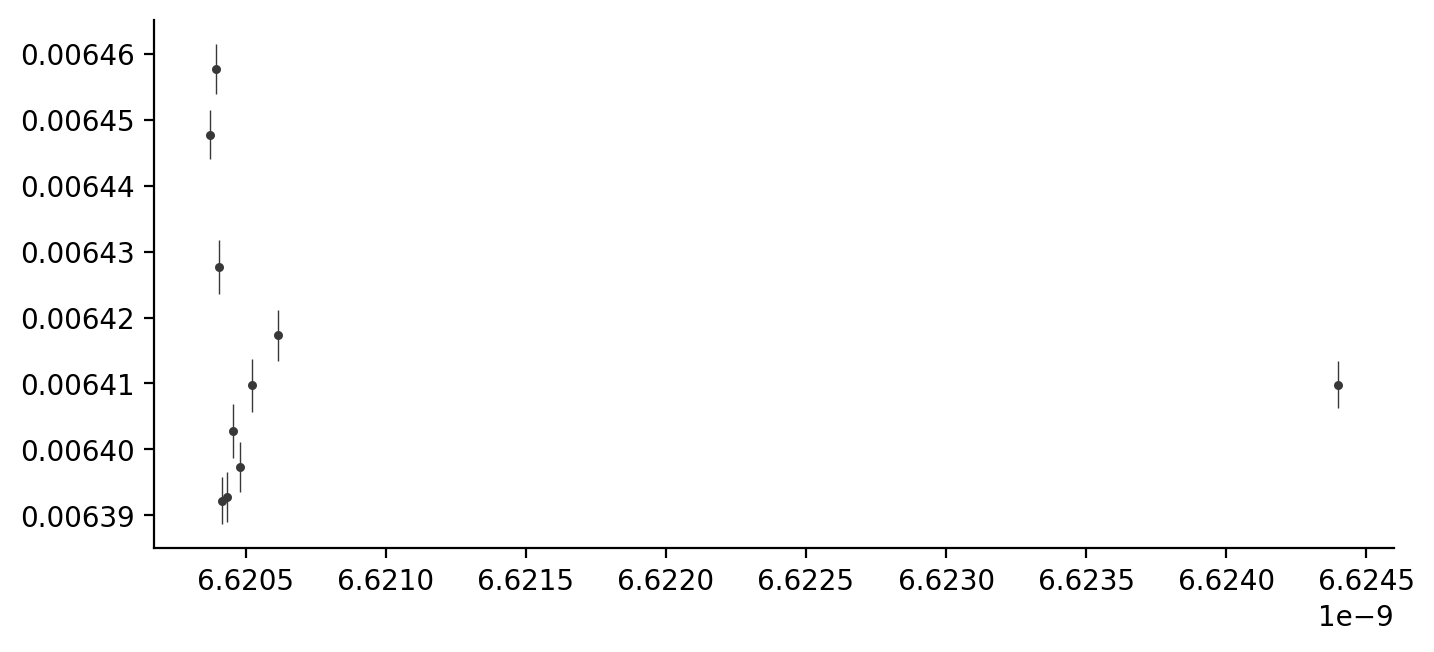

In [1272]:
binned_means_plot(dd_cds_binned, min_n=10)
binned_means_plot(dd_utr_binned, min_n=10)
binned_means_plot(dd_phastcons_binned, min_n=10)

(6.620173385745607e-09, 6.6207e-09)

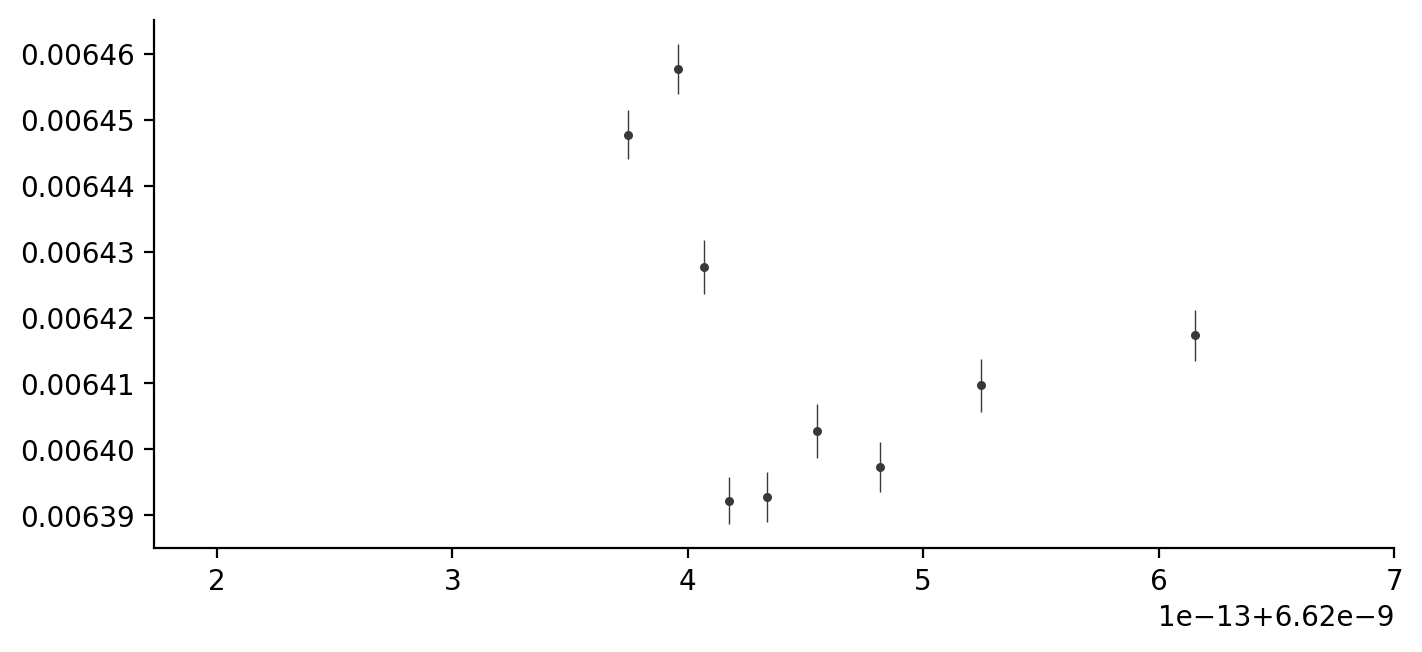

In [1275]:
fig, ax = binned_means_plot(dd_phastcons_binned, min_n=10)
ax.set_xlim(ax.get_xlim()[0], 6.6207e-9)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

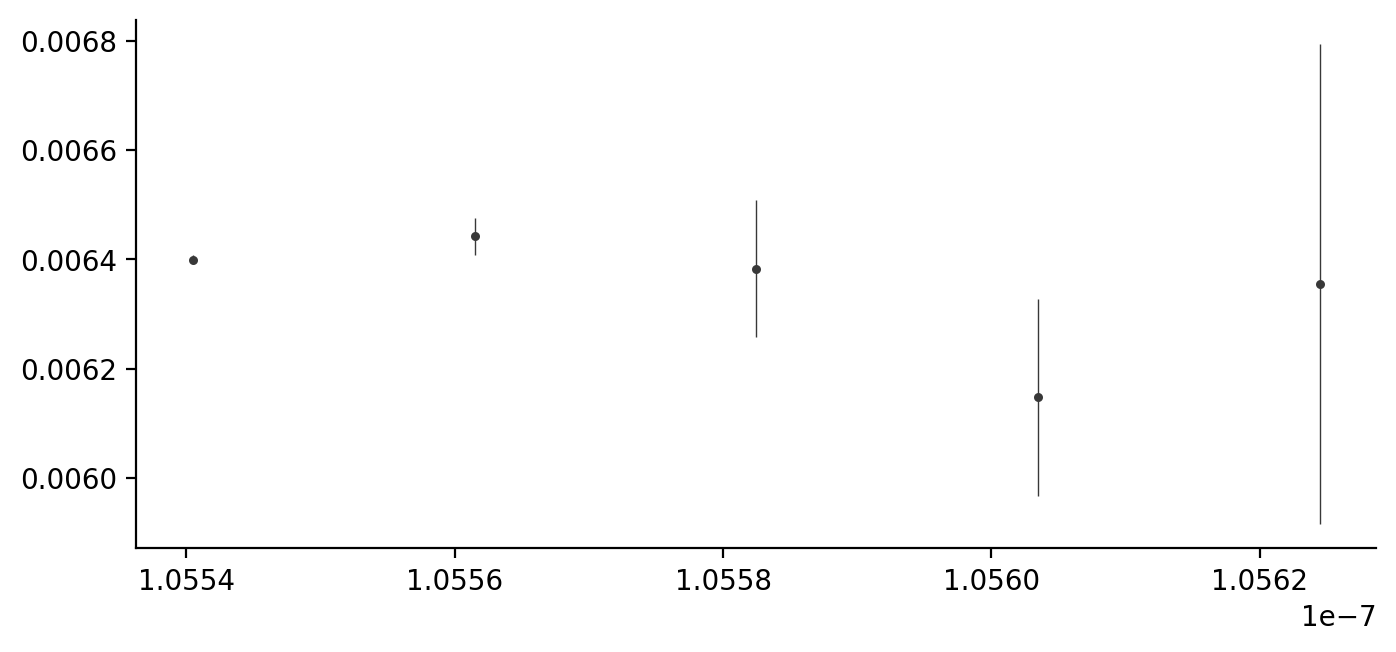

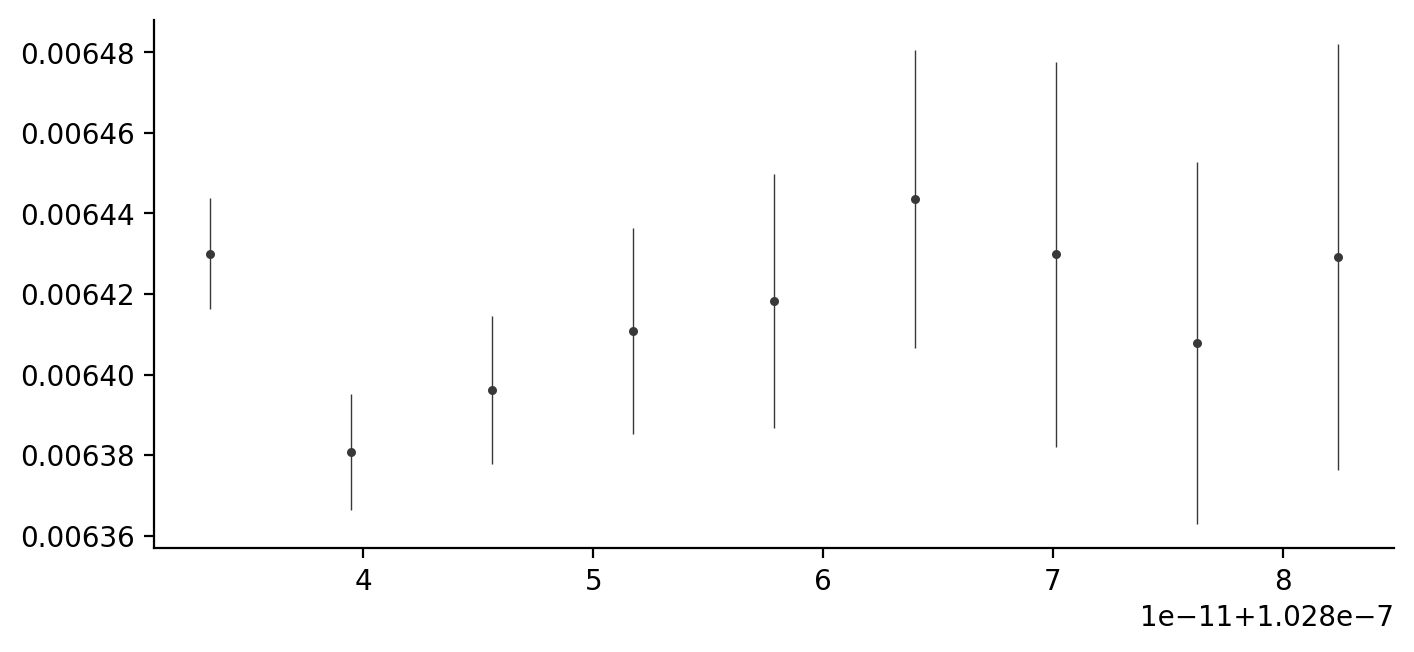

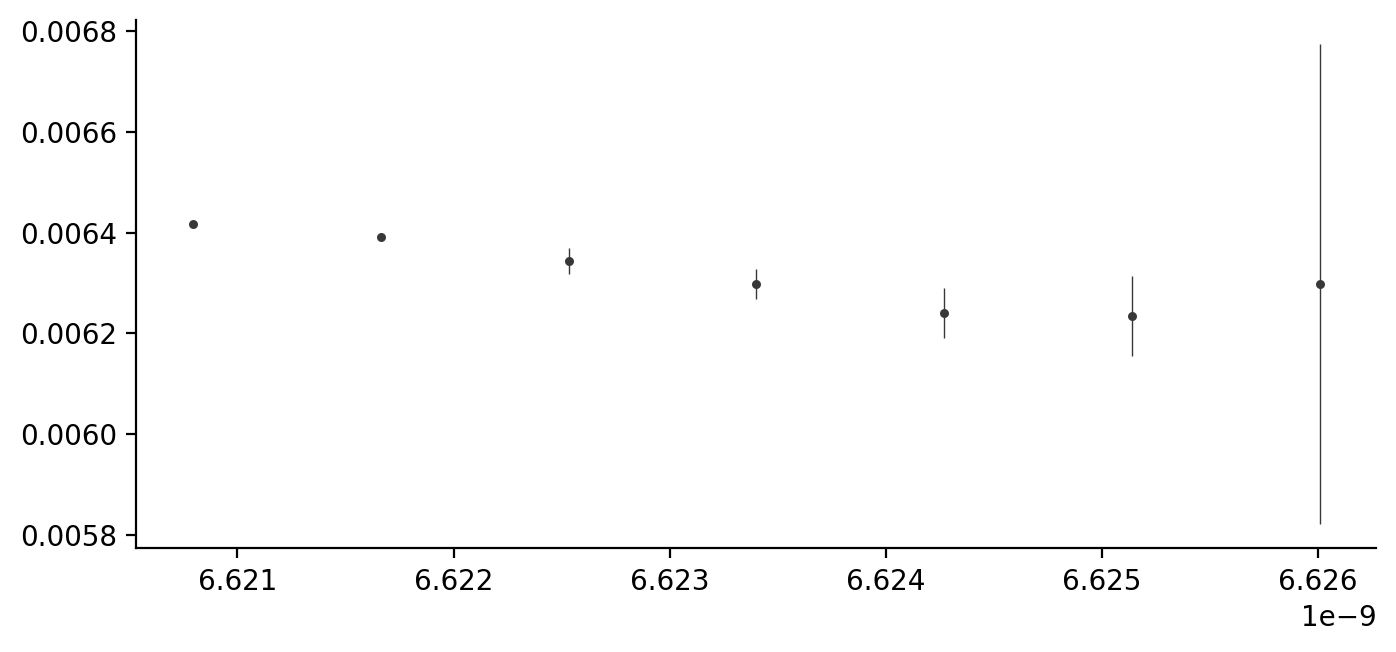

In [1266]:

nbins = 10
dd_cds_binned = binned_summaries(dd_cds['r'], dd_cds['branch_length'], nbins)
dd_phastcons_binned = binned_summaries(dd_phastcons['r'], dd_phastcons['branch_length'], nbins)
dd_utr_binned = binned_summaries(dd_utr['r'], dd_utr['branch_length'], nbins)

binned_means_plot(dd_cds_binned, min_n=10)
binned_means_plot(dd_utr_binned, min_n=10)
binned_means_plot(dd_phastcons_binned, min_n=10)

In [1228]:
#plt.scatter(dd_cds['r'], dd_cds['subrate'])
cds_r, cds_subrate = dd_cds['r'], dd_cds['branch_length']
keep = np.isfinite(cds_r) & np.isfinite(cds_subrate)
cds_r, cds_subrate = cds_r[keep], cds_subrate[keep]
lfit = stats.linregress(cds_r, cds_subrate)
lfit


LinregressResult(slope=-1003103.2957447512, intercept=0.11226757366857096, rvalue=-0.006528633454956384, pvalue=0.034888936998935076, stderr=475478.1775249141, intercept_stderr=0.050181445188847505)